# Personal Loan Modeling Project
## Submission Date: 07.2023
## Contributers: [Abdurrahman ODABAŞI](https://www.kaggle.com/odabashi), Ahmad SÜLEYMAN


# 0. Imports

In [ ]:
import pandas as pd
import pprint
import numpy as np
import os
import time
import datetime
import warnings
warnings.filterwarnings('ignore')

# 1. Section
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Section
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import OneSidedSelection
from imblearn.pipeline import Pipeline as imPipeline

# 3. & 4. Sections
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, PrecisionRecallDisplay, classification_report
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.inspection import permutation_importance

# 0.1 Intro:


Problem Description:


The file Bank.xls contains data on 5000 customers. The data include customer demographic information (age, income, etc.), the customer's relationship with the bank (mortgage, securities account, etc.), and the customer response to the last personal loan campaign (Personal Loan). Among these 5000 customers, only 480 (= 9.6%) accepted the personal loan that was offered to them in the earlier campaign.


This case is about a bank (Thera Bank) whose management wants to explore ways of converting its liability customers to personal loan customers (while retaining them as depositors). A campaign that the bank ran last year for liability customers showed a healthy conversion rate of over 9% success. This has encouraged the retail marketing department to devise campaigns with better target marketing to increase the success ratio with minimal budget.


Features:

* ID: ID of the bank customer

* Age: Age of the customer

* Experience: Number of Years of Professional Experience

* Income: Annual Income of the customer (in 1000$)

* ZIP Code: ZIP code related with the home address of the customer.

* Family: Family Size of the Customer (Including Husband/Wife and Children)

* CCAvg: Average spending on credit cards per month (in 1000$)

* Education Level: {1: Undergrad; 2: Graduate; 3: Advanced/Professional}

* Mortgage: Value of house mortgage if there are any (in 1000$)

* Securities Account: Does the customer have a securities account with the bank? {1: Yes, 0: No}

* CD Account: Does the customer have a certificate of deposit (CD) account with the bank? {1: Yes, 0: No}

* Online: Does the customer use internet banking facilities? {1: Yes, 0: No}

* CreditCard: Does the customer use a credit card issued by this Bank? {1: Yes, 0: No}

* Personal Loan (Label): Did this customer accept the personal loan offered in the last campaign? {1: Yes, 0: No}

# 0.2 Table of Contents

- Problem Description
- Exploratory Data Analysis (EDA)
- Data Preparation
  - Dealing with "Experience" Feature
  - Dealing with "ZIP Code" Feature
  - Dealing with Outliers
  - Splitting the Data
  - Standardizing the Features
  - Dealing with Data imbalance
  - Dimensionality Reduction
- Modeling
  - Training
    - Logistic Regression
    - Support Vector Machine Classifier
    - K-Nearest Neighbors
    - Stochstic Gradient Descent Classifier
    - Gaussian Naive Bayes
    - Decision Tree Classifier
    - Random Forest Classifier
    - Extra Trees Classifier
    - XGBoost Classifier
    - Balanced Bagging Classifier
  - Model Performance Analysis
  - Voting Classifier
  - Best Model Selection
  - Hyperparameter Tuning
  - Re-training Voting Classifier
  - Comparison between Normal Models and Fine-tuned Models
  - Performance Analysis of Fine-tuned Models
- Evaluation
  - Classification Report (Precision, Recall, F1, Accuracy)
  - Precision/Recall Curve
  - Confusion Matrix
  - Feature Importance

# 0.3 Helper Functions

In [ ]:
def plot_catplot_for_training_metrics(datasets, metrics, metric_name, yticks_interval_space=0.05, yticks_limits=(0,1)):
  metrics_dict = {
    'Dataset': datasets
  }
  metrics_dict[metric_name] = metrics
  df = pd.DataFrame(metrics_dict)
  my_catplot = sns.catplot(x="Dataset", y=metric_name, kind="bar", height=4, aspect=1.5, orient='v',  data=df)
  my_catplot.set_xticklabels(fontsize=10, rotation=45)
  plt.yticks(
      [i * yticks_interval_space for i in range(100)],  # Set the y-axis tick positions at intervals of 0.05
      [str(round(i * yticks_interval_space, 2)) for i in range(100)]  # Set the corresponding tick labels
  )
  my_catplot.set(ylim=yticks_limits)

  ax2 = my_catplot.facet_axis(0,0)
  for p in ax2.patches:
    ax2.text(
      p.get_x() + 0.3,
      p.get_height() * 1.005,
      '{0:.2f}'.format(p.get_height()),
      color='black',
      rotation='horizontal',
      size='large')

  # Add a border to the figure
  fig = my_catplot.fig
  fig.patch.set_edgecolor('black')
  fig.patch.set_linewidth(1.5)
  return my_catplot

# 1. Data Understanding

## 1.1 Data Loading

In [ ]:
dataset_path = 'https://raw.githubusercontent.com/odabashi/Personal-Loan-Prediction/master/data.csv'
df = pd.read_csv(dataset_path, sep = ',', decimal = '.')
print("The dataset has the shape of ", df.shape, "where it has 5000 rows, each of them has 13 Features and 1 Label")

The dataset has the shape of  (5000, 14) where it has 5000 rows, each of them has 13 Features and 1 Label


In [ ]:
# Outputting the first 10 Records
df.head(10)

ID  Age  Experience  Income  ZIP Code  Family  CCAvg  Education  Mortgage  \
0   1   25           1      49     91107       4    1.6          1         0   
1   2   45          19      34     90089       3    1.5          1         0   
2   3   39          15      11     94720       1    1.0          1         0   
3   4   35           9     100     94112       1    2.7          2         0   
4   5   35           8      45     91330       4    1.0          2         0   
5   6   37          13      29     92121       4    0.4          2       155   
6   7   53          27      72     91711       2    1.5          2         0   
7   8   50          24      22     93943       1    0.3          3         0   
8   9   35          10      81     90089       3    0.6          2       104   
9  10   34           9     180     93023       1    8.9          3         0   

   Personal Loan  Securities Account  CD Account  Online  CreditCard  
0              0                   1           0       0           0  
1              0                   1           0       0           0  
2              0                   0           0       0           0  
3              0                   0           0       0           0  
4              0                   0           0       0           1  
5              0                   0           0       1           0  
6              0                   0           0       1           0  
7              0                   0           0       0           1  
8              0                   0           0       1           0  
9              1                   0           0       0           0

In [ ]:
# Outputting information about the dataset columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIP Code            5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal Loan       5000 non-null   int64  
 10  Securities Account  5000 non-null   int64  
 11  CD Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


In [ ]:
# Checking for the count of unique values for each column in the dataset
df.nunique(axis=0, dropna=True) # Return Series with number of distinct observations. Can ignore NaN values. axis:0 -> row-wise, dropna=True -> ignore NaN

ID                    5000
Age                     45
Experience              47
Income                 162
ZIP Code               467
Family                   4
CCAvg                  108
Education                3
Mortgage               347
Personal Loan            2
Securities Account       2
CD Account               2
Online                   2
CreditCard               2
dtype: int64

In [ ]:
# Check for null values
df.isnull().sum()

ID                    0
Age                   0
Experience            0
Income                0
ZIP Code              0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal Loan         0
Securities Account    0
CD Account            0
Online                0
CreditCard            0
dtype: int64

In [ ]:
# Check for nan values
df.isna().sum()

ID                    0
Age                   0
Experience            0
Income                0
ZIP Code              0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal Loan         0
Securities Account    0
CD Account            0
Online                0
CreditCard            0
dtype: int64

In [ ]:
df.columns

Index(['ID', 'Age', 'Experience', 'Income', 'ZIP Code', 'Family', 'CCAvg',
       'Education', 'Mortgage', 'Personal Loan', 'Securities Account',
       'CD Account', 'Online', 'CreditCard'],
      dtype='object')

In [ ]:
df = df.rename(columns={'Securities Account': 'Securities_Account', 'ZIP Code': 'ZIP_Code', 'CD Account': 'CD_Account'})

# We will change the name of the label column to `Label`
df = df.rename(columns={'Personal Loan': 'Label'})

In [ ]:
# We will drop the 'ID' column as it does not contain any relevant information for predicting the target variable
df = df.drop('ID', axis=1)

In [ ]:
duplicatedRows = df[df.duplicated()] # There is no duplicated Rows
duplicatedRows

Empty DataFrame
Columns: [Age, Experience, Income, ZIP_Code, Family, CCAvg, Education, Mortgage, Label, Securities_Account, CD_Account, Online, CreditCard]
Index: []

In [ ]:
# Describing the statistical measures related to our features
df.describe(include='all').transpose()

count          mean          std     min      25%  \
Age                 5000.0     45.338400    11.463166    23.0     35.0   
Experience          5000.0     20.104600    11.467954    -3.0     10.0   
Income              5000.0     73.774200    46.033729     8.0     39.0   
ZIP_Code            5000.0  93152.503000  2121.852197  9307.0  91911.0   
Family              5000.0      2.396400     1.147663     1.0      1.0   
CCAvg               5000.0      1.937938     1.747659     0.0      0.7   
Education           5000.0      1.881000     0.839869     1.0      1.0   
Mortgage            5000.0     56.498800   101.713802     0.0      0.0   
Label               5000.0      0.096000     0.294621     0.0      0.0   
Securities_Account  5000.0      0.104400     0.305809     0.0      0.0   
CD_Account          5000.0      0.060400     0.238250     0.0      0.0   
Online              5000.0      0.596800     0.490589     0.0      0.0   
CreditCard          5000.0      0.294000     0.455637     0.0      0.0   

                        50%      75%      max  
Age                    45.0     55.0     67.0  
Experience             20.0     30.0     43.0  
Income                 64.0     98.0    224.0  
ZIP_Code            93437.0  94608.0  96651.0  
Family                  2.0      3.0      4.0  
CCAvg                   1.5      2.5     10.0  
Education               2.0      3.0      3.0  
Mortgage                0.0    101.0    635.0  
Label                   0.0      0.0      1.0  
Securities_Account      0.0      0.0      1.0  
CD_Account              0.0      0.0      1.0  
Online                  1.0      1.0      1.0  
CreditCard              0.0      1.0      1.0

## 1.2 Exploratory Data Analysis (EDA)

### Checking Imbalance

Saving figure label_imbalance


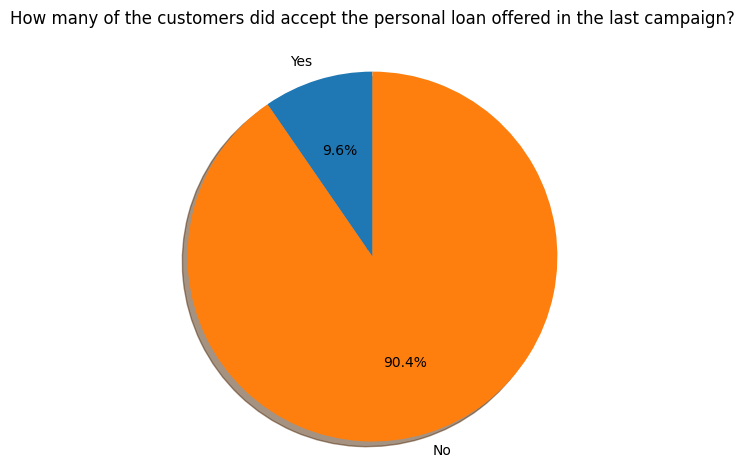

In [ ]:
positive_count = df[df.Label == 1].shape[0]
negative_count = df[df.Label == 0].shape[0]

labels = 'Yes', 'No'
sizes = [positive_count, negative_count]
explode = (0, 0)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.title("How many of the customers did accept the personal loan offered in the last campaign?\n")
plt.show()

Our dataset is strictly imbalanced. One of our priorities while doing this project must be dealing with that imbalance

### Correlation Matrix

Saving figure correlation_matrix


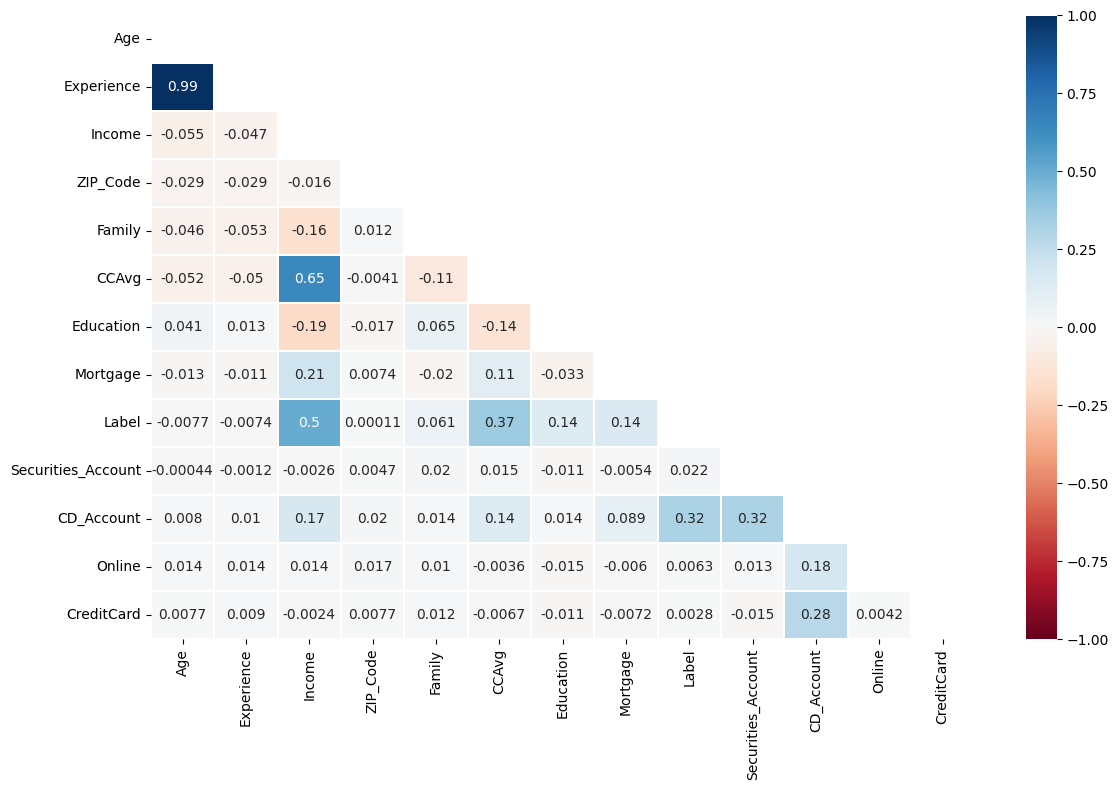

In [ ]:
fig_dims = (12, 8)
correlation = df.corr() # Compute pairwise correlation of columns, excluding NA/null values.
mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize = fig_dims)
sns.heatmap(correlation, ax=ax, mask=mask, annot=True, vmin=-1, vmax=1, cmap="RdBu", linewidths=0.25)
plt.show() # This will be more reliable after the categorical values had been converted to different columns

We can see that there is a good correlation between the income and the accepting the personal loan offer

### Analyzing the Features

#### 0. Pair Plots and Histograms

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Experience'}>,
        <Axes: title={'center': 'Income'}>,
        <Axes: title={'center': 'ZIP_Code'}>],
       [<Axes: title={'center': 'Family'}>,
        <Axes: title={'center': 'CCAvg'}>,
        <Axes: title={'center': 'Education'}>,
        <Axes: title={'center': 'Mortgage'}>],
       [<Axes: title={'center': 'Label'}>,
        <Axes: title={'center': 'Securities_Account'}>,
        <Axes: title={'center': 'CD_Account'}>,
        <Axes: title={'center': 'Online'}>],
       [<Axes: title={'center': 'CreditCard'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

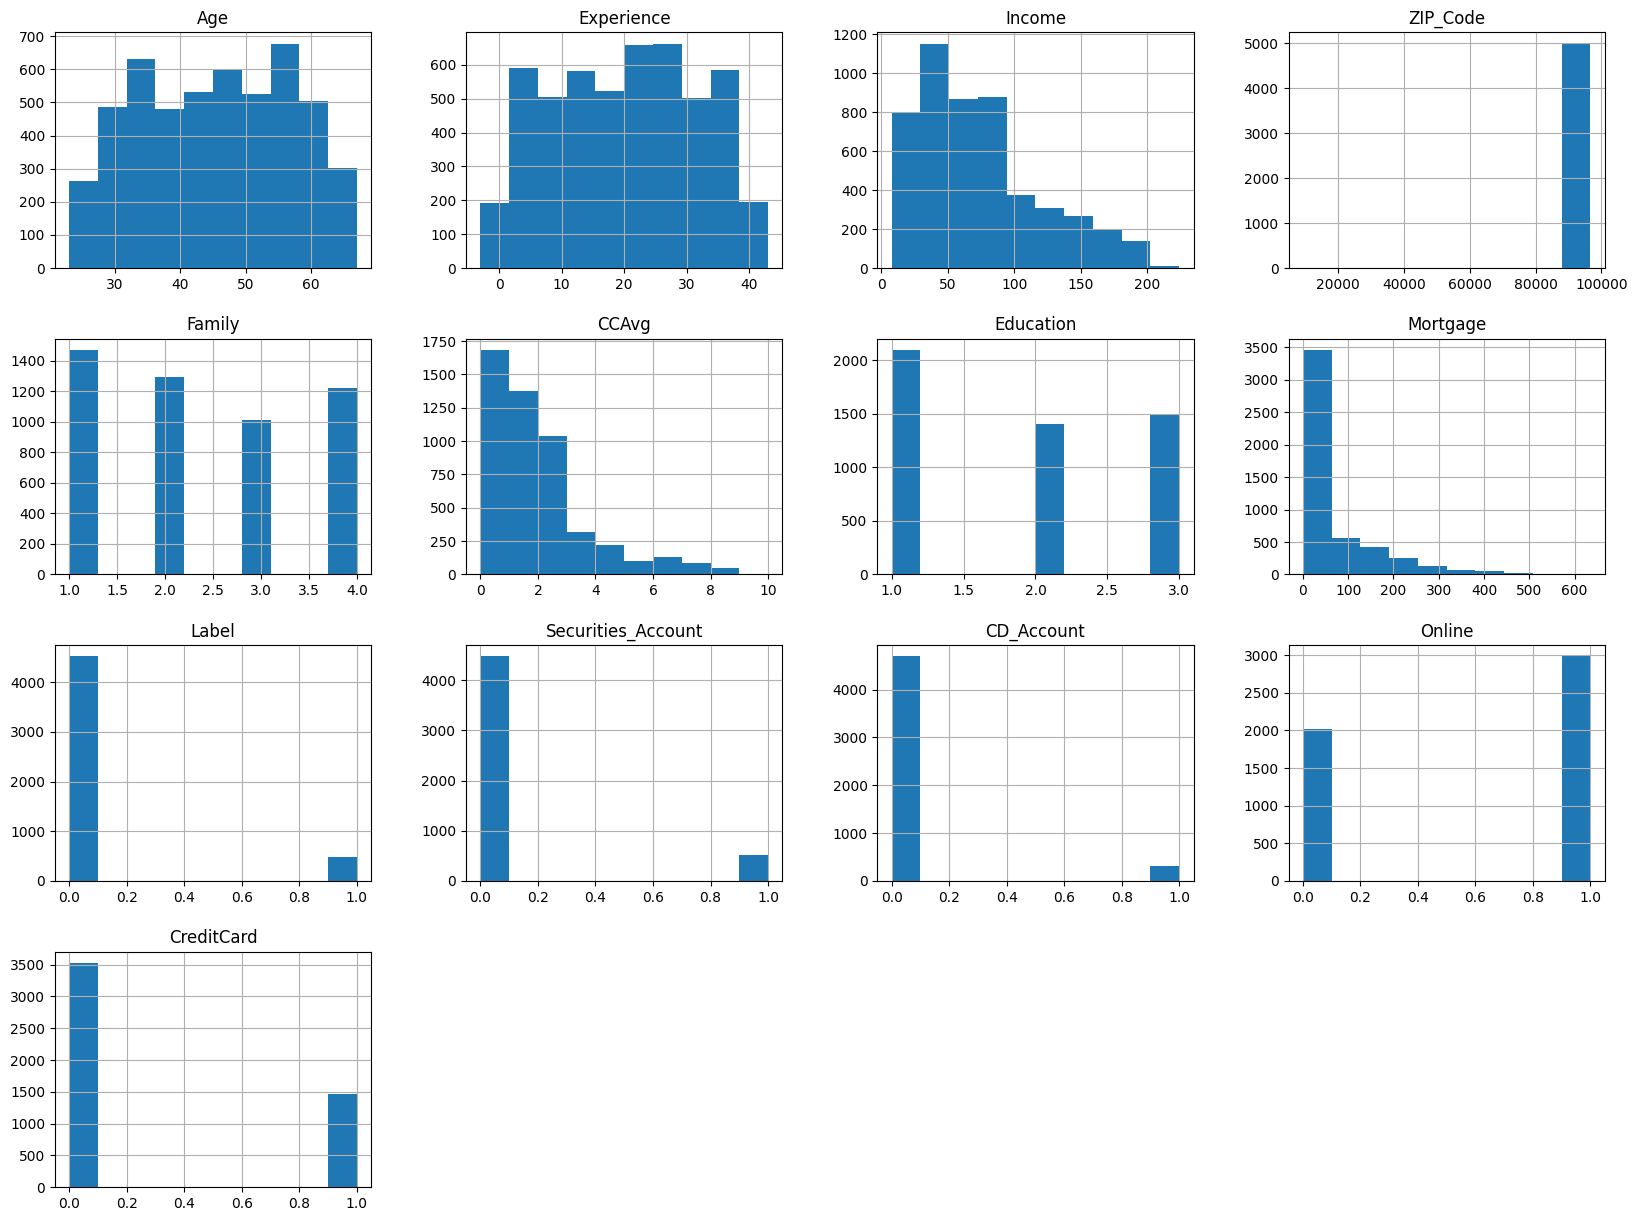

In [ ]:
df.hist(figsize=(20,15))

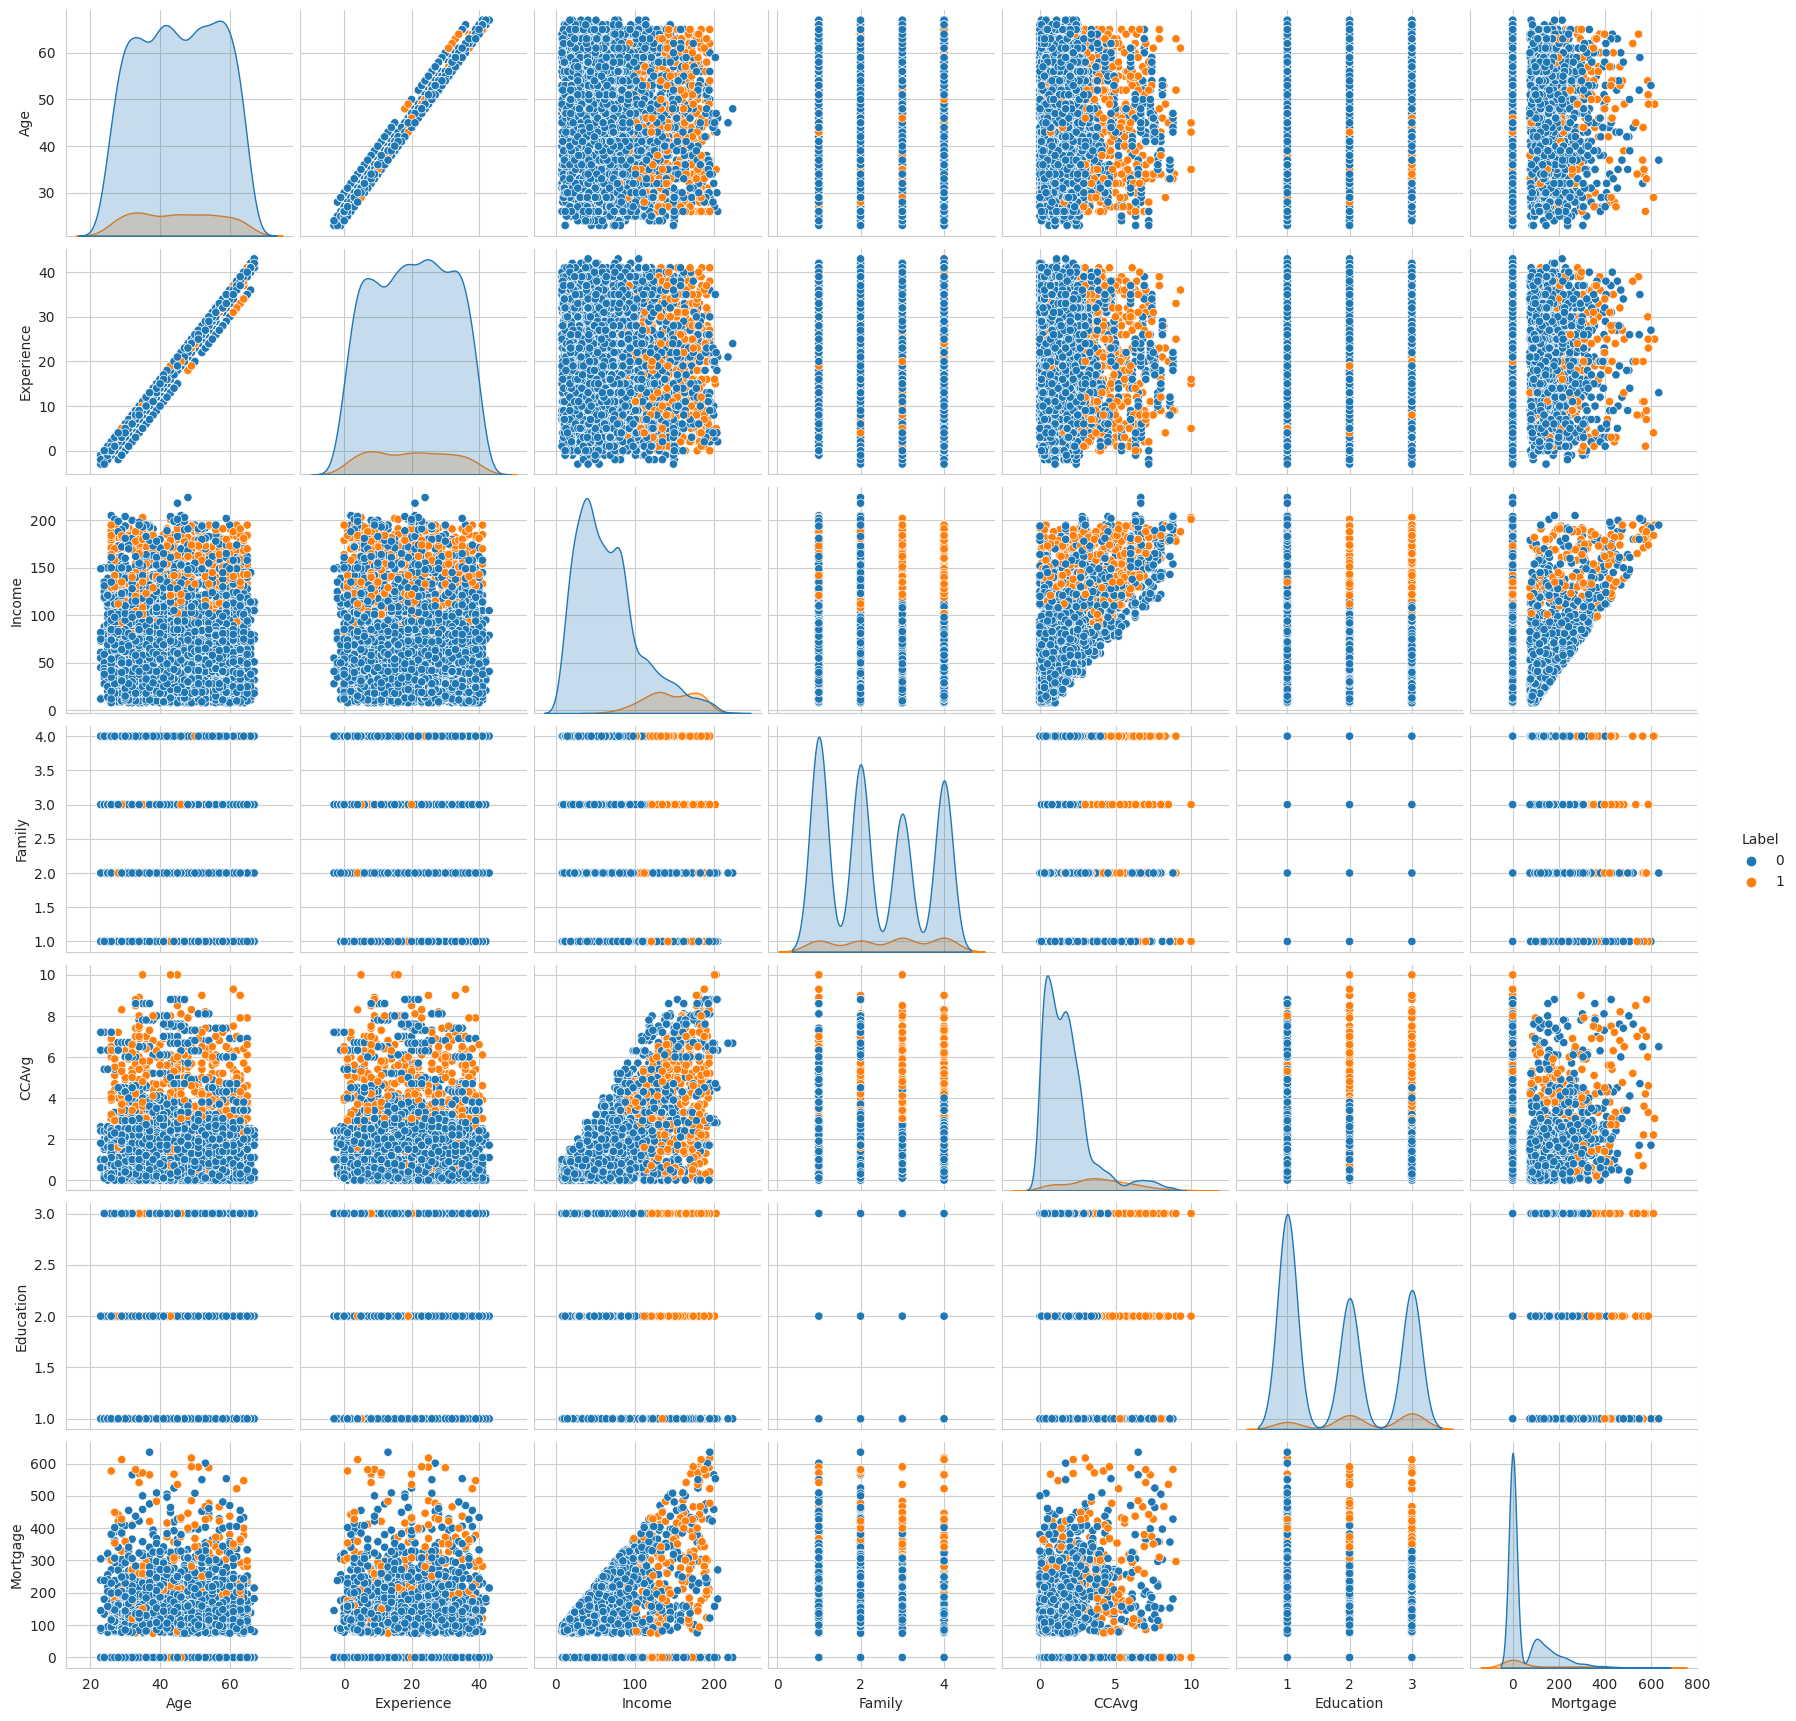

In [ ]:
sns.set_style("whitegrid")

# sns.pairplot(df, hue="Label")
sns.pairplot(df[["Age", "Experience", "Income", "Family", "CCAvg", "Education", "Mortgage", "Label"]], hue="Label")

#### 1. Age

<Axes: xlabel='Age', ylabel='count'>

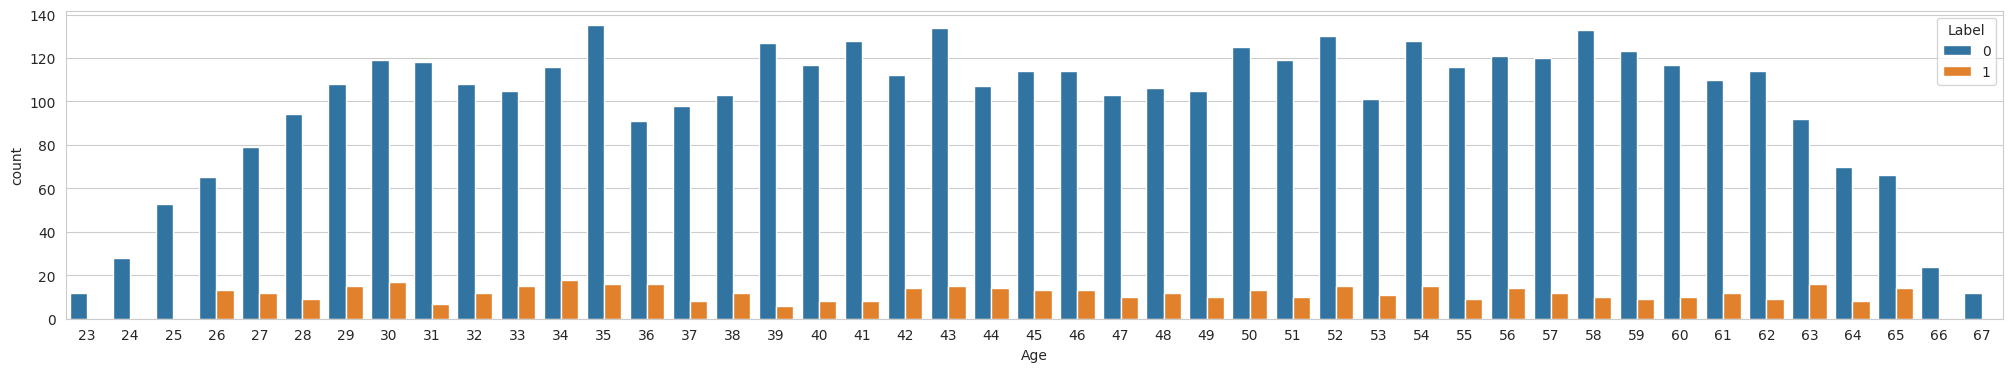

In [ ]:
sns.set_style("whitegrid")

plt.figure(figsize=(25,4))
sns.countplot(x=df["Age"], hue=df["Label"])

We can see that no one of the customers that are 25 years old and younger did accept the personal loan offer. Also there is no customer that is 66 years old or older did accept the offer.

#### 2. Experience

<Axes: xlabel='Experience', ylabel='count'>

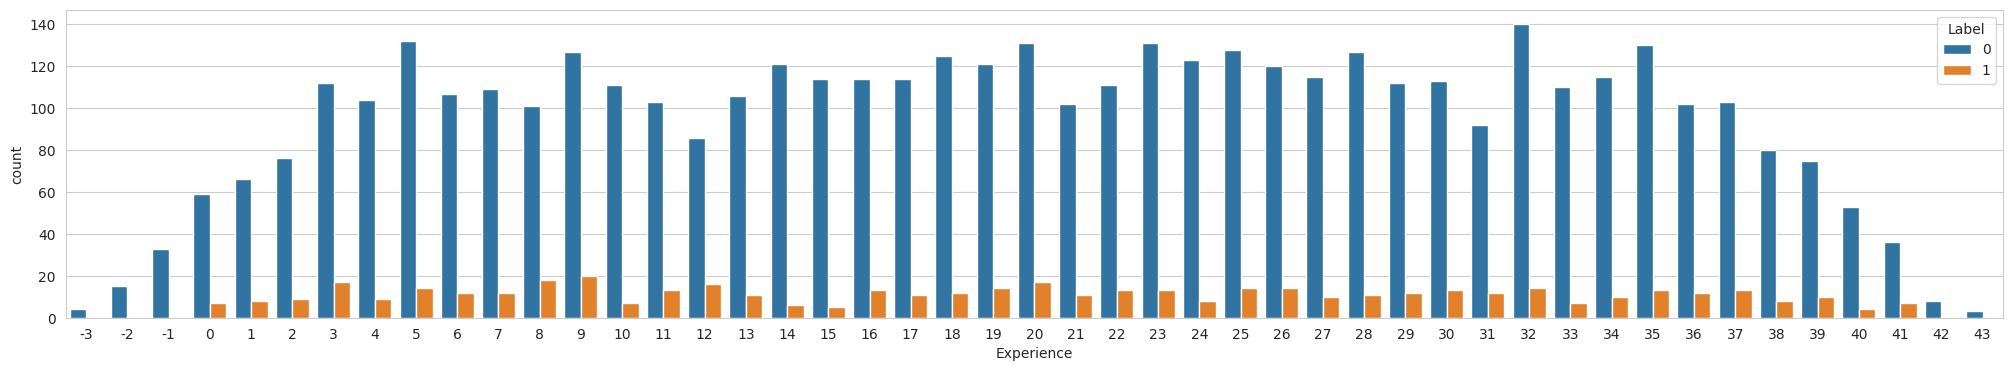

In [ ]:
sns.set_style("whitegrid")

plt.figure(figsize=(25,4))
sns.countplot(x=df["Experience"], hue=df["Label"])

There is some invalid values (-3, -2, -1). We should deal with records that have these values.

#### 3. Income

Saving figure eda_income_facetplot


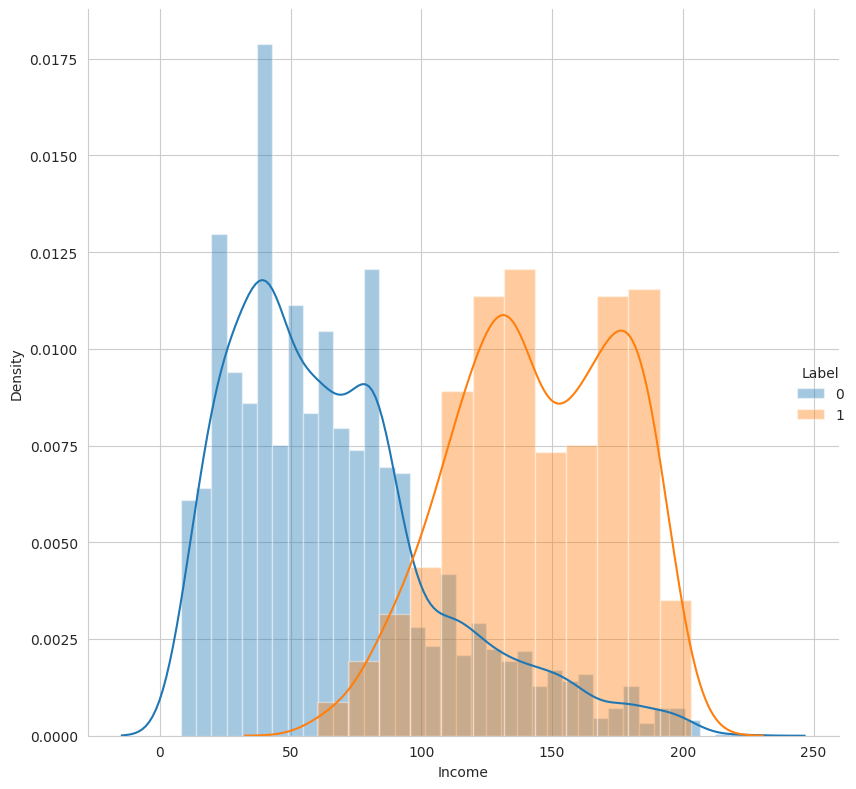

In [ ]:
sns.set_style("whitegrid")

sns.FacetGrid(df,hue='Label',height=8).map(sns.distplot,'Income').add_legend()

From the previous plot, we can see that the more you earn the higher the  probability to accept a personal loan offer is.

It seems that there is some outliers after $200.000 but let us visualize it using the Box Plot

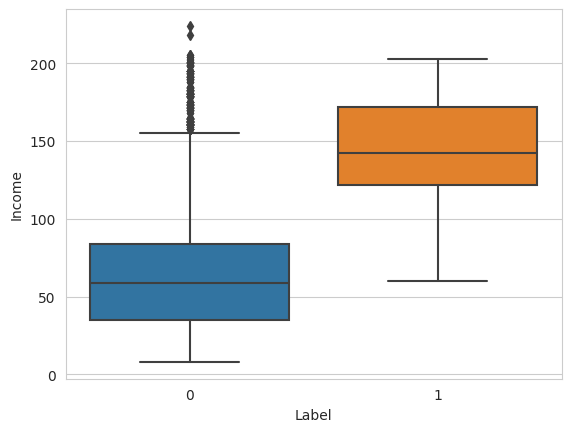

In [ ]:
ax = sns.boxplot(x="Label", y="Income", data=df)

Yes, as we thought, there is actually outliers. Another TODO is to deal with these outliers in order to avoid introducing bias or overfitting.

#### 4. ZIP Code

Idea: Convert ZIP Code to State Name, to get new feature of that ZIP Code. And then visualize the plot of feature "state".

#### 5. Family

<Axes: xlabel='Family', ylabel='count'>

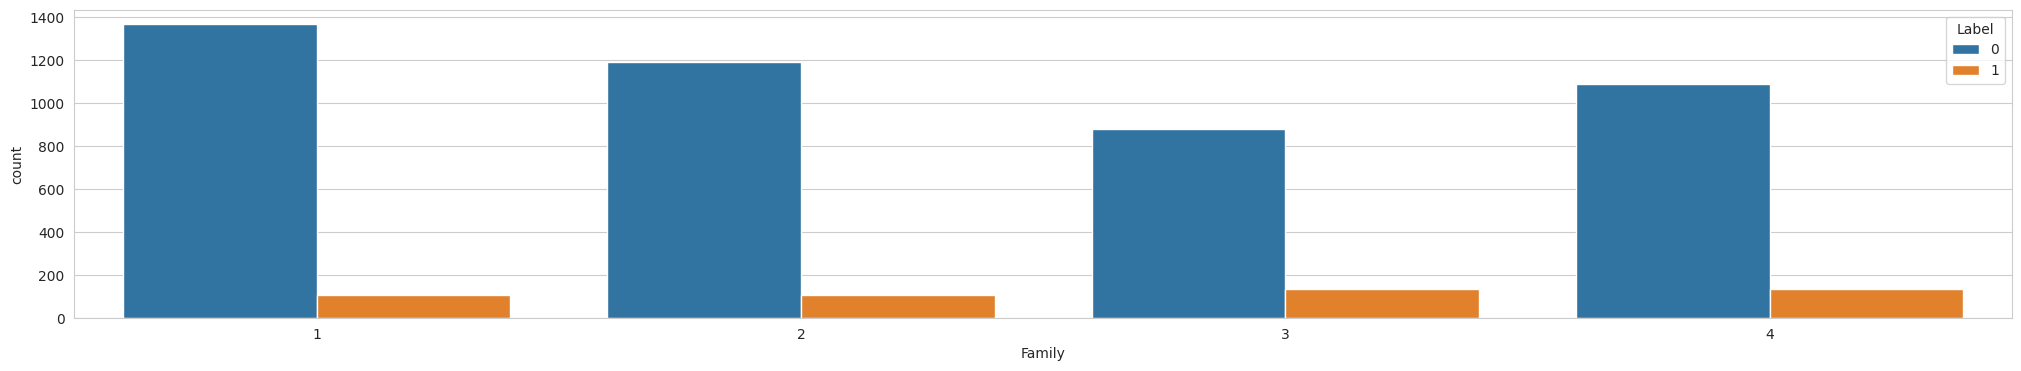

In [ ]:
sns.set_style("whitegrid")

plt.figure(figsize=(25,4))
sns.countplot(x=df["Family"], hue=df["Label"])

#### 6. CCAvg

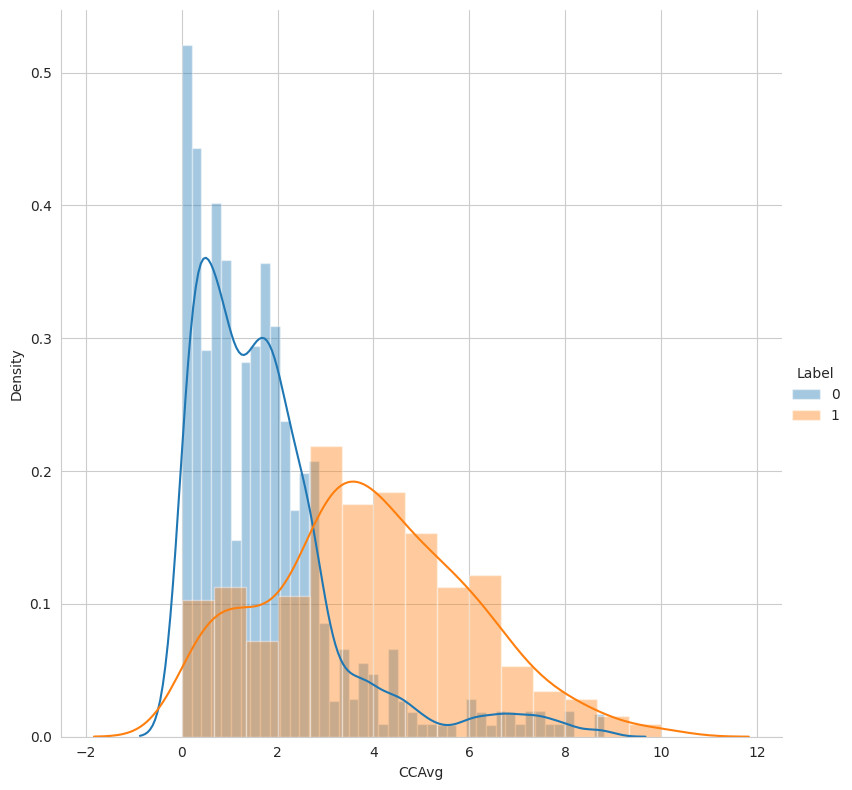

In [ ]:
sns.set_style("whitegrid")
sns.FacetGrid(df,hue='Label',height=8).map(sns.distplot,'CCAvg').add_legend()

#### 7. Education Level

Saving figure eda_education_plot


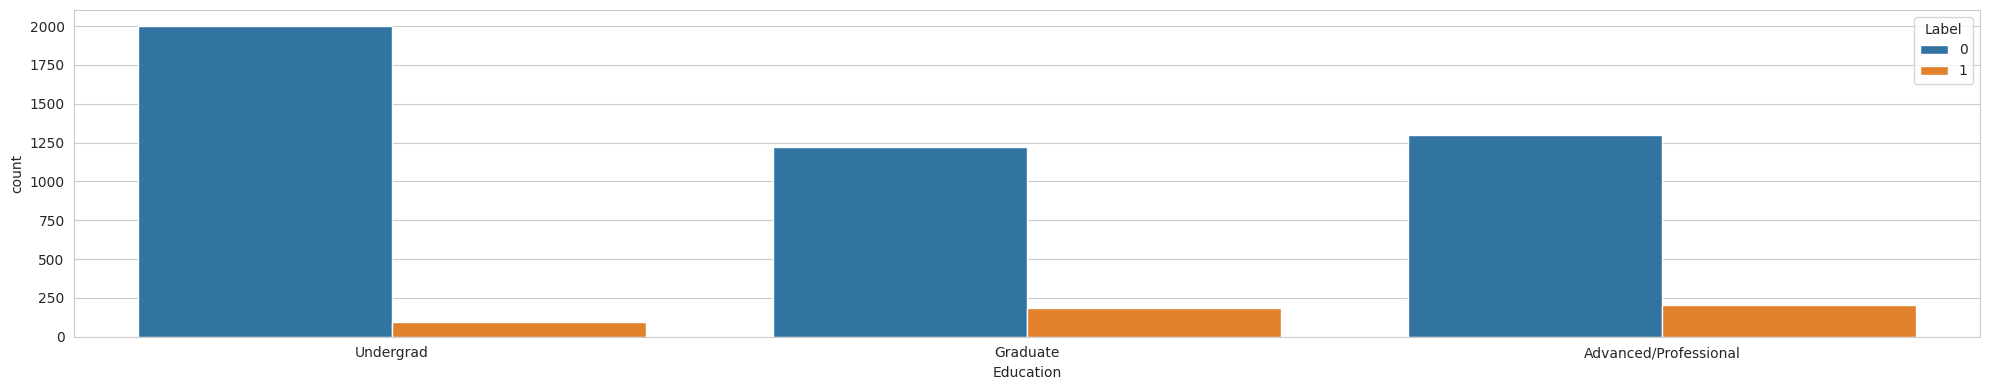

In [ ]:
sns.set_style("whitegrid")

plt.figure(figsize=(20,4))
sns.countplot(x=df["Education"], hue=df["Label"])
plt.xticks(ticks=[0,1,2], labels=['Undergrad', 'Graduate', 'Advanced/Professional'])

#### 8. Mortgage

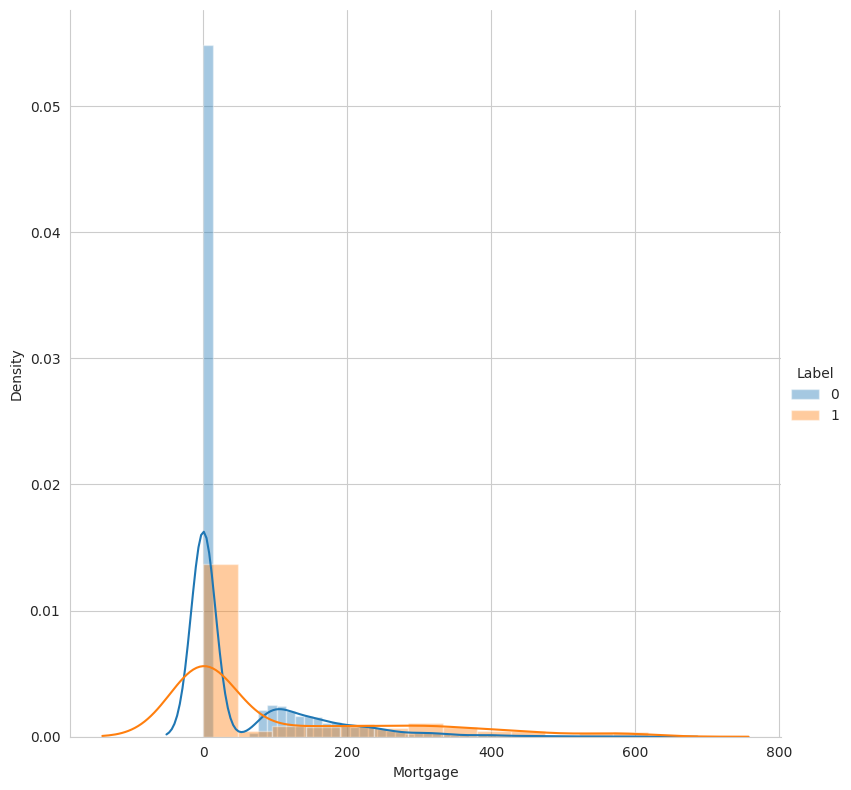

In [ ]:
sns.FacetGrid(df,hue='Label',height=8).map(sns.distplot,'Mortgage').add_legend()

Because there are so many records that has the value 0, we can split the records depending on their Montgage Value

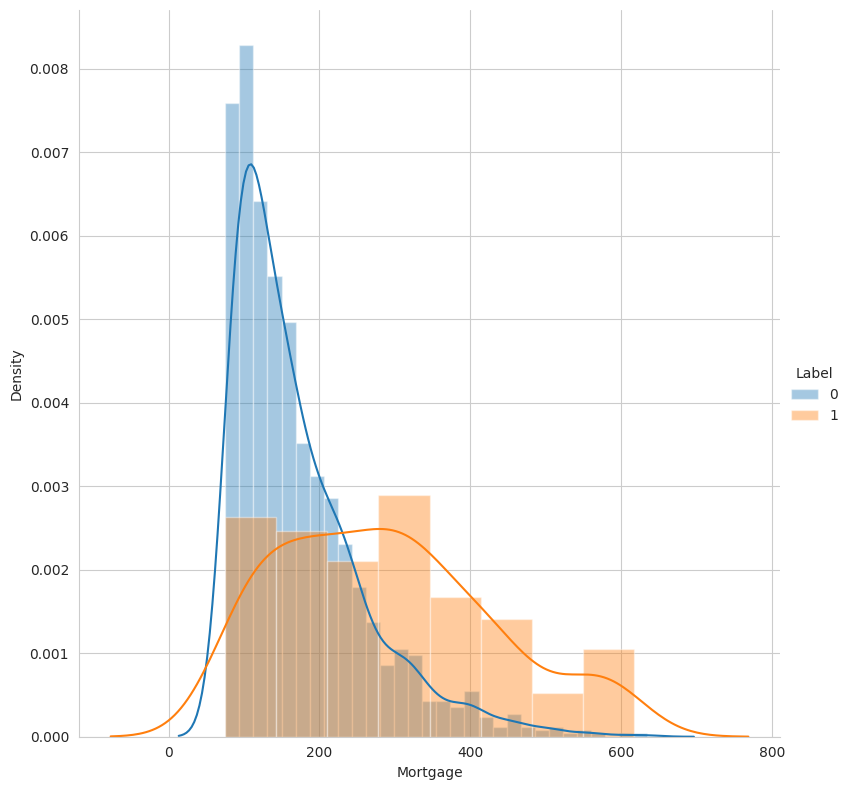

In [ ]:
# If Montgage > 0
df_mortgageover0 = df[df['Mortgage'] != 0]
sns.FacetGrid(df_mortgageover0,hue='Label',height=8).map(sns.distplot,'Mortgage').add_legend()

<Axes: xlabel='Mortgage', ylabel='count'>

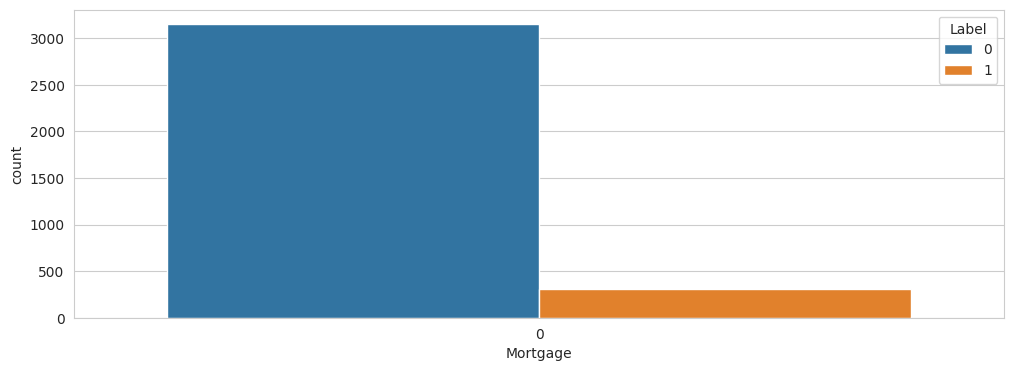

In [ ]:
# If Montgage == 0
df_mortgage0 = df[df['Mortgage'] == 0]

sns.set_style("whitegrid")

plt.figure(figsize=(12,4))
sns.countplot(x=df_mortgage0["Mortgage"], hue=df_mortgage0["Label"])

#### 9. Having Securities Account

([<matplotlib.axis.XTick at 0x7f89fd9d1780>,
 [Text(0, 0, "Don't have"), Text(1, 0, 'Have')])

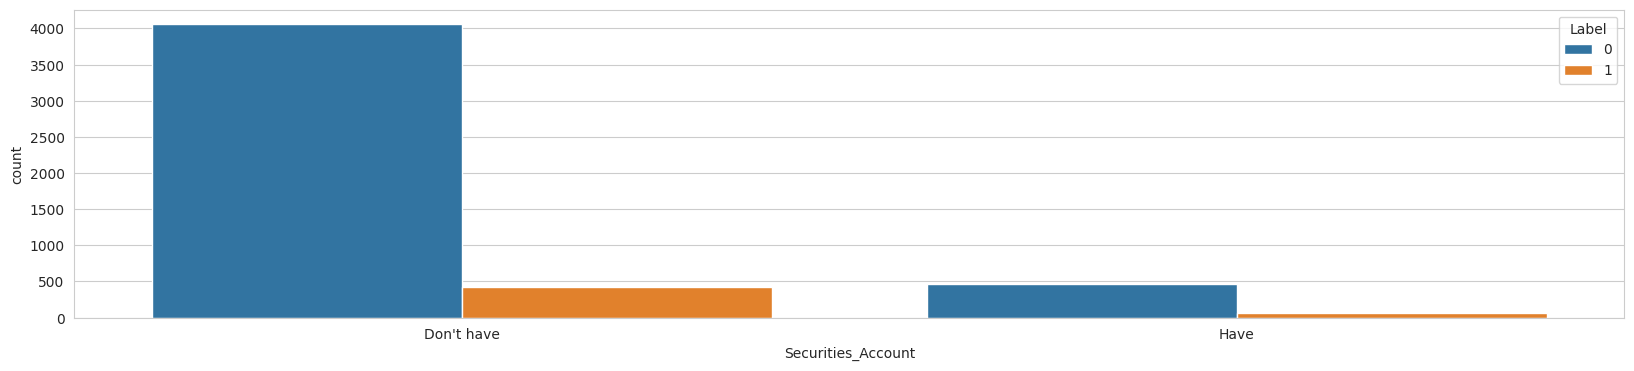

In [ ]:
sns.set_style("whitegrid")

plt.figure(figsize=(20,4))
sns.countplot(x=df["Securities_Account"], hue=df["Label"])
plt.xticks(ticks=[0,1], labels=["Don't have", 'Have'])

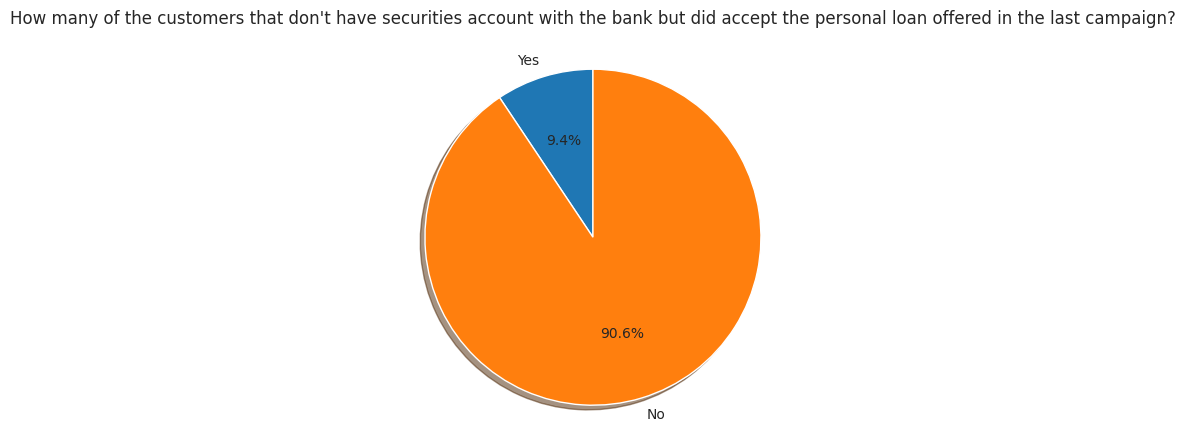

In [ ]:
df_Securities_Account_0 = df[df['Securities_Account'] == 0]


positive_count = df_Securities_Account_0[df_Securities_Account_0.Label == 1].shape[0]
negative_count = df_Securities_Account_0[df_Securities_Account_0.Label == 0].shape[0]

labels = 'Yes', 'No'
sizes = [positive_count, negative_count]
explode = (0, 0)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.title("How many of the customers that don't have securities account with the bank but did accept the personal loan offered in the last campaign?\n")
plt.show()

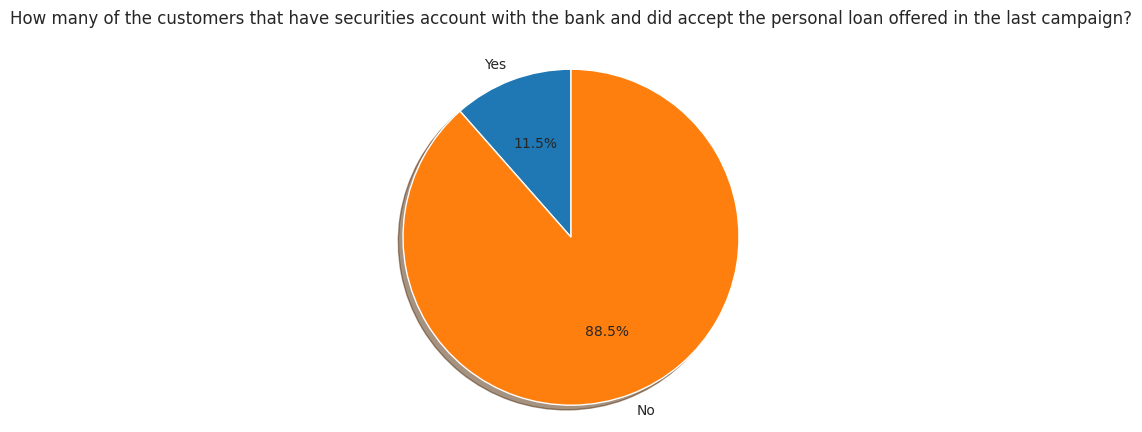

In [ ]:
df_Securities_Account_1 = df[df['Securities_Account'] == 1]


positive_count = df_Securities_Account_1[df_Securities_Account_1.Label == 1].shape[0]
negative_count = df_Securities_Account_1[df_Securities_Account_1.Label == 0].shape[0]

labels = 'Yes', 'No'
sizes = [positive_count, negative_count]
explode = (0, 0)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.title("How many of the customers that have securities account with the bank and did accept the personal loan offered in the last campaign?\n")
plt.show()

#### 10. Having CD (certificate of deposit) Account

([<matplotlib.axis.XTick at 0x7f89c19e6920>,
 [Text(0, 0, "Don't have"), Text(1, 0, 'Have')])

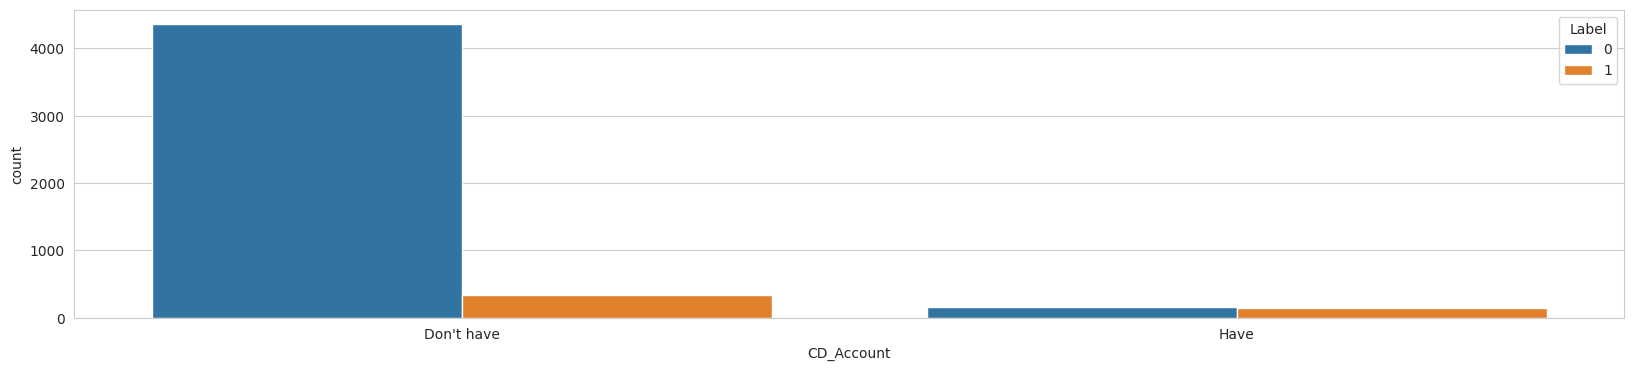

In [ ]:
sns.set_style("whitegrid")

plt.figure(figsize=(20,4))
sns.countplot(x=df["CD_Account"], hue=df["Label"])
plt.xticks(ticks=[0,1], labels=["Don't have", 'Have'])

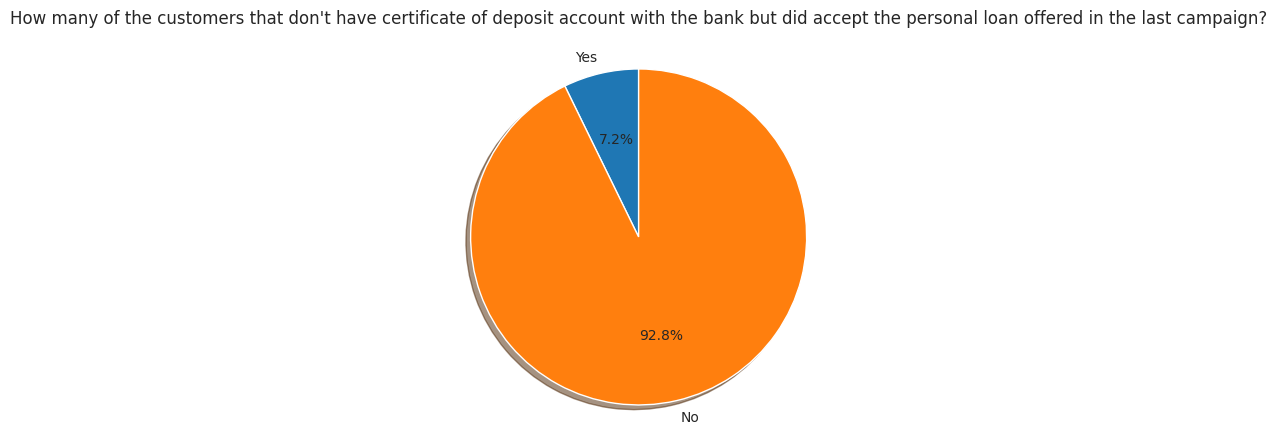

In [ ]:
df_CD_Account_0 = df[df['CD_Account'] == 0]


positive_count = df_CD_Account_0[df_CD_Account_0.Label == 1].shape[0]
negative_count = df_CD_Account_0[df_CD_Account_0.Label == 0].shape[0]

labels = 'Yes', 'No'
sizes = [positive_count, negative_count]
explode = (0, 0)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.title("How many of the customers that don't have certificate of deposit account with the bank but did accept the personal loan offered in the last campaign?\n")
plt.show()

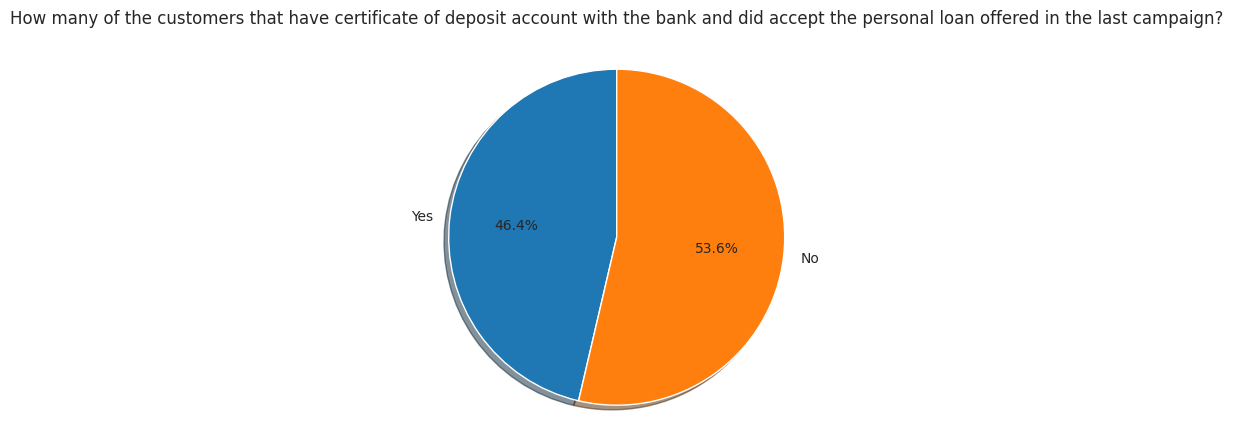

In [ ]:
df_CD_Account_1 = df[df['CD_Account'] == 1]


positive_count = df_CD_Account_1[df_CD_Account_1.Label == 1].shape[0]
negative_count = df_CD_Account_1[df_CD_Account_1.Label == 0].shape[0]

labels = 'Yes', 'No'
sizes = [positive_count, negative_count]
explode = (0, 0)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.title("How many of the customers that have certificate of deposit account with the bank and did accept the personal loan offered in the last campaign?\n")
plt.show()

#### 11. Online (Using Internet Banking Facilities)

([<matplotlib.axis.XTick at 0x7f89c1906350>,
 [Text(0, 0, "Don't use Internet Banking"),
  Text(1, 0, 'Use Internet Banking')])

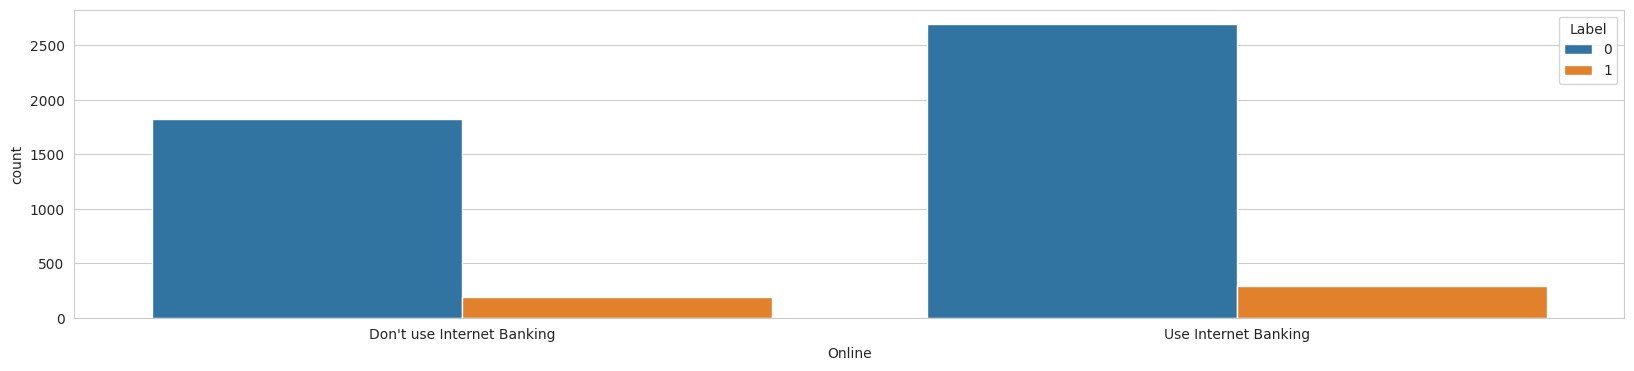

In [ ]:
sns.set_style("whitegrid")

plt.figure(figsize=(20,4))
sns.countplot(x=df["Online"], hue=df["Label"])
plt.xticks(ticks=[0,1], labels=["Don't use Internet Banking", 'Use Internet Banking'])

#### 12. CreditCard (Using a credit card issued by this Bank)

([<matplotlib.axis.XTick at 0x7f89c211e320>,
 [Text(0, 0, "Don't use Credit Card of this bank"),
  Text(1, 0, 'Use Credit Card of this bank')])

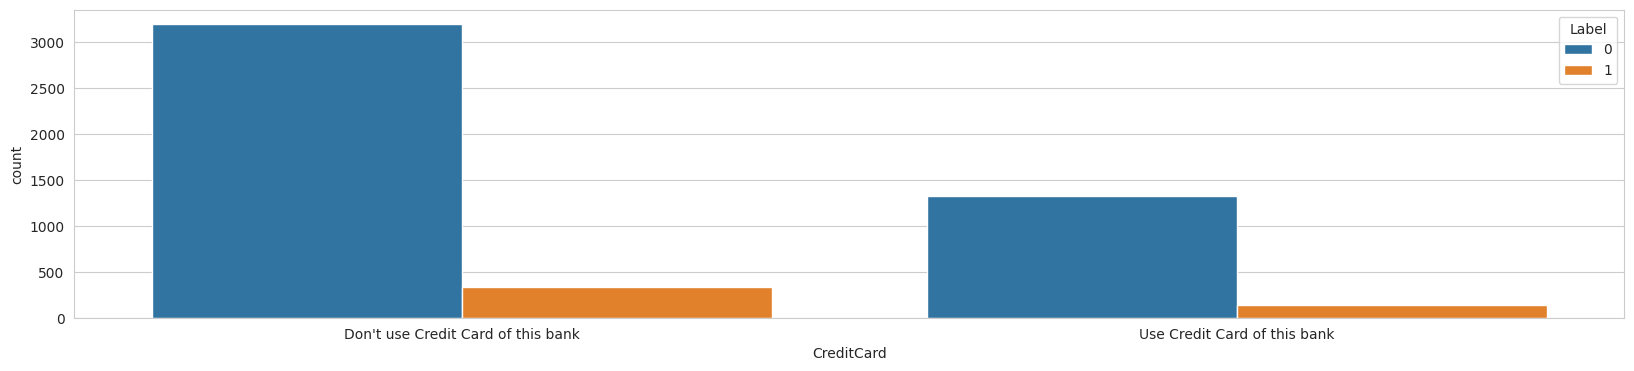

In [ ]:
sns.set_style("whitegrid")

plt.figure(figsize=(20,4))
sns.countplot(x=df["CreditCard"], hue=df["Label"])
plt.xticks(ticks=[0,1], labels=["Don't use Credit Card of this bank", 'Use Credit Card of this bank'])

# 2. Data Preparation

## 2.1 Dealing with invalid values of Feature "*Experience"*

In [ ]:
counts = df['Experience'].value_counts()
print(counts.loc[[-3, -2, -1]])

-3     4
-2    15
-1    33
Name: Experience, dtype: int64


We have 52 records where we have the values (-3, -2, -1) for the feature 'Experience'.
<br />
<br />
A simple way to deal with these values is to assign these values to zero.
<br />
<br />
An alternative aggressive way to deal with these values is to completely drop the records having these values.

In [ ]:
print("Before Manipulating the values")
counts = df['Experience'].value_counts()
print(counts.loc[[-3, -2, -1, 0]])

df.loc[df['Experience'] < 0, 'Experience'] = 0

print("After Manipulating the values")
counts = df['Experience'].value_counts()
print(counts.loc[[0]])

Before Manipulating the values
-3     4
-2    15
-1    33
 0    66
Name: Experience, dtype: int64
After Manipulating the values
0    118
Name: Experience, dtype: int64


## 2.2 Outlier Analysis

In [ ]:
numerical_features = ["Age", "CCAvg", "Experience", "Income", "Mortgage"]

# Finding Outliers
outlier_count_per_feature = {}
outlier_indexes = []
for col in numerical_features:
  q1 = df[col].quantile(0.25)
  q2 = df[col].quantile(0.5)
  q3 = df[col].quantile(0.75)

  iq = q3 - q1
  min = q1 - 1.5 * iq
  max = q3 + 1.5 * iq

  outlier_indexes.extend(df[(df[col] < min) | (df[col] > max)].index.tolist())

  outlier_len = df[(df[col] < min) | (df[col] > max)].shape[0]
  outlier_count_per_feature[col] = outlier_len
  if outlier_len > 0:
    print("Feature: ", col)
    print("+++++++++++++++++++++++++++")
    print(df[(df[col] < min) | (df[col] > max)]['Label'].value_counts())
    print("===========================")
    print("===========================")

print(outlier_count_per_feature)

Feature:  CCAvg
+++++++++++++++++++++++++++
0    199
1    125
Name: Label, dtype: int64
Feature:  Income
+++++++++++++++++++++++++++
0    54
1    42
Name: Label, dtype: int64
Feature:  Mortgage
+++++++++++++++++++++++++++
0    198
1     93
Name: Label, dtype: int64
{'Age': 0, 'CCAvg': 324, 'Experience': 0, 'Income': 96, 'Mortgage': 291}


In [ ]:
positive_count = df[df.Label == 1].shape[0]
negative_count = df[df.Label == 0].shape[0]

print("Total number of records with Label 0: ", negative_count)
print("Total number of records with Label 1: ", positive_count)

Total number of records with Label 0:  4520
Total number of records with Label 1:  480


In our case if we drop all the outliers, we will end up with a very little number of records with `Label 1`:
  - In best case:
    - All Outliers in Feature `Income` (42) are also outliers in Features `Mortgage` and `CCAvg`, and all Outliers in Feature `Mortgage` (93) are also outliers in Feature `CCAvg`. So, in this case, we anticipate that the number of all outliers with `Label 1` is 125.
  ⇒ ($480 - 125 = 355$) ~ Losing 26% of all records with `Label 1`
  - In worst case:
    - All Outliers in Feature `Income` (42) are **not** outliers in Features `Mortgage` and `CCAvg`, and all Outliers in Feature `Mortgage` (93) are **not** outliers in Feature `CCAvg`. So, in this case, we anticipate that the number of all outliers with `Label 1` is $125 + 42 + 93 = 260$.
    ⇒ ($480 - 260 = 220$) ~ Losing 54% of all records with `Label 1`

<br/>

For that, we decided to drop only the records that are outliers in the 3 features `CCAvg`, `Income` and `Mortgage` at the same time. In this way, we may drop in the worst case only 42 records with `Label 1`.


In [ ]:
outlier_indexes_unique = list(set(outlier_indexes))
print("We have", len(outlier_indexes_unique), "outliers in total.")

# Finding the number of features that a records is outlier in
outlier_count_dic = {index:outlier_indexes.count(index) for index in outlier_indexes}

# Filtering the records with number of features equal to 3 (records that are outliers in the 3 features at the same time)
outlier_indexes_intersect_dic = dict((k, v) for k, v in outlier_count_dic.items() if v >= 3)
outlier_indexes_intersect_list = list(outlier_indexes_intersect_dic.keys())

print("Indexes of outliers: ",outlier_indexes_intersect_list)
print("Count of outliers: ", (len(outlier_indexes_intersect_list)))


print("\nDistribution of outliers over label: ")
print(df.loc[outlier_indexes_intersect_list, 'Label'].value_counts())

# Droping those outliers
print("\nWe had", df.shape[0], "records before dropping the outliers.")
df.drop(outlier_indexes_intersect_list, axis=0, inplace=True)
df.reset_index(inplace=True, drop=True)
print("And now we have", df.shape[0], "records after dropping the outliers.")

We have 602 outliers in total.
Indexes of outliers:  [526, 782, 1277, 1716, 2087, 2841, 2934, 4655]
Count of outliers:  8

Distribution of outliers over label: 
0    4
1    4
Name: Label, dtype: int64

We had 5000 records before dropping the outliers.
And now we have 4992 records after dropping the outliers.


## 2.3 Converting Feature "*ZIP Code"* to a more significant Feature

In [ ]:
!pip install uszipcode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.5/121.5 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.9 MB/s eta 0:00:00
  Created wheel for atomicwrites: filename=atomicwrites-1.4.1-py2.py3-none-any.whl size=6943 sha256=8548e8a7b8e9c2fb04719add755abe6c4c1b874e90c0269d4cf6fe8c92401d8e
  Stored in directory: /root/.cache/pip/wheels/34/07/0b/33b15f68736109f72ea0bb2499521d87312b932620737447a2
Successfully built atomicwrites
  Attempting uninstall: SQLAlchemy
    Found existing installation: SQLAlchemy 2.0.10
    Uninstalling SQLAlchemy-2.0.10:
      Successfully uninstalled SQLAlchemy-2.0.10


In [ ]:
from uszipcode import SearchEngine

# Create a SearchEngine instance
search = SearchEngine()

# Define a ZIP code

state_counter_dict = {}
city_counter_dict = {}
county_counter_dict = {}

for i in range(df.shape[0]):
  zip_code = int(df.iloc[i]['ZIP_Code'])
  # print(zip_code)

  # Use the search.by_zipcode() method to get the ZIP code object
  zip_code_obj = search.by_zipcode(zip_code)
  if zip_code_obj is not None:
    zip_code_dict = zip_code_obj.to_dict()

    state = zip_code_dict["state"]
    city = zip_code_dict["major_city"]
    county = zip_code_dict["county"]

    if state_counter_dict.get(state) is not None:
      state_counter_dict[state] += 1
    else:
      state_counter_dict[state] = 1

    if city_counter_dict.get(city) is not None:
      city_counter_dict[city] += 1
    else:
      city_counter_dict[city] = 1

    if county.strip() != "":
      if county_counter_dict.get(county) is not None:
        county_counter_dict[county] += 1
      else:
        county_counter_dict[county] = 1
    else:
      if county_counter_dict.get("Unknown") is not None:
        county_counter_dict["Unknown"] += 1
      else:
        county_counter_dict["Unknown"] = 1
  else:
    if state_counter_dict.get("Unknown") is not None:
      state_counter_dict["Unknown"] += 1
    else:
      state_counter_dict["Unknown"] = 1

    if city_counter_dict.get("Unknown") is not None:
      city_counter_dict["Unknown"] += 1
    else:
      city_counter_dict["Unknown"] = 1

    if county_counter_dict.get("Unknown") is not None:
      county_counter_dict["Unknown"] += 1
    else:
      county_counter_dict["Unknown"] = 1
# print(zip_code_dict)
# Get the state abbreviation from the ZIP code object
# state = zip_code_obj.state_abbr


Download /root/.uszipcode/simple_db.sqlite from https://github.com/MacHu-GWU/uszipcode-project/releases/download/1.0.1.db/simple_db.sqlite ...
  1.00 MB downloaded ...
  2.00 MB downloaded ...
  3.00 MB downloaded ...
  4.00 MB downloaded ...
  5.00 MB downloaded ...
  6.00 MB downloaded ...
  7.00 MB downloaded ...
  8.00 MB downloaded ...
  9.00 MB downloaded ...
  10.00 MB downloaded ...
  11.00 MB downloaded ...
  Complete!


In [ ]:
state_counter_dict = sorted(state_counter_dict.items(), key=lambda x:x[1])
state_counter_dict = dict(state_counter_dict)

city_counter_dict = sorted(city_counter_dict.items(), key=lambda x:x[1])
city_counter_dict = dict(city_counter_dict)

county_counter_dict = sorted(county_counter_dict.items(), key=lambda x:x[1])
county_counter_dict = dict(county_counter_dict)

print("Number of Total States", len(state_counter_dict))

print("Number of Total Cities", len(city_counter_dict))

print("Number of Total Counties", len(county_counter_dict))

Number of Total States 3
Number of Total Cities 246
Number of Total Counties 39


In [ ]:
for k,v in state_counter_dict.items():
  print(k," State","\t- ",v,"/",df.shape[0]," Records", sep="")

AE State	- 1/4992 Records
Unknown State	- 33/4992 Records
CA State	- 4958/4992 Records


In [ ]:
for k,v in city_counter_dict.items():
  print(k," City","\t\t- ",v,"/",df.shape[0]," Records", sep="")

Apo City		- 1/4992 Records
Sierra Madre City		- 1/4992 Records
Sausalito City		- 1/4992 Records
Ladera Ranch City		- 1/4992 Records
Tahoe City City		- 1/4992 Records
Stinson Beach City		- 1/4992 Records
Porter Ranch City		- 2/4992 Records
La Palma City		- 2/4992 Records
Ukiah City		- 2/4992 Records
Antioch City		- 2/4992 Records
Half Moon Bay City		- 2/4992 Records
Oxnard City		- 2/4992 Records
Inglewood City		- 2/4992 Records
Morgan Hill City		- 2/4992 Records
Danville City		- 2/4992 Records
Ceres City		- 2/4992 Records
Alamo City		- 2/4992 Records
Moraga City		- 2/4992 Records
Ben Lomond City		- 2/4992 Records
Upland City		- 2/4992 Records
South Gate City		- 2/4992 Records
Pacific Palisades City		- 2/4992 Records
Weed City		- 2/4992 Records
Encinitas City		- 3/4992 Records
Mission Hills City		- 3/4992 Records
San Pablo City		- 3/4992 Records
Garden Grove City		- 3/4992 Records
Sanger City		- 3/4992 Records
Montebello City		- 3/4992 Records
March Air Reserve Base City		- 3/4992 Record

In [ ]:
for k,v in county_counter_dict.items():
  print(k,"\t\t- ",v,"/",df.shape[0]," Records", sep="")

Imperial County		- 3/4992 Records
Napa County		- 3/4992 Records
Merced County		- 4/4992 Records
Trinity County		- 4/4992 Records
Lake County		- 4/4992 Records
Siskiyou County		- 7/4992 Records
Tuolumne County		- 7/4992 Records
Mendocino County		- 8/4992 Records
San Joaquin County		- 13/4992 Records
San Benito County		- 14/4992 Records
Stanislaus County		- 15/4992 Records
El Dorado County		- 17/4992 Records
Shasta County		- 18/4992 Records
Butte County		- 19/4992 Records
Placer County		- 24/4992 Records
Fresno County		- 26/4992 Records
Sonoma County		- 28/4992 Records
Humboldt County		- 32/4992 Records
San Luis Obispo County		- 33/4992 Records
Solano County		- 33/4992 Records
Unknown		- 34/4992 Records
Marin County		- 54/4992 Records
Kern County		- 54/4992 Records
Riverside County		- 56/4992 Records
Santa Cruz County		- 68/4992 Records
Contra Costa County		- 85/4992 Records
San Bernardino County		- 100/4992 Records
Ventura County		- 114/4992 Records
Monterey County		- 128/4992 Records
Y

In [ ]:
df_v1 = df.copy()
df_v2 = df.copy()
df_v3 = df.copy()

Experiment 1: All Cities

In [ ]:
for i in range(df_v1.shape[0]):
  zip_code = int(df_v1.iloc[i]['ZIP_Code'])
  zip_code_obj = search.by_zipcode(zip_code)
  if zip_code_obj is not None:
    zip_code_dict = zip_code_obj.to_dict()
    city = zip_code_dict["major_city"] + " City"
  else:
    city = "Other City"

  df_v1.at[i,'ZIP_Code']= city

Experiment 2: Cities with #Records < 5 would be assigned to `"Other City"` Class

In [ ]:
for i in range(df_v2.shape[0]):
  zip_code = int(df_v2.iloc[i]['ZIP_Code'])
  zip_code_obj = search.by_zipcode(zip_code)
  if zip_code_obj is not None:
    zip_code_dict = zip_code_obj.to_dict()
    city = zip_code_dict["major_city"]
    if city_counter_dict.get(city) is None or city_counter_dict.get(city) < 5:
      city = "Other City"
    else:
      city += " City"
  else:
    city = "Other City"

  df_v2.at[i,'ZIP_Code']= city

Experiment 3: All Counties

In [ ]:
for i in range(df_v3.shape[0]):
  zip_code = int(df_v3.iloc[i]['ZIP_Code'])
  zip_code_obj = search.by_zipcode(zip_code)
  if zip_code_obj is not None:
    zip_code_dict = zip_code_obj.to_dict()
    if zip_code_dict["county"].strip() != "":
      county = zip_code_dict["county"]
    else:
      county = "Unknown County"
  else:
    county = "Unknown County"

  df_v3.at[i,'ZIP_Code']= county

In [ ]:
df_v1 = df_v1.rename(columns={'ZIP_Code': 'City'})
df_v2 = df_v2.rename(columns={'ZIP_Code': 'City'})
df_v3 = df_v3.rename(columns={'ZIP_Code': 'County'})

In [ ]:
# Outputting the first 10 Records
df_v1.head(10)

Age  Experience  Income                City  Family  CCAvg  Education  \
0   25           1      49       Pasadena City       4    1.6          1   
1   45          19      34    Los Angeles City       3    1.5          1   
2   39          15      11       Berkeley City       1    1.0          1   
3   35           9     100  San Francisco City       1    2.7          2   
4   35           8      45     Northridge City       4    1.0          2   
5   37          13      29      San Diego City       4    0.4          2   
6   53          27      72      Claremont City       2    1.5          2   
7   50          24      22       Monterey City       1    0.3          3   
8   35          10      81    Los Angeles City       3    0.6          2   
9   34           9     180           Ojai City       1    8.9          3   

   Mortgage  Label  Securities_Account  CD_Account  Online  CreditCard  
0         0      0                   1           0       0           0  
1         0      0                   1           0       0           0  
2         0      0                   0           0       0           0  
3         0      0                   0           0       0           0  
4         0      0                   0           0       0           1  
5       155      0                   0           0       1           0  
6         0      0                   0           0       1           0  
7         0      0                   0           0       0           1  
8       104      0                   0           0       1           0  
9         0      1                   0           0       0           0

In [ ]:
# Outputting the first 10 Records
df_v2.head(10)

Age  Experience  Income                City  Family  CCAvg  Education  \
0   25           1      49       Pasadena City       4    1.6          1   
1   45          19      34    Los Angeles City       3    1.5          1   
2   39          15      11       Berkeley City       1    1.0          1   
3   35           9     100  San Francisco City       1    2.7          2   
4   35           8      45     Northridge City       4    1.0          2   
5   37          13      29      San Diego City       4    0.4          2   
6   53          27      72      Claremont City       2    1.5          2   
7   50          24      22       Monterey City       1    0.3          3   
8   35          10      81    Los Angeles City       3    0.6          2   
9   34           9     180           Ojai City       1    8.9          3   

   Mortgage  Label  Securities_Account  CD_Account  Online  CreditCard  
0         0      0                   1           0       0           0  
1         0      0                   1           0       0           0  
2         0      0                   0           0       0           0  
3         0      0                   0           0       0           0  
4         0      0                   0           0       0           1  
5       155      0                   0           0       1           0  
6         0      0                   0           0       1           0  
7         0      0                   0           0       0           1  
8       104      0                   0           0       1           0  
9         0      1                   0           0       0           0

In [ ]:
# Outputting the first 10 Records
df_v3.head(10)

Age  Experience  Income                County  Family  CCAvg  Education  \
0   25           1      49    Los Angeles County       4    1.6          1   
1   45          19      34    Los Angeles County       3    1.5          1   
2   39          15      11        Alameda County       1    1.0          1   
3   35           9     100  San Francisco County       1    2.7          2   
4   35           8      45    Los Angeles County       4    1.0          2   
5   37          13      29      San Diego County       4    0.4          2   
6   53          27      72    Los Angeles County       2    1.5          2   
7   50          24      22       Monterey County       1    0.3          3   
8   35          10      81    Los Angeles County       3    0.6          2   
9   34           9     180        Ventura County       1    8.9          3   

   Mortgage  Label  Securities_Account  CD_Account  Online  CreditCard  
0         0      0                   1           0       0           0  
1         0      0                   1           0       0           0  
2         0      0                   0           0       0           0  
3         0      0                   0           0       0           0  
4         0      0                   0           0       0           1  
5       155      0                   0           0       1           0  
6         0      0                   0           0       1           0  
7         0      0                   0           0       0           1  
8       104      0                   0           0       1           0  
9         0      1                   0           0       0           0

In [ ]:
# Checking for the count of unique values for each column in the dataset
df_v1.nunique(axis=0, dropna=True) # Return Series with number of distinct observations. Can ignore NaN values. axis:0 -> row-wise, dropna=True -> ignore NaN

Age                    45
Experience             44
Income                162
City                  246
Family                  4
CCAvg                 108
Education               3
Mortgage              342
Label                   2
Securities_Account      2
CD_Account              2
Online                  2
CreditCard              2
dtype: int64

In [ ]:
# Checking for the count of unique values for each column in the dataset
df_v2.nunique(axis=0, dropna=True) # Return Series with number of distinct observations. Can ignore NaN values. axis:0 -> row-wise, dropna=True -> ignore NaN

Age                    45
Experience             44
Income                162
City                  184
Family                  4
CCAvg                 108
Education               3
Mortgage              342
Label                   2
Securities_Account      2
CD_Account              2
Online                  2
CreditCard              2
dtype: int64

In [ ]:
# Checking for the count of unique values for each column in the dataset
df_v3.nunique(axis=0, dropna=True) # Return Series with number of distinct observations. Can ignore NaN values. axis:0 -> row-wise, dropna=True -> ignore NaN

Age                    45
Experience             44
Income                162
County                 39
Family                  4
CCAvg                 108
Education               3
Mortgage              342
Label                   2
Securities_Account      2
CD_Account              2
Online                  2
CreditCard              2
dtype: int64

## 2.4 Splitting the Data

In [ ]:
predictors_v1 = [x for x in df_v1.columns if x not in ['Label']]
X_v1 = df_v1[predictors_v1]
y_v1 = df_v1[["Label"]]

predictors_v2 = [x for x in df_v2.columns if x not in ['Label']]
X_v2 = df_v2[predictors_v2]
y_v2 = df_v2[["Label"]]

predictors_v3 = [x for x in df_v3.columns if x not in ['Label']]
X_v3 = df_v3[predictors_v3]
y_v3 = df_v3[["Label"]]

In [ ]:
splitter_v1 = StratifiedShuffleSplit(train_size=0.8, test_size=0.2, random_state=42)
for train_index, test_index in splitter_v1.split(X_v1, y_v1): # 3993 training Instances & 999 Test Instances = 4992 Total Instances
  X_train_v1, X_test_v1 = X_v1.iloc[train_index], X_v1.iloc[test_index]
  y_train_v1, y_test_v1 = y_v1.iloc[train_index], y_v1.iloc[test_index]

splitter_v2 = StratifiedShuffleSplit(train_size=0.8, test_size=0.2, random_state=42)
for train_index, test_index in splitter_v2.split(X_v2, y_v2): # 3993 training Instances & 999 Test Instances = 4992 Total Instances
  X_train_v2, X_test_v2 = X_v2.iloc[train_index], X_v2.iloc[test_index]
  y_train_v2, y_test_v2 = y_v2.iloc[train_index], y_v2.iloc[test_index]

splitter_v3 = StratifiedShuffleSplit(train_size=0.8, test_size=0.2, random_state=42)
for train_index, test_index in splitter_v2.split(X_v3, y_v3): # 3993 training Instances & 999 Test Instances = 4992 Total Instances
  X_train_v3, X_test_v3 = X_v3.iloc[train_index], X_v3.iloc[test_index]
  y_train_v3, y_test_v3 = y_v3.iloc[train_index], y_v3.iloc[test_index]

In [ ]:
print(X_train_v1.shape)
print(y_train_v1.shape)
print(X_test_v1.shape)
print(y_test_v1.shape)

(3993, 12)
(3993, 1)
(999, 12)
(999, 1)


In [ ]:
print(X_train_v2.shape)
print(y_train_v2.shape)
print(X_test_v2.shape)
print(y_test_v2.shape)

(3993, 12)
(3993, 1)
(999, 12)
(999, 1)


In [ ]:
print(X_train_v3.shape)
print(y_train_v3.shape)
print(X_test_v3.shape)
print(y_test_v3.shape)

(3993, 12)
(3993, 1)
(999, 12)
(999, 1)


## 2.5 Scaling the Features

In [ ]:
# Numerical Features are ["Age", "Income", "Experience", "Family", "CCAvg", "Mortgage"]
# Ordinal Categorical Feature is ["Education"]
# Nominal Categorical Features is ["City"] which generated from "ZIP_Code"
# Binary Features are ["Securities_Account", "CD_Account", "Online", "CreditCard"]


cities_v1 = df_v1['City'].unique().tolist()
cities_v2 = df_v2['City'].unique().tolist()
counties_v3 = df_v3['County'].unique().tolist()

education_encoder = StandardScaler()
age_encoder = StandardScaler()
income_encoder = StandardScaler()
experience_encoder = StandardScaler()
family_encoder = StandardScaler()
ccavg_encoder = StandardScaler()
mortgage_encoder = StandardScaler()

city_encoder_v1 = Pipeline([
    ("cat", OrdinalEncoder(categories=[cities_v1])),
    ('std_scaler', StandardScaler())
])

city_encoder_v2 = Pipeline([
    ("cat", OrdinalEncoder(categories=[cities_v2])),
    ('std_scaler', StandardScaler())
])

county_encoder_v3 = Pipeline([
    ("cat", OrdinalEncoder(categories=[counties_v3])),
    ('std_scaler', StandardScaler())
])

In [ ]:
scaling_pipeline_v1 = ColumnTransformer(
  transformers=[
    ("Age", age_encoder, ["Age"]),
    ("Experience", experience_encoder, ["Experience"]),
    ("Income", income_encoder, ["Income"]),
    ("City", city_encoder_v1, ["City"]),
    ("Family", family_encoder, ["Family"]),
    ("CCAvg", ccavg_encoder, ["CCAvg"]),
    ("Education", education_encoder, ["Education"]),
    ("Mortgage", mortgage_encoder, ["Mortgage"]),
    ("Securities_Account", "passthrough", ["Securities_Account"]),
    ("CD_Account", "passthrough", ["CD_Account"]),
    ("Online", "passthrough", ["Online"]),
    ("CreditCard", "passthrough", ["CreditCard"]),
  ]
)

scaling_pipeline_v2 = ColumnTransformer(
  transformers=[
    ("Age", age_encoder, ["Age"]),
    ("Experience", experience_encoder, ["Experience"]),
    ("Income", income_encoder, ["Income"]),
    ("City", city_encoder_v2, ["City"]),
    ("Family", family_encoder, ["Family"]),
    ("CCAvg", ccavg_encoder, ["CCAvg"]),
    ("Education", education_encoder, ["Education"]),
    ("Mortgage", mortgage_encoder, ["Mortgage"]),
    ("Securities_Account", "passthrough", ["Securities_Account"]),
    ("CD_Account", "passthrough", ["CD_Account"]),
    ("Online", "passthrough", ["Online"]),
    ("CreditCard", "passthrough", ["CreditCard"]),
  ]
)


scaling_pipeline_v3 = ColumnTransformer(
  transformers=[
    ("Age", age_encoder, ["Age"]),
    ("Experience", experience_encoder, ["Experience"]),
    ("Income", income_encoder, ["Income"]),
    ("County", county_encoder_v3, ["County"]),
    ("Family", family_encoder, ["Family"]),
    ("CCAvg", ccavg_encoder, ["CCAvg"]),
    ("Education", education_encoder, ["Education"]),
    ("Mortgage", mortgage_encoder, ["Mortgage"]),
    ("Securities_Account", "passthrough", ["Securities_Account"]),
    ("CD_Account", "passthrough", ["CD_Account"]),
    ("Online", "passthrough", ["Online"]),
    ("CreditCard", "passthrough", ["CreditCard"]),
  ]
)

scaling the training set the data

In [ ]:
X_scaled_train_v1 = scaling_pipeline_v1.fit_transform(X_train_v1)
X_scaled_train_v2 = scaling_pipeline_v2.fit_transform(X_train_v2)
X_scaled_train_v3 = scaling_pipeline_v3.fit_transform(X_train_v3)

In [ ]:
X_scaled_test_v1 = scaling_pipeline_v1.fit_transform(X_test_v1)
X_scaled_test_v2 = scaling_pipeline_v2.fit_transform(X_test_v2)
X_scaled_test_v3 = scaling_pipeline_v3.fit_transform(X_test_v3)

In [ ]:
X_train_v1.iloc[0]

Age                                 27
Experience                           2
Income                              55
City                  Chula Vista City
Family                               4
CCAvg                              1.7
Education                            2
Mortgage                             0
Securities_Account                   0
CD_Account                           0
Online                               1
CreditCard                           0
Name: 607, dtype: object

In [ ]:
X_scaled_train_v1[0]

array([-1.6054593 , -1.58862186, -0.40714081,  1.67582229,  1.4034452 ,
       -0.12117215,  0.15093615, -0.54989241,  0.        ,  0.        ,
        1.        ,  0.        ])

In [ ]:
education_names = ["Education"]
age_names = ["Age"]
income_names = ["Income"]
experience_names = ["Experience"]
family_names = ["Family"]
ccavg_names = ["CCAvg"]
mortgage_names = ["Mortgage"]
securities_Account_names = ["Securities_Account"]
cd_Account_names = ["CD_Account"]
online_names = ["Online"]
creditCard_name = ["CreditCard"]
city_names = ["City"]

final_feature_names_v1 = np.concatenate((
    age_names,
    experience_names,
    income_names,
    city_names,
    family_names,
    ccavg_names,
    education_names,
    mortgage_names,
    securities_Account_names,
    cd_Account_names,
    online_names,
    creditCard_name,
), axis=0)

final_feature_names_v1

array(['Age', 'Experience', 'Income', 'City', 'Family', 'CCAvg',
       'Education', 'Mortgage', 'Securities_Account', 'CD_Account',
       'Online', 'CreditCard'], dtype='<U18')

In [ ]:
education_names = ["Education"]
age_names = ["Age"]
income_names = ["Income"]
experience_names = ["Experience"]
family_names = ["Family"]
ccavg_names = ["CCAvg"]
mortgage_names = ["Mortgage"]
securities_Account_names = ["Securities_Account"]
cd_Account_names = ["CD_Account"]
online_names = ["Online"]
creditCard_name = ["CreditCard"]
city_names = ["County"]

final_feature_names_v3 = np.concatenate((
    age_names,
    experience_names,
    income_names,
    city_names,
    family_names,
    ccavg_names,
    education_names,
    mortgage_names,
    securities_Account_names,
    cd_Account_names,
    online_names,
    creditCard_name,
), axis=0)

final_feature_names_v3

array(['Age', 'Experience', 'Income', 'County', 'Family', 'CCAvg',
       'Education', 'Mortgage', 'Securities_Account', 'CD_Account',
       'Online', 'CreditCard'], dtype='<U18')

In [ ]:
# X_scaled_train_v1_df = pd.DataFrame(X_scaled_train_v1, columns=final_feature_names)
# X_scaled_train_v2_df = pd.DataFrame(X_scaled_train_v2, columns=final_feature_names)

# X_scaled_test_v1_df = pd.DataFrame(X_scaled_test_v1, columns=final_feature_names)
# X_scaled_test_v2_df = pd.DataFrame(X_scaled_test_v2, columns=final_feature_names)

In [ ]:
# X_scaled_train_v1_df.head()

## 2.6 Handling Imbalance

In [ ]:
print('Original Class Distribution of the Training Dataset For Experiment 1')
print(y_train_v1['Label'].value_counts())
print("====================================")
print('Original Class Distribution of the Training Dataset For Experiment 2')
print(y_train_v2['Label'].value_counts())
print("====================================")
print('Original Class Distribution of the Training Dataset For Experiment 3')
print(y_train_v3['Label'].value_counts())

Original Class Distribution of the Training Dataset For Experiment 1
0    3612
1     381
Name: Label, dtype: int64
Original Class Distribution of the Training Dataset For Experiment 2
0    3612
1     381
Name: Label, dtype: int64
Original Class Distribution of the Training Dataset For Experiment 3
0    3612
1     381
Name: Label, dtype: int64


In [ ]:
# Applying Synthetic Minority Over-sampling Technique (SMOTE) for oversampling
oversampler = SMOTE(k_neighbors=5, sampling_strategy=0.3,  random_state=42)

# Applying One Sided Selection for undersampling
undersampler = OneSidedSelection(n_neighbors=1, n_seeds_S=30,  random_state=42)

# Creating Resampling Pipeline
steps = [('oversampler', oversampler), ('undersampler', undersampler)]
resampling_pipeline = imPipeline(steps=steps)

In [ ]:
X_resampled_train_v1, y_resampled_train_v1 = resampling_pipeline.fit_resample(X_scaled_train_v1, y_train_v1)
X_resampled_train_v2, y_resampled_train_v2 = resampling_pipeline.fit_resample(X_scaled_train_v2, y_train_v2)
X_resampled_train_v3, y_resampled_train_v3 = resampling_pipeline.fit_resample(X_scaled_train_v3, y_train_v3)

<details>
  <summary>For More Details on SMOTE and OneSidedSelection Arguments, Click here</summary>
  <div>
    ⇒ SMOTE(k_neighbors=5, sampling_strategy=0.3, random_state=42)
    <ul>
      <li>
        k_neighbors=5 specifies the number of nearest neighbors to be used for synthetic sample generation. It determines the similarity between existing samples and the ones to be created.
      </li>
      <li>
        sampling_strategy=0.3 sets the desired ratio of the number of minority class instances to the number of majority class instances after oversampling. In this case, it aims to increase the minority class instances to 30% of the majority class instances.
      </li>
    </ul>
  </div>
  <div>
    ⇒ OneSidedSelection(n_neighbors=1, n_seeds_S=30, random_state=42)
    <ul>
      <li>
        n_neighbors=1 specifies the number of nearest neighbors used to determine whether a sample is considered noisy and removed from the majority class.
      </li>
      <li>
        n_seeds_S=30 determines the number of seed samples to be selected from the majority class for comparison with the minority class. Samples that are too dissimilar from the minority class are removed.
      </li>
    </ul>
  </div>
</details>

In [ ]:
print('Original Class Distribution of the Training Dataset For Experiment 1')
print(y_resampled_train_v1['Label'].value_counts())
print("====================================")
print('Original Class Distribution of the Training Dataset For Experiment 2')
print(y_resampled_train_v2['Label'].value_counts())
print("====================================")
print('Original Class Distribution of the Training Dataset For Experiment 3')
print(y_resampled_train_v3['Label'].value_counts())

Original Class Distribution of the Training Dataset For Experiment 1
0    1737
1    1083
Name: Label, dtype: int64
Original Class Distribution of the Training Dataset For Experiment 2
0    1738
1    1083
Name: Label, dtype: int64
Original Class Distribution of the Training Dataset For Experiment 3
0    1722
1    1083
Name: Label, dtype: int64


## 2.7 Dimensionality Reduction

### 2.7.1 Principal Component Analysis (PCA)

In [ ]:
pca_v1 = PCA(n_components=0.95)
X_resampled_train_pca_v1 = pca_v1.fit_transform(X_resampled_train_v1)

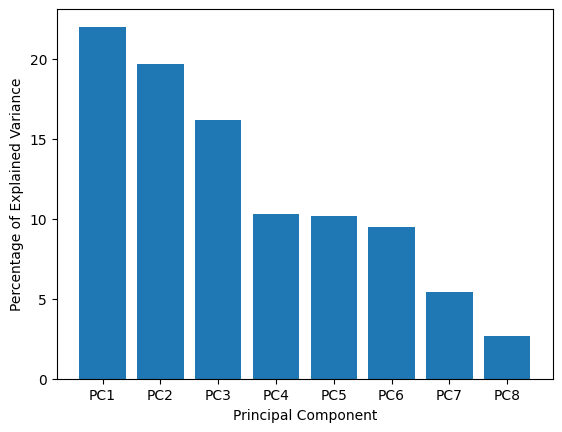

In [ ]:
per_var_v1 = np.round(pca_v1.explained_variance_ratio_* 100, decimals = 1)
labels = ['PC'+ str(x) for x in range(1, len(per_var_v1)+1)]
plt.bar(x = range(1, len(per_var_v1)+1), height = per_var_v1, tick_label=labels)
plt.xlabel('Principal Component')
plt.ylabel('Percentage of Explained Variance')
plt.show()

In [ ]:
X_scaled_test_pca_v1 = pca_v1.transform(X_scaled_test_v1)

In [ ]:
print("1. Experiment: Before PCA we had {} Features. But after applying PCA we ended up with only {} Features that describes 95% of our data. This means that we got rid of {} unimportant Features.".format(len(df_v1.columns)-1, len(per_var_v1), len(df_v1.columns)-len(per_var_v1)-1))

1. Experiment: Before PCA we had 12 Features. But after applying PCA we ended up with only 8 Features that describes 95% of our data. This means that we got rid of 4 unimportant Features.


In [ ]:
pca_v2 = PCA(n_components=0.95)
X_resampled_train_pca_v2 = pca_v2.fit_transform(X_resampled_train_v2)

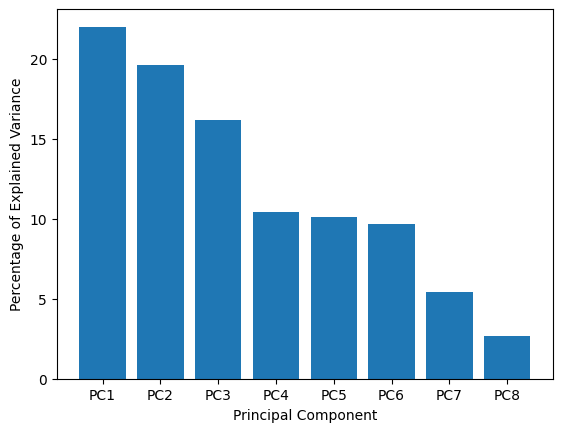

In [ ]:
per_var_v2 = np.round(pca_v2.explained_variance_ratio_* 100, decimals = 1)
labels = ['PC'+ str(x) for x in range(1, len(per_var_v2)+1)]
plt.bar(x = range(1, len(per_var_v2)+1), height = per_var_v2, tick_label=labels)
plt.xlabel('Principal Component')
plt.ylabel('Percentage of Explained Variance')
plt.show()

In [ ]:
X_scaled_test_pca_v2 = pca_v2.transform(X_scaled_test_v2)

In [ ]:
print("2. Experiment: Before PCA we had {} Features. But after applying PCA we ended up with only {} Features that describes 95% of our data. This means that we got rid of {} unimportant Features.".format(len(df_v2.columns)-1, len(per_var_v2), len(df_v2.columns)-len(per_var_v2)-1))

2. Experiment: Before PCA we had 12 Features. But after applying PCA we ended up with only 8 Features that describes 95% of our data. This means that we got rid of 4 unimportant Features.


In [ ]:
pca_v3 = PCA(n_components=0.95)
X_resampled_train_pca_v3 = pca_v3.fit_transform(X_resampled_train_v3)

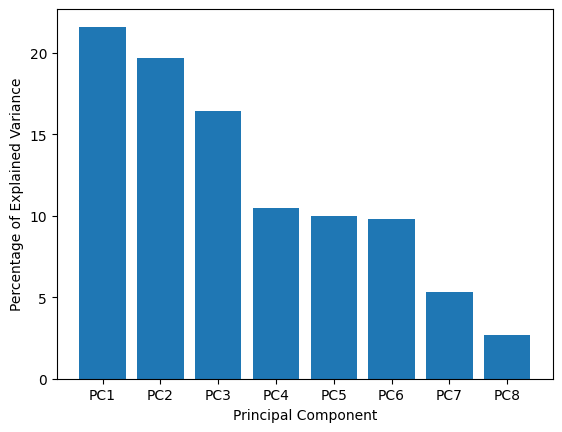

In [ ]:
per_var_v3 = np.round(pca_v3.explained_variance_ratio_* 100, decimals = 1)
labels = ['PC'+ str(x) for x in range(1, len(per_var_v3)+1)]
plt.bar(x = range(1, len(per_var_v3)+1), height = per_var_v3, tick_label=labels)
plt.xlabel('Principal Component')
plt.ylabel('Percentage of Explained Variance')
plt.show()

In [ ]:
X_scaled_test_pca_v3 = pca_v3.transform(X_scaled_test_v3)

In [ ]:
print("3. Experiment: Before PCA we had {} Features. But after applying PCA we ended up with only {} Features that describes 95% of our data. This means that we got rid of {} unimportant Features.".format(len(df_v3.columns)-1, len(per_var_v3), len(df_v3.columns)-len(per_var_v3)-1))

3. Experiment: Before PCA we had 12 Features. But after applying PCA we ended up with only 8 Features that describes 95% of our data. This means that we got rid of 4 unimportant Features.


## 2.8 Summary

We have 3 different Experiments:
  - Experiment 1: Having all Cities instead of ZIP Codes
  - Experiment 2: Having Cities with #Records >= 5 (Cities with #Records < 5 would be assigned to `"Other City"` Class)
  - Experiment 3: Having all Counties instead of ZIP Codes

We have 9 different Datasets:
  - 1: Experiment 1 - Original (Without Resampling)
  - 2: Experiment 1 - Resampling without PCA
  - 3: Experiment 1 - Resampling with PCA


  - 4: Experiment 2 - Original (Without Resampling)
  - 5: Experiment 2 - Resampling without PCA
  - 6: Experiment 2 - Resampling with PCA


  - 7: Experiment 3 - Original (Without Resampling)
  - 8: Experiment 3 - Resampling without PCA
  - 9: Experiment 3 - Resampling with PCA

In [ ]:
print("Experiment 1 - Original (Without Resampling)   - Training Set Shape:", X_scaled_train_v1.shape)          # y_train_v1
print("Experiment 1 - Resampling without PCA          - Training Set Shape:", X_resampled_train_v1.shape)       # y_resampled_train_v1
print("Experiment 1 - Resampling with PCA             - Training Set Shape:", X_resampled_train_pca_v1.shape)   # y_resampled_train_v1
print()
print("Experiment 2 - Original (Without Resampling)   - Training Set Shape:", X_scaled_train_v2.shape)          # y_train_v2
print("Experiment 2 - Resampling without PCA          - Training Set Shape:", X_resampled_train_v2.shape)       # y_resampled_train_v2
print("Experiment 2 - Resampling with PCA             - Training Set Shape:", X_resampled_train_pca_v2.shape)   # y_resampled_train_v2
print()
print("Experiment 3 - Original (Without Resampling)   - Training Set Shape:", X_scaled_train_v3.shape)          # y_train_v3
print("Experiment 3 - Resampling without PCA          - Training Set Shape:", X_resampled_train_v3.shape)       # y_resampled_train_v3
print("Experiment 3 - Resampling with PCA             - Training Set Shape:", X_resampled_train_pca_v3.shape)   # y_resampled_train_v3

Experiment 1 - Original (Without Resampling)   - Training Set Shape: (3993, 12)
Experiment 1 - Resampling without PCA          - Training Set Shape: (2820, 12)
Experiment 1 - Resampling with PCA             - Training Set Shape: (2820, 8)

Experiment 2 - Original (Without Resampling)   - Training Set Shape: (3993, 12)
Experiment 2 - Resampling without PCA          - Training Set Shape: (2821, 12)
Experiment 2 - Resampling with PCA             - Training Set Shape: (2821, 8)

Experiment 3 - Original (Without Resampling)   - Training Set Shape: (3993, 12)
Experiment 3 - Resampling without PCA          - Training Set Shape: (2805, 12)
Experiment 3 - Resampling with PCA             - Training Set Shape: (2805, 8)


In [ ]:
print("Experiment 1 - Original (Without Resampling)   - Test Set Shape:", X_scaled_test_v1.shape)       # y_test_v1
print("Experiment 1 - Resampling without PCA          - Test Set Shape:", X_scaled_test_v1.shape)       # y_test_v1
print("Experiment 1 - Resampling with PCA             - Test Set Shape:", X_scaled_test_pca_v1.shape)   # y_test_v1
print()
print("Experiment 2 - Original (Without Resampling)   - Test Set Shape:", X_scaled_test_v2.shape)       # y_test_v2
print("Experiment 2 - Resampling without PCA          - Test Set Shape:", X_scaled_test_v2.shape)       # y_test_v2
print("Experiment 2 - Resampling with PCA             - Test Set Shape:", X_scaled_test_pca_v2.shape)   # y_test_v2
print()
print("Experiment 3 - Original (Without Resampling)   - Test Set Shape:", X_scaled_test_v3.shape)       # y_test_v3
print("Experiment 3 - Resampling without PCA          - Test Set Shape:", X_scaled_test_v3.shape)       # y_test_v3
print("Experiment 3 - Resampling with PCA             - Test Set Shape:", X_scaled_test_pca_v3.shape)   # y_test_v3

Experiment 1 - Original (Without Resampling)   - Test Set Shape: (999, 12)
Experiment 1 - Resampling without PCA          - Test Set Shape: (999, 12)
Experiment 1 - Resampling with PCA             - Test Set Shape: (999, 8)

Experiment 2 - Original (Without Resampling)   - Test Set Shape: (999, 12)
Experiment 2 - Resampling without PCA          - Test Set Shape: (999, 12)
Experiment 2 - Resampling with PCA             - Test Set Shape: (999, 8)

Experiment 3 - Original (Without Resampling)   - Test Set Shape: (999, 12)
Experiment 3 - Resampling without PCA          - Test Set Shape: (999, 12)
Experiment 3 - Resampling with PCA             - Test Set Shape: (999, 8)


In [ ]:
print(y_train_v1.shape)
print(y_resampled_train_v1.shape)
print(y_train_v2.shape)
print(y_resampled_train_v2.shape)
print(y_train_v3.shape)
print(y_resampled_train_v3.shape)
print(y_test_v1.shape)
print(y_test_v2.shape)
print(y_test_v3.shape)

(3993, 1)
(2820, 1)
(3993, 1)
(2821, 1)
(3993, 1)
(2805, 1)
(999, 1)
(999, 1)
(999, 1)


# 3. Modeling

## 3.1 Training: Experiment 1

In [ ]:
print("Experiment 1 - Original (Without Resampling)   - Training Set Shape:", X_scaled_train_v1.shape)          # y_train_v1
print(y_train_v1.shape)
print("Experiment 1 - Resampling without PCA          - Training Set Shape:", X_resampled_train_v1.shape)       # y_resampled_train_v1
print(y_resampled_train_v1.shape)
print("Experiment 1 - Resampling with PCA             - Training Set Shape:", X_resampled_train_pca_v1.shape)   # y_resampled_train_v1
print(y_resampled_train_v1.shape)

Experiment 1 - Original (Without Resampling)   - Training Set Shape: (3993, 12)
(3993, 1)
Experiment 1 - Resampling without PCA          - Training Set Shape: (2820, 12)
(2820, 1)
Experiment 1 - Resampling with PCA             - Training Set Shape: (2820, 8)
(2820, 1)


In [ ]:
exp1_training_data = [X_scaled_train_v1, X_resampled_train_v1, X_resampled_train_pca_v1]
exp1_training_labels = [y_train_v1, y_resampled_train_v1, y_resampled_train_v1]
exp1_training_names = ["Original (Without Resampling)", "Resampling without PCA", "Resampling with PCA"]

### 3.1.1 Logistic Regression

In [ ]:
log_reg_accuracy = []
log_reg_precision = []
log_reg_recall = []
log_reg_f1 = []
log_reg_auc = []

for i in range(len(exp1_training_data)):
  log_reg = LogisticRegression(random_state=42, n_jobs=-1)
  log_reg.fit(exp1_training_data[i], exp1_training_labels[i])

  log_reg_auc.append(cross_val_score(log_reg, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="roc_auc", n_jobs=4).mean())
  log_reg_accuracy.append(cross_val_score(log_reg, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="accuracy", n_jobs=4).mean())
  log_reg_precision.append(cross_val_score(log_reg, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="precision", n_jobs=4).mean())
  log_reg_recall.append(cross_val_score(log_reg, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="recall", n_jobs=4).mean())
  log_reg_f1.append(cross_val_score(log_reg, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="f1", n_jobs=4).mean())

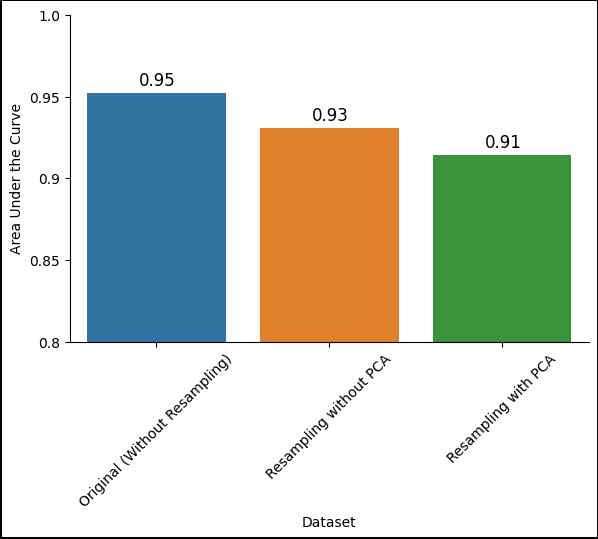

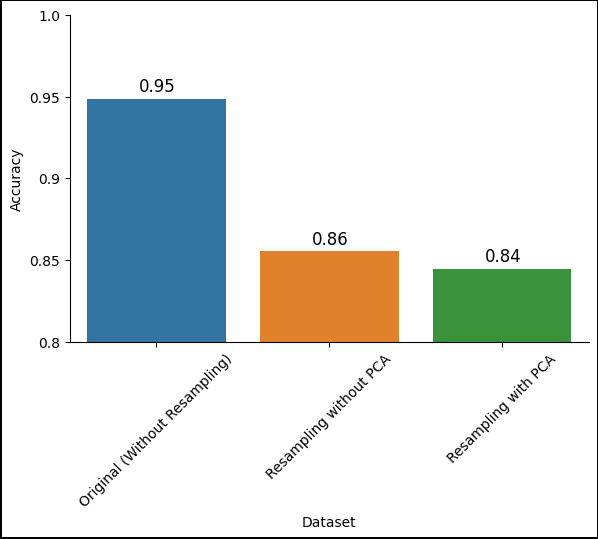

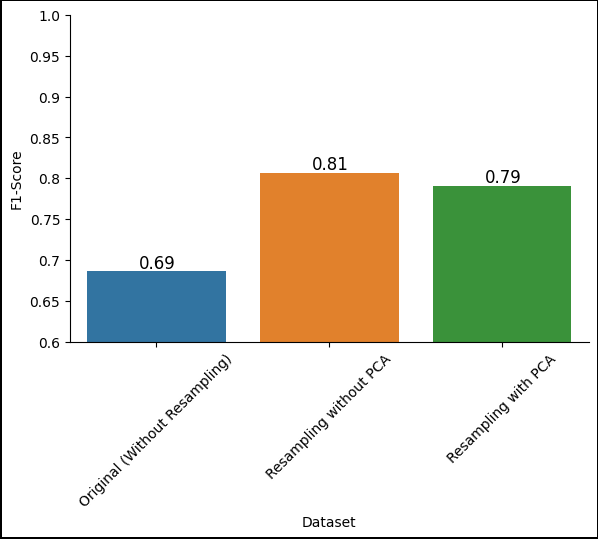

In [ ]:
plot_catplot_for_training_metrics(exp1_training_names, log_reg_auc, "Area Under the Curve", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp1_training_names, log_reg_accuracy, "Accuracy", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp1_training_names, log_reg_f1, "F1-Score", yticks_interval_space=0.05, yticks_limits=(0.6,1))

### 3.1.2 Support Vector Machine Classifier (SVC)

In [ ]:
svc_accuracy = []
svc_precision = []
svc_recall = []
svc_f1 = []
svc_auc = []

for i in range(len(exp1_training_data)):
  svc = LinearSVC(random_state=42)
  svc.fit(exp1_training_data[i], exp1_training_labels[i])

  svc_auc.append(cross_val_score(svc, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="roc_auc", n_jobs=4).mean())
  svc_accuracy.append(cross_val_score(svc, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="accuracy", n_jobs=4).mean())
  svc_precision.append(cross_val_score(svc, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="precision", n_jobs=4).mean())
  svc_recall.append(cross_val_score(svc, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="recall", n_jobs=4).mean())
  svc_f1.append(cross_val_score(svc, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="f1", n_jobs=4).mean())

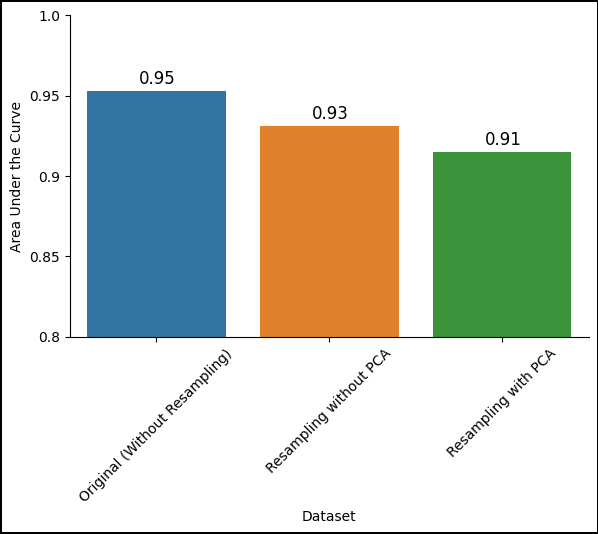

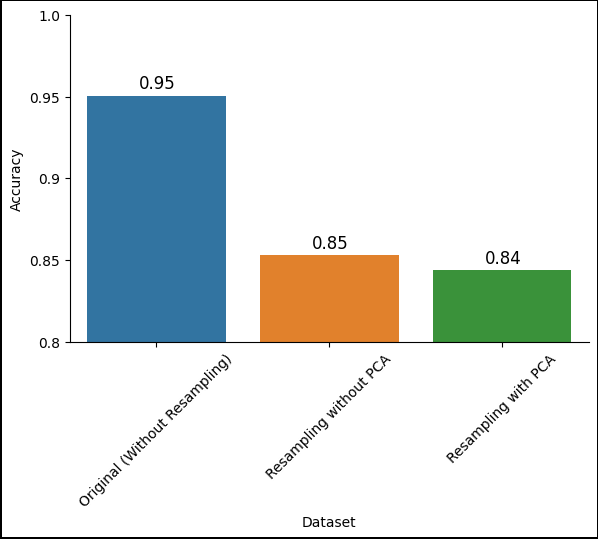

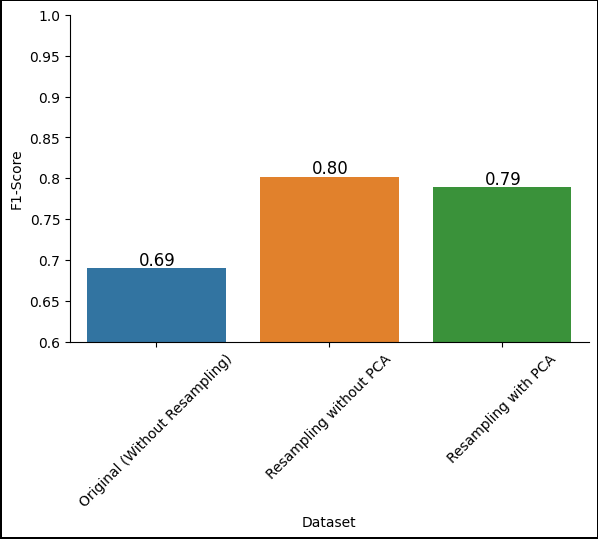

In [ ]:
plot_catplot_for_training_metrics(exp1_training_names, svc_auc, "Area Under the Curve", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp1_training_names, svc_accuracy, "Accuracy", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp1_training_names, svc_f1, "F1-Score", yticks_interval_space=0.05, yticks_limits=(0.6,1))

### 3.1.3 K-Nearest Neighbors



In [ ]:
knn_accuracy = []
knn_precision = []
knn_recall = []
knn_f1 = []
knn_auc = []

for i in range(len(exp1_training_data)):
  knn = KNeighborsClassifier(n_jobs=-1)
  knn.fit(exp1_training_data[i], exp1_training_labels[i])

  knn_auc.append(cross_val_score(knn, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="roc_auc", n_jobs=4).mean())
  knn_accuracy.append(cross_val_score(knn, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="accuracy", n_jobs=4).mean())
  knn_precision.append(cross_val_score(knn, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="precision", n_jobs=4).mean())
  knn_recall.append(cross_val_score(knn, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="recall", n_jobs=4).mean())
  knn_f1.append(cross_val_score(knn, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="f1", n_jobs=4).mean())

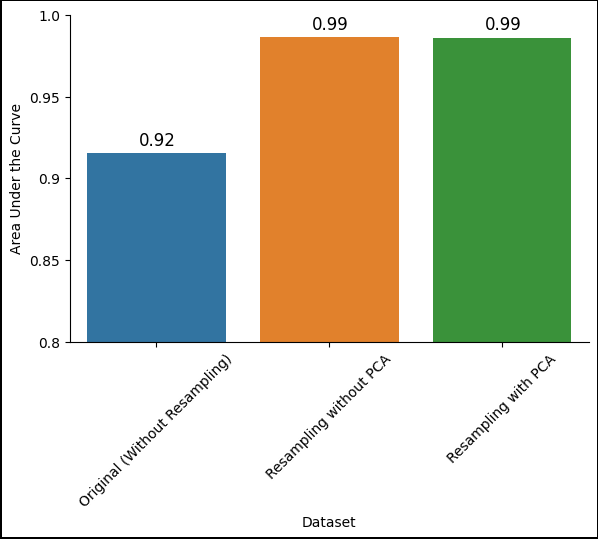

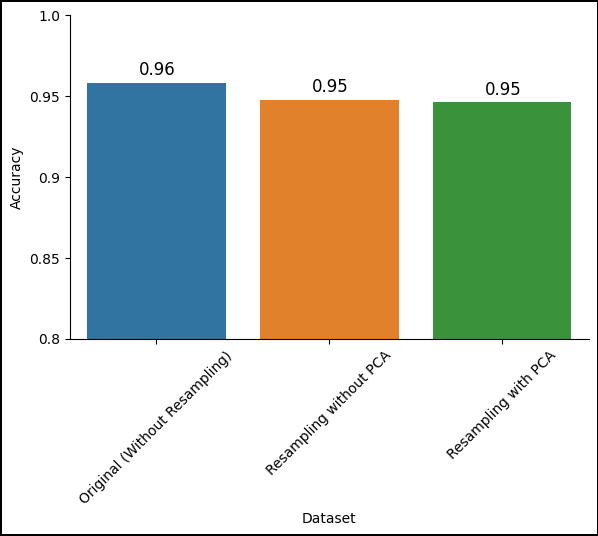

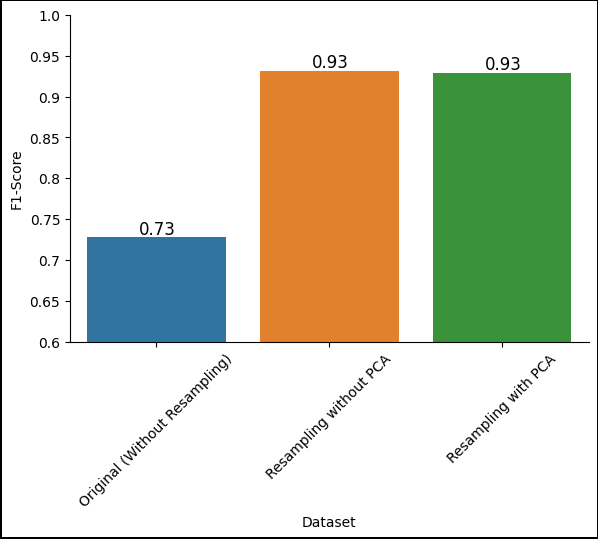

In [ ]:
plot_catplot_for_training_metrics(exp1_training_names, knn_auc, "Area Under the Curve", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp1_training_names, knn_accuracy, "Accuracy", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp1_training_names, knn_f1, "F1-Score", yticks_interval_space=0.05, yticks_limits=(0.6,1))

### 3.1.4 Stochastic Gradient Descent Classifier (SGD)

In [ ]:
sgdc_accuracy = []
sgdc_precision = []
sgdc_recall = []
sgdc_f1 = []
sgdc_auc = []

for i in range(len(exp1_training_data)):
  sgdc = SGDClassifier(random_state=42, loss='log', n_jobs=-1)
  sgdc.fit(exp1_training_data[i], exp1_training_labels[i])

  sgdc_auc.append(cross_val_score(sgdc, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="roc_auc", n_jobs=4).mean())
  sgdc_accuracy.append(cross_val_score(sgdc, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="accuracy", n_jobs=4).mean())
  sgdc_precision.append(cross_val_score(sgdc, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="precision", n_jobs=4).mean())
  sgdc_recall.append(cross_val_score(sgdc, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="recall", n_jobs=4).mean())
  sgdc_f1.append(cross_val_score(sgdc, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="f1", n_jobs=4).mean())

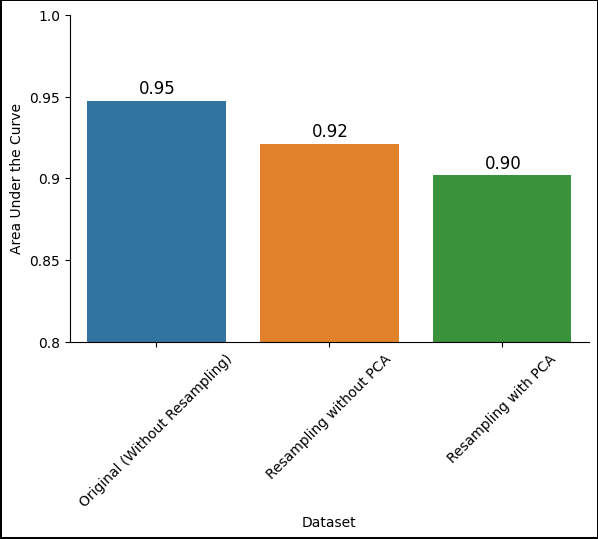

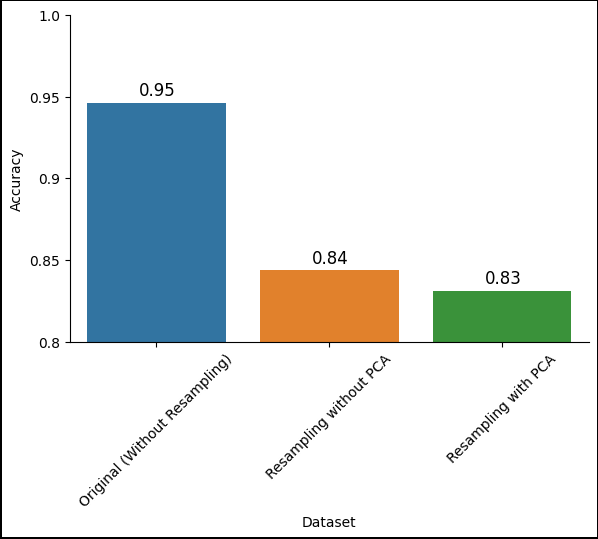

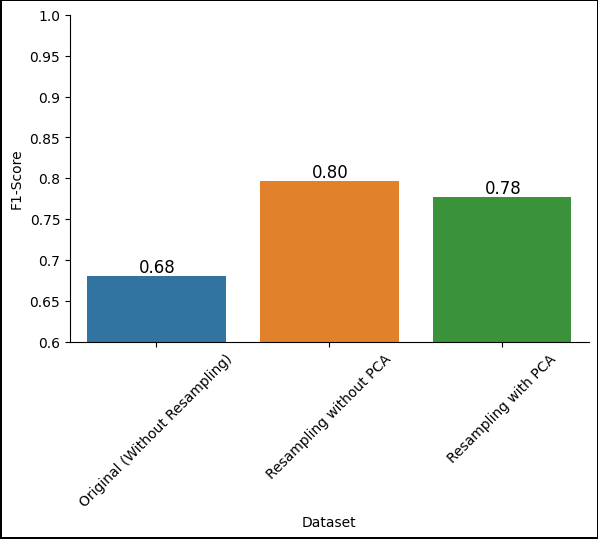

In [ ]:
plot_catplot_for_training_metrics(exp1_training_names, sgdc_auc, "Area Under the Curve", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp1_training_names, sgdc_accuracy, "Accuracy", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp1_training_names, sgdc_f1, "F1-Score", yticks_interval_space=0.05, yticks_limits=(0.6,1))

### 3.1.5 Gaussian Naive Bayes (GaussianNB)

In [ ]:
gnb_accuracy = []
gnb_precision = []
gnb_recall = []
gnb_f1 = []
gnb_auc = []

for i in range(len(exp1_training_data)):
  gnb = GaussianNB()
  gnb.fit(exp1_training_data[i], exp1_training_labels[i])

  gnb_auc.append(cross_val_score(gnb, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="roc_auc", n_jobs=4).mean())
  gnb_accuracy.append(cross_val_score(gnb, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="accuracy", n_jobs=4).mean())
  gnb_precision.append(cross_val_score(gnb, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="precision", n_jobs=4).mean())
  gnb_recall.append(cross_val_score(gnb, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="recall", n_jobs=4).mean())
  gnb_f1.append(cross_val_score(gnb, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="f1", n_jobs=4).mean())

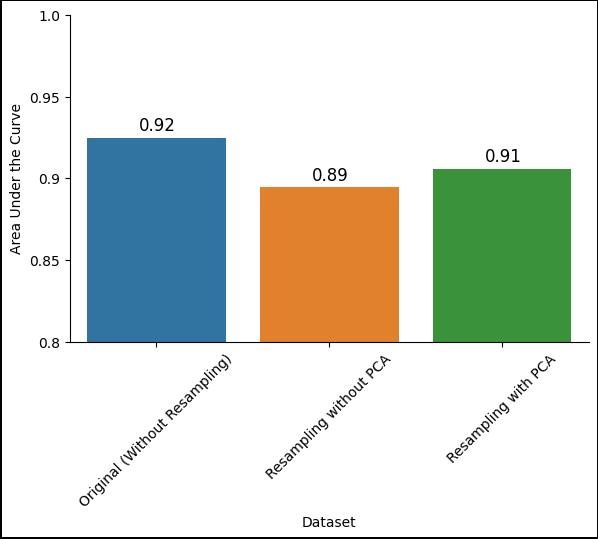

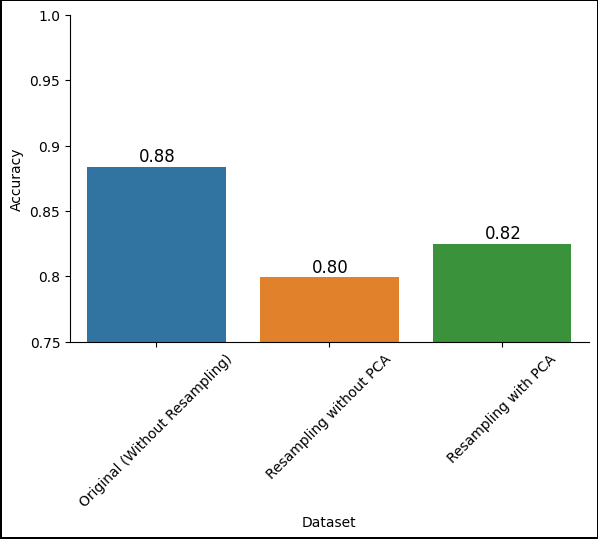

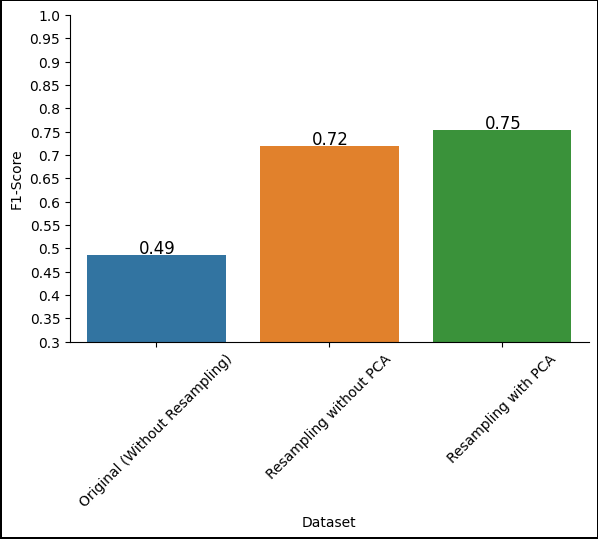

In [ ]:
plot_catplot_for_training_metrics(exp1_training_names, gnb_auc, "Area Under the Curve", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp1_training_names, gnb_accuracy, "Accuracy", yticks_interval_space=0.05, yticks_limits=(0.75,1))
plot_catplot_for_training_metrics(exp1_training_names, gnb_f1, "F1-Score", yticks_interval_space=0.05, yticks_limits=(0.3,1))

### 3.1.6 Decision Tree Classifier

In [ ]:
dtc_accuracy = []
dtc_precision = []
dtc_recall = []
dtc_f1 = []
dtc_auc = []

for i in range(len(exp1_training_data)):
  dtc = DecisionTreeClassifier(random_state=42)
  dtc.fit(exp1_training_data[i], exp1_training_labels[i])

  dtc_auc.append(cross_val_score(dtc, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="roc_auc", n_jobs=4).mean())
  dtc_accuracy.append(cross_val_score(dtc, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="accuracy", n_jobs=4).mean())
  dtc_precision.append(cross_val_score(dtc, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="precision", n_jobs=4).mean())
  dtc_recall.append(cross_val_score(dtc, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="recall", n_jobs=4).mean())
  dtc_f1.append(cross_val_score(dtc, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="f1", n_jobs=4).mean())

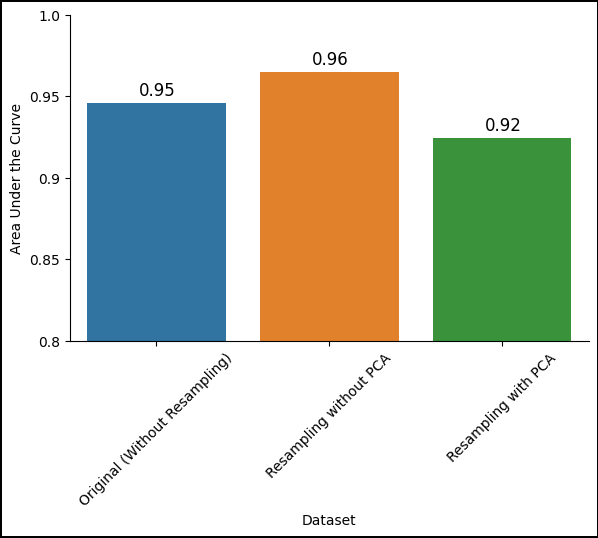

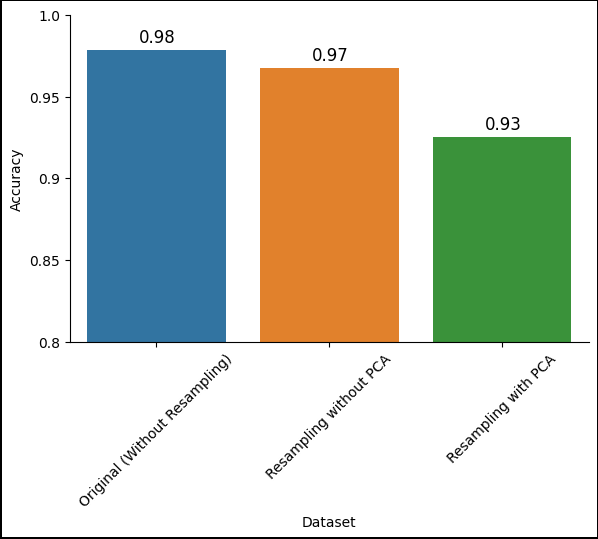

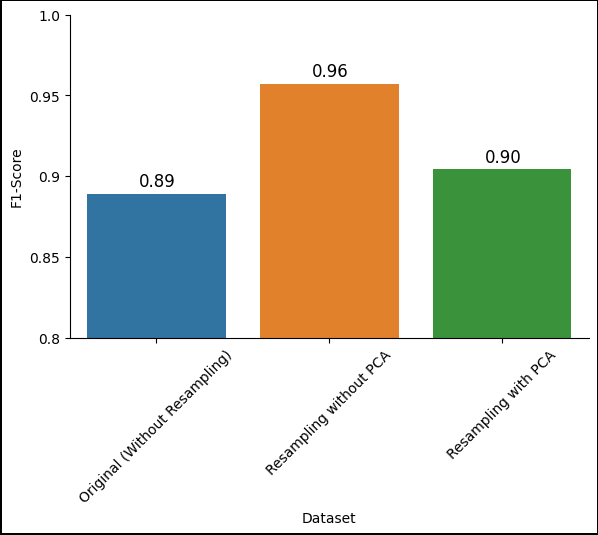

In [ ]:
plot_catplot_for_training_metrics(exp1_training_names, dtc_auc, "Area Under the Curve", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp1_training_names, dtc_accuracy, "Accuracy", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp1_training_names, dtc_f1, "F1-Score", yticks_interval_space=0.05, yticks_limits=(0.8,1))

### 3.1.7 Random Forest

In [ ]:
rfc_accuracy = []
rfc_precision = []
rfc_recall = []
rfc_f1 = []
rfc_auc = []

for i in range(len(exp1_training_data)):
  rfc = RandomForestClassifier(random_state=42, n_jobs=-1)
  rfc.fit(exp1_training_data[i], exp1_training_labels[i])

  rfc_auc.append(cross_val_score(rfc, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="roc_auc", n_jobs=4).mean())
  rfc_accuracy.append(cross_val_score(rfc, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="accuracy", n_jobs=4).mean())
  rfc_precision.append(cross_val_score(rfc, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="precision", n_jobs=4).mean())
  rfc_recall.append(cross_val_score(rfc, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="recall", n_jobs=4).mean())
  rfc_f1.append(cross_val_score(rfc, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="f1", n_jobs=4).mean())

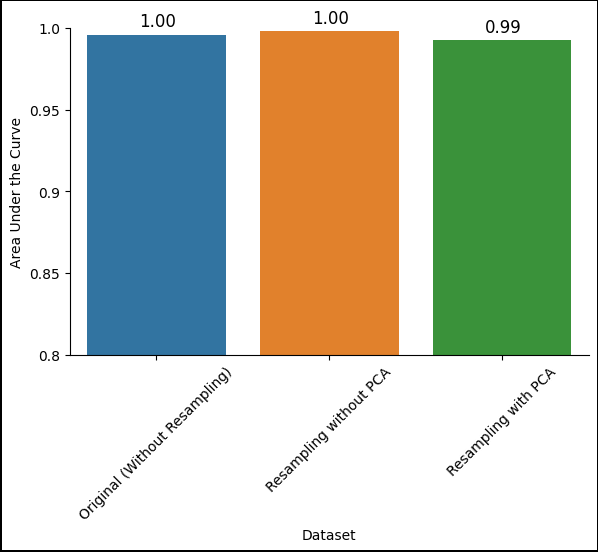

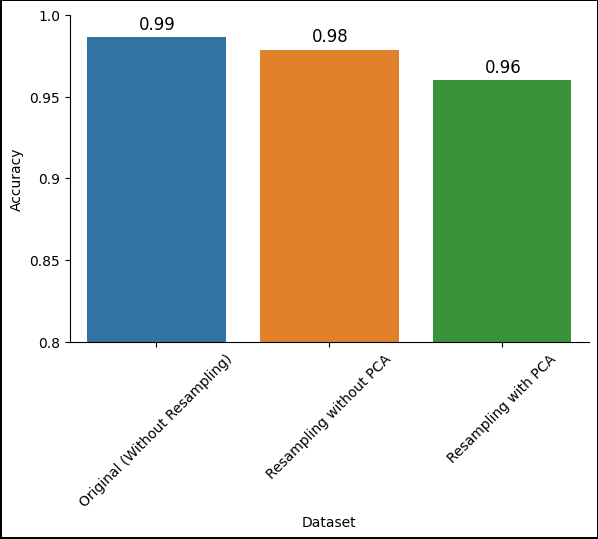

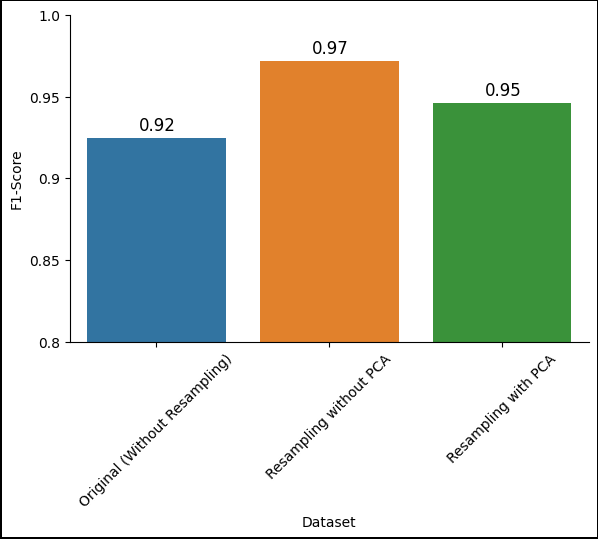

In [ ]:
plot_catplot_for_training_metrics(exp1_training_names, rfc_auc, "Area Under the Curve", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp1_training_names, rfc_accuracy, "Accuracy", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp1_training_names, rfc_f1, "F1-Score", yticks_interval_space=0.05, yticks_limits=(0.8,1))

### 3.1.8 Extra Trees

In [ ]:
etc_accuracy = []
etc_precision = []
etc_recall = []
etc_f1 = []
etc_auc = []

for i in range(len(exp1_training_data)):
  exp1_etc = ExtraTreesClassifier(random_state=42, n_jobs=-1)
  exp1_etc.fit(exp1_training_data[i], exp1_training_labels[i])

  etc_auc.append(cross_val_score(exp1_etc, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="roc_auc", n_jobs=4).mean())
  etc_accuracy.append(cross_val_score(exp1_etc, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="accuracy", n_jobs=4).mean())
  etc_precision.append(cross_val_score(exp1_etc, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="precision", n_jobs=4).mean())
  etc_recall.append(cross_val_score(exp1_etc, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="recall", n_jobs=4).mean())
  etc_f1.append(cross_val_score(exp1_etc, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="f1", n_jobs=4).mean())

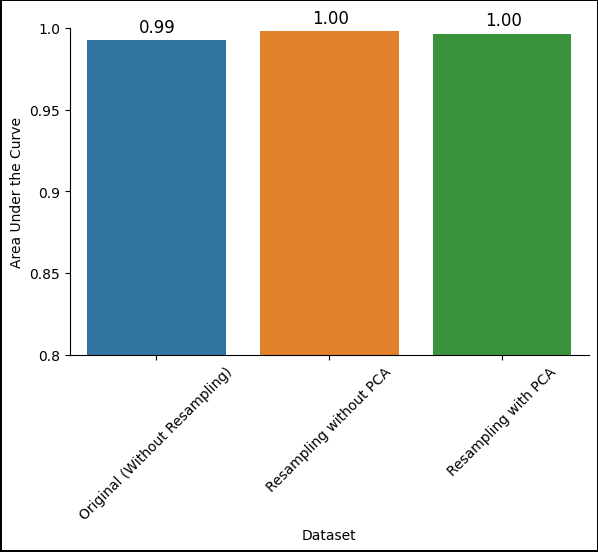

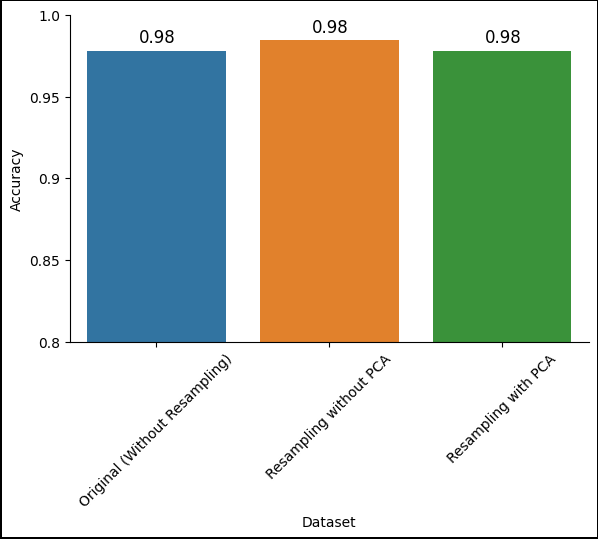

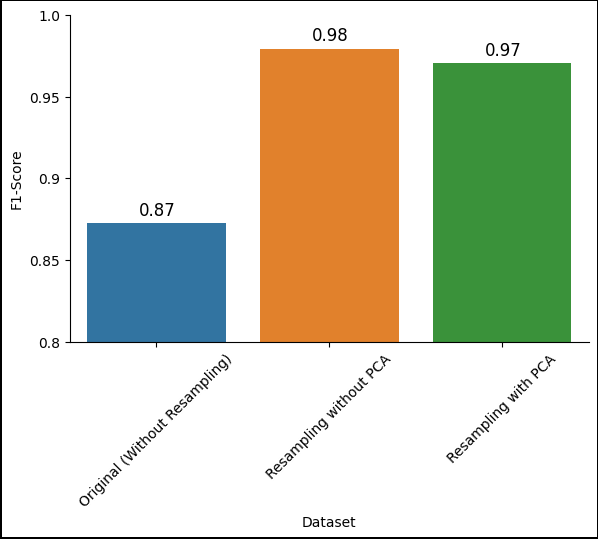

In [ ]:
plot_catplot_for_training_metrics(exp1_training_names, etc_auc, "Area Under the Curve", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp1_training_names, etc_accuracy, "Accuracy", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp1_training_names, etc_f1, "F1-Score", yticks_interval_space=0.05, yticks_limits=(0.8,1))

### 3.1.9 XGBoost Classifier

In [ ]:
xgbc_accuracy = []
xgbc_precision = []
xgbc_recall = []
xgbc_f1 = []
xgbc_auc = []

for i in range(len(exp1_training_data)):
  exp1_xgbc = XGBClassifier(random_state=42, n_jobs=-1)
  exp1_xgbc.fit(exp1_training_data[i], exp1_training_labels[i])

  xgbc_auc.append(cross_val_score(exp1_xgbc, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="roc_auc", n_jobs=4).mean())
  xgbc_accuracy.append(cross_val_score(exp1_xgbc, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="accuracy", n_jobs=4).mean())
  xgbc_precision.append(cross_val_score(exp1_xgbc, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="precision", n_jobs=4).mean())
  xgbc_recall.append(cross_val_score(exp1_xgbc, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="recall", n_jobs=4).mean())
  xgbc_f1.append(cross_val_score(exp1_xgbc, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="f1", n_jobs=4).mean())

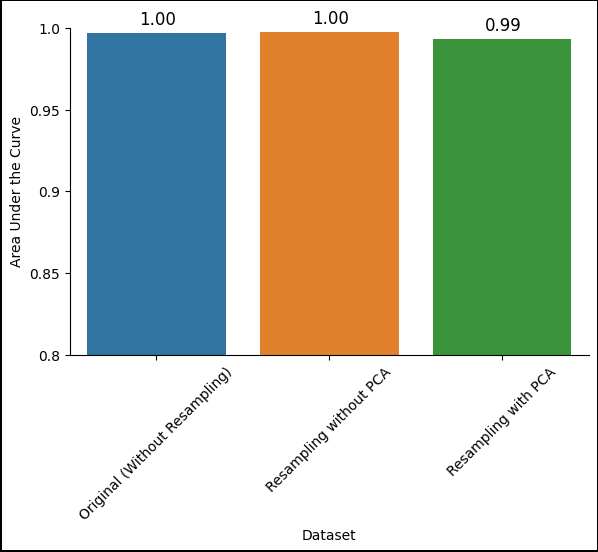

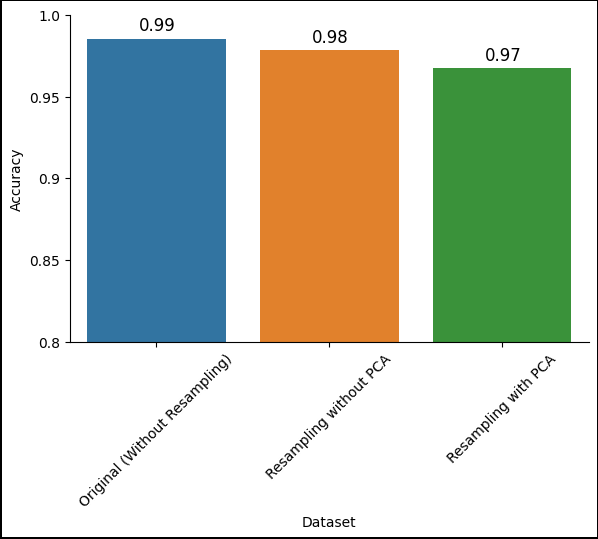

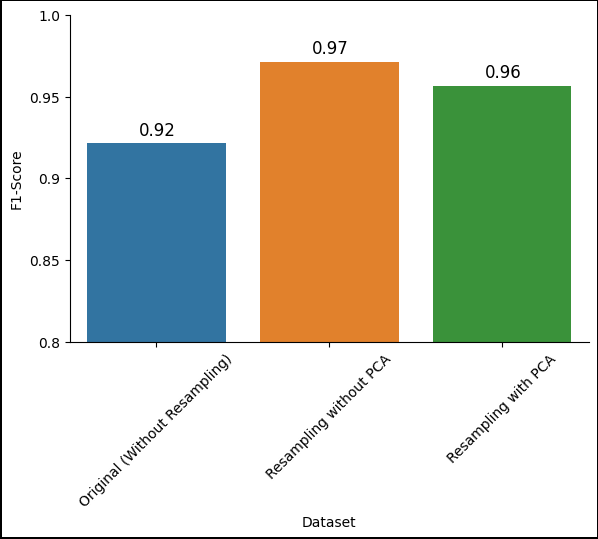

In [ ]:
plot_catplot_for_training_metrics(exp1_training_names, xgbc_auc, "Area Under the Curve", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp1_training_names, xgbc_accuracy, "Accuracy", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp1_training_names, xgbc_f1, "F1-Score", yticks_interval_space=0.05, yticks_limits=(0.8,1))

### 3.1.10 Balanced Bagging Classifier

In [ ]:
bbc_accuracy = []
bbc_precision = []
bbc_recall = []
bbc_f1 = []
bbc_auc = []

for i in range(len(exp1_training_data)):
  exp1_bbc = BalancedBaggingClassifier(random_state=42, n_jobs=-1)
  exp1_bbc.fit(exp1_training_data[i], exp1_training_labels[i])

  bbc_auc.append(cross_val_score(exp1_bbc, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="roc_auc", n_jobs=4).mean())
  bbc_accuracy.append(cross_val_score(exp1_bbc, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="accuracy", n_jobs=4).mean())
  bbc_precision.append(cross_val_score(exp1_bbc, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="precision", n_jobs=4).mean())
  bbc_recall.append(cross_val_score(exp1_bbc, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="recall", n_jobs=4).mean())
  bbc_f1.append(cross_val_score(exp1_bbc, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="f1", n_jobs=4).mean())

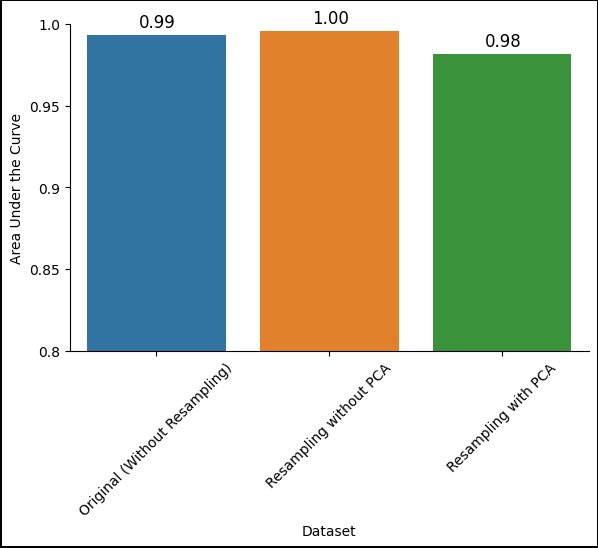

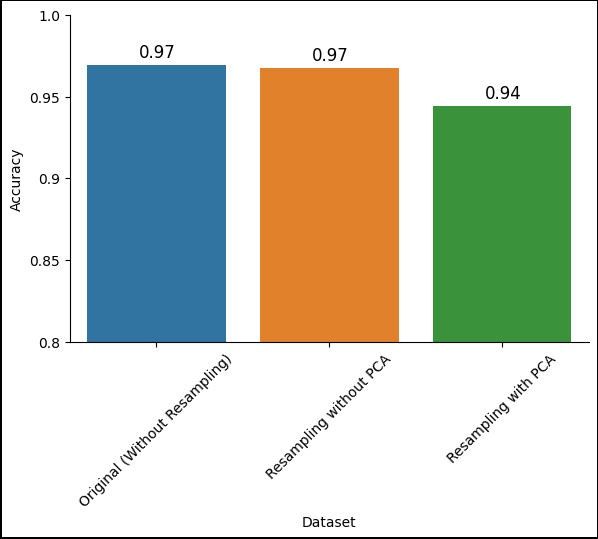

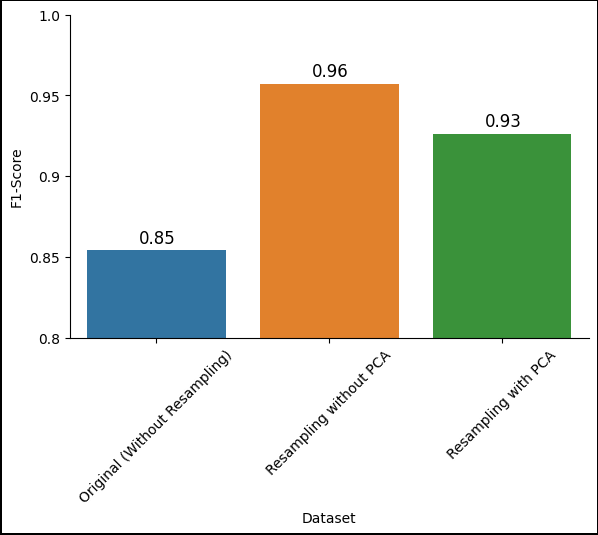

In [ ]:
plot_catplot_for_training_metrics(exp1_training_names, bbc_auc, "Area Under the Curve", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp1_training_names, bbc_accuracy, "Accuracy", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp1_training_names, bbc_f1, "F1-Score", yticks_interval_space=0.05, yticks_limits=(0.8,1))

## 3.2 Training: Experiment 2

In [ ]:
print("Experiment 2 - Original (Without Resampling)   - Training Set Shape:", X_scaled_train_v2.shape)          # y_train_v2
print(y_train_v2.shape)
print("Experiment 2 - Resampling without PCA          - Training Set Shape:", X_resampled_train_v2.shape)       # y_resampled_train_v2
print(y_resampled_train_v2.shape)
print("Experiment 2 - Resampling with PCA             - Training Set Shape:", X_resampled_train_pca_v2.shape)   # y_resampled_train_v2
print(y_resampled_train_v2.shape)

Experiment 2 - Original (Without Resampling)   - Training Set Shape: (3993, 12)
(3993, 1)
Experiment 2 - Resampling without PCA          - Training Set Shape: (2821, 12)
(2821, 1)
Experiment 2 - Resampling with PCA             - Training Set Shape: (2821, 8)
(2821, 1)


In [ ]:
exp2_training_data = [X_scaled_train_v2, X_resampled_train_v2, X_resampled_train_pca_v2]
exp2_training_labels = [y_train_v2, y_resampled_train_v2, y_resampled_train_v2]
exp2_training_names = ["Original (Without Resampling)", "Resampling without PCA", "Resampling with PCA"]

### 3.2.1 Logistic Regression

In [ ]:
exp2_log_reg_accuracy = []
exp2_log_reg_precision = []
exp2_log_reg_recall = []
exp2_log_reg_f1 = []
exp2_log_reg_auc = []

for i in range(len(exp2_training_data)):
  log_reg = LogisticRegression(random_state=42, n_jobs=-1)
  log_reg.fit(exp2_training_data[i], exp2_training_labels[i])

  exp2_log_reg_auc.append(cross_val_score(log_reg, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="roc_auc", n_jobs=4).mean())
  exp2_log_reg_accuracy.append(cross_val_score(log_reg, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="accuracy", n_jobs=4).mean())
  exp2_log_reg_precision.append(cross_val_score(log_reg, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="precision", n_jobs=4).mean())
  exp2_log_reg_recall.append(cross_val_score(log_reg, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="recall", n_jobs=4).mean())
  exp2_log_reg_f1.append(cross_val_score(log_reg, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="f1", n_jobs=4).mean())

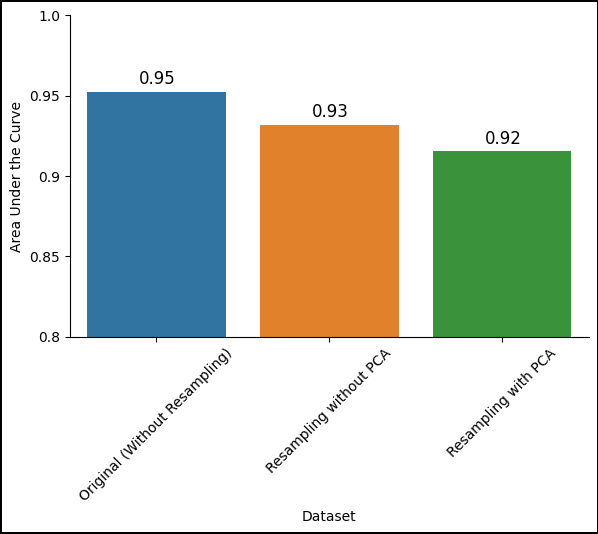

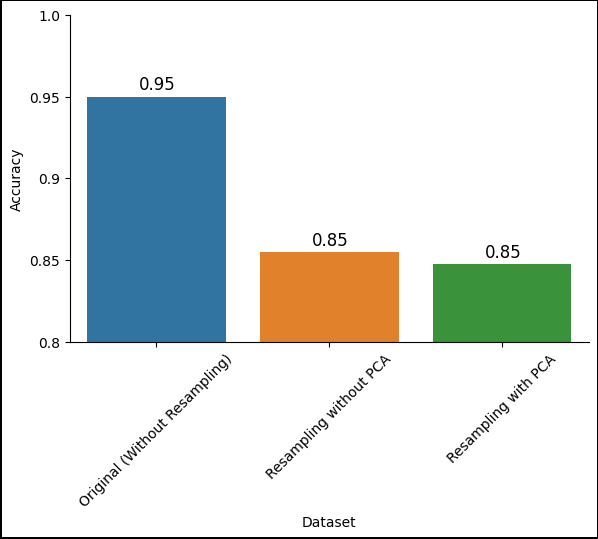

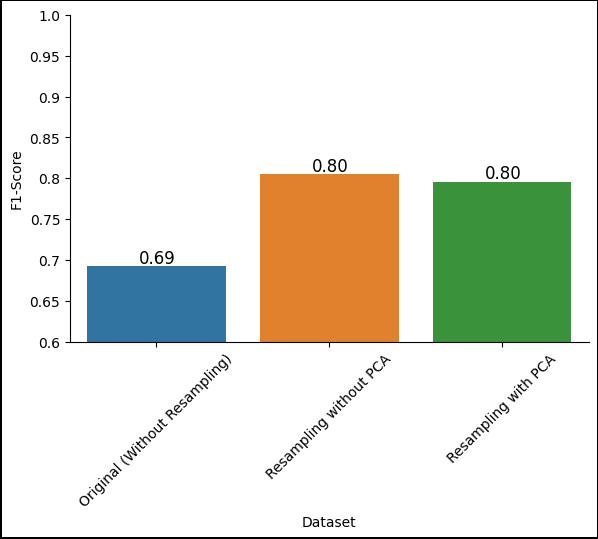

In [ ]:
plot_catplot_for_training_metrics(exp2_training_names, exp2_log_reg_auc, "Area Under the Curve", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp2_training_names, exp2_log_reg_accuracy, "Accuracy", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp2_training_names, exp2_log_reg_f1, "F1-Score", yticks_interval_space=0.05, yticks_limits=(0.6,1))

### 3.2.2 Support Vector Machine Classifier (SVC)

In [ ]:
exp2_svc_accuracy = []
exp2_svc_precision = []
exp2_svc_recall = []
exp2_svc_f1 = []
exp2_svc_auc = []

for i in range(len(exp2_training_data)):
  svc = LinearSVC(random_state=42)
  svc.fit(exp2_training_data[i], exp2_training_labels[i])

  exp2_svc_auc.append(cross_val_score(svc, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="roc_auc", n_jobs=4).mean())
  exp2_svc_accuracy.append(cross_val_score(svc, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="accuracy", n_jobs=4).mean())
  exp2_svc_precision.append(cross_val_score(svc, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="precision", n_jobs=4).mean())
  exp2_svc_recall.append(cross_val_score(svc, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="recall", n_jobs=4).mean())
  exp2_svc_f1.append(cross_val_score(svc, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="f1", n_jobs=4).mean())

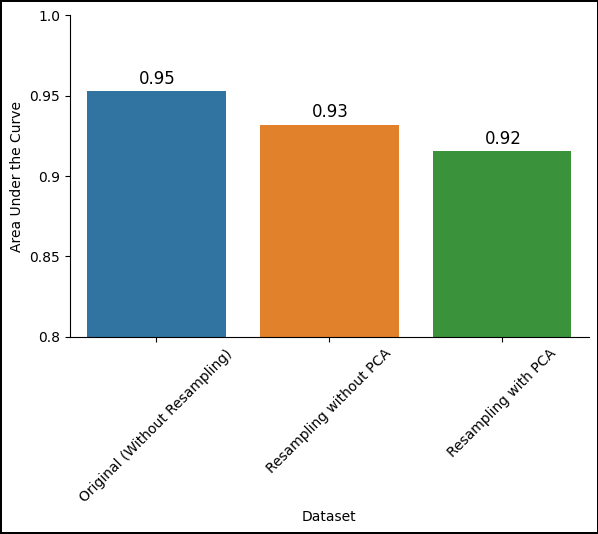

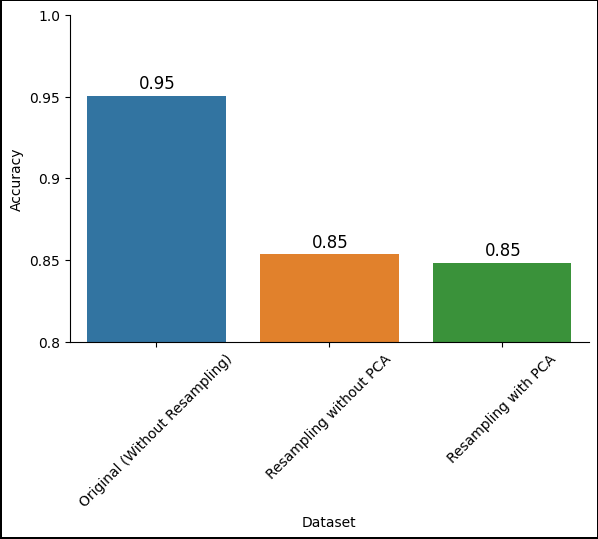

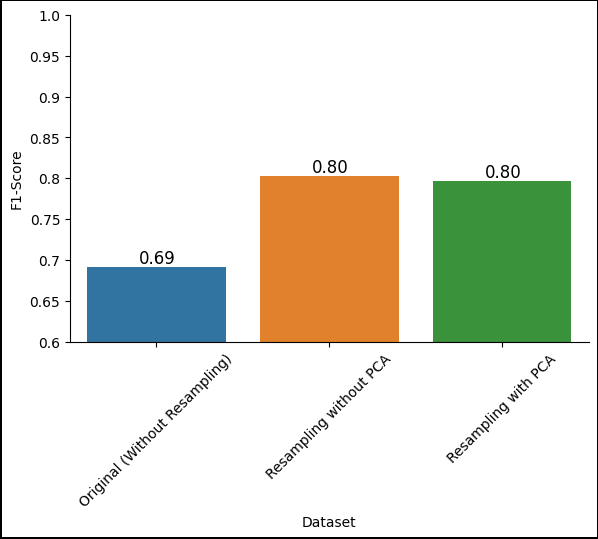

In [ ]:
plot_catplot_for_training_metrics(exp2_training_names, exp2_svc_auc, "Area Under the Curve", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp2_training_names, exp2_svc_accuracy, "Accuracy", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp2_training_names, exp2_svc_f1, "F1-Score", yticks_interval_space=0.05, yticks_limits=(0.6,1))

### 3.2.3 K-Nearest Neighbors



In [ ]:
exp2_knn_accuracy = []
exp2_knn_precision = []
exp2_knn_recall = []
exp2_knn_f1 = []
exp2_knn_auc = []

for i in range(len(exp2_training_data)):
  knn = KNeighborsClassifier(n_jobs=-1)
  knn.fit(exp2_training_data[i], exp2_training_labels[i])

  exp2_knn_auc.append(cross_val_score(knn, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="roc_auc", n_jobs=4).mean())
  exp2_knn_accuracy.append(cross_val_score(knn, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="accuracy", n_jobs=4).mean())
  exp2_knn_precision.append(cross_val_score(knn, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="precision", n_jobs=4).mean())
  exp2_knn_recall.append(cross_val_score(knn, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="recall", n_jobs=4).mean())
  exp2_knn_f1.append(cross_val_score(knn, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="f1", n_jobs=4).mean())

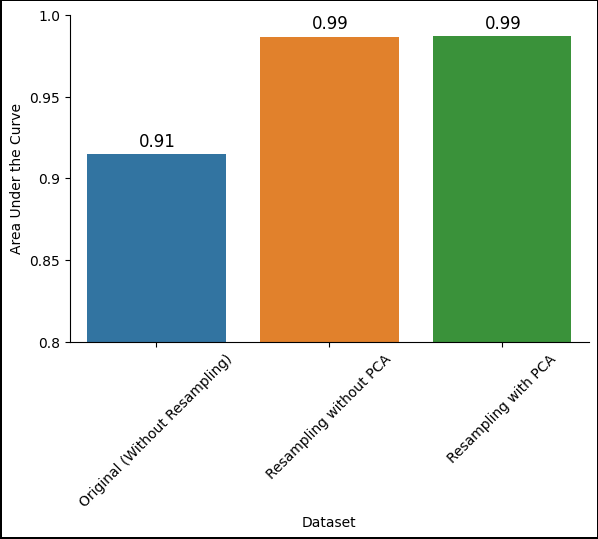

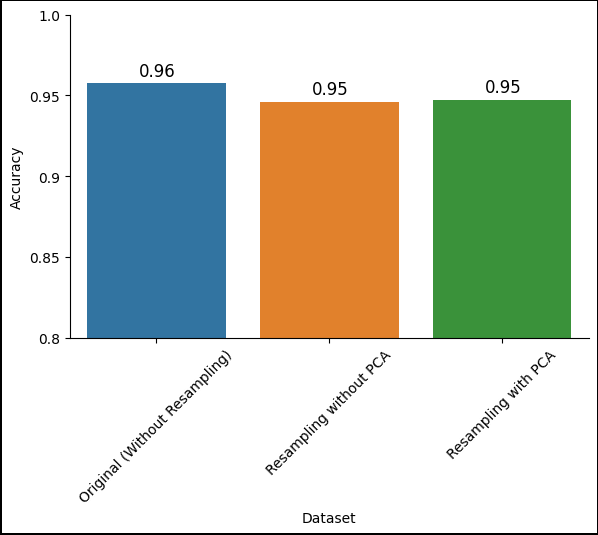

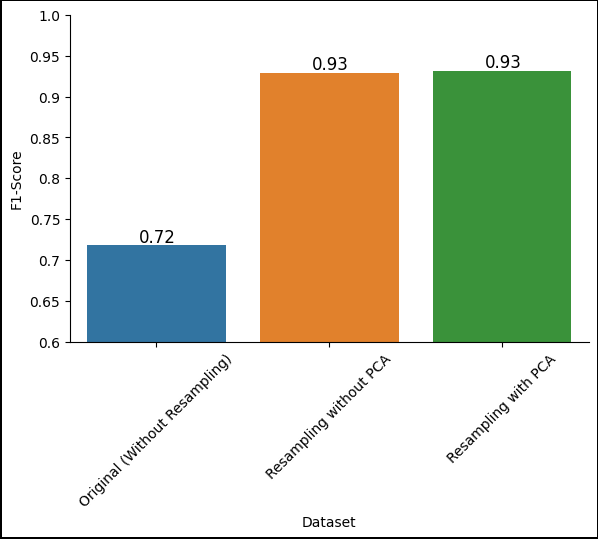

In [ ]:
plot_catplot_for_training_metrics(exp2_training_names, exp2_knn_auc, "Area Under the Curve", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp2_training_names, exp2_knn_accuracy, "Accuracy", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp2_training_names, exp2_knn_f1, "F1-Score", yticks_interval_space=0.05, yticks_limits=(0.6,1))

### 3.2.4 Stochastic Gradient Descent Classifier (SGD)

In [ ]:
exp2_sgdc_accuracy = []
exp2_sgdc_precision = []
exp2_sgdc_recall = []
exp2_sgdc_f1 = []
exp2_sgdc_auc = []

for i in range(len(exp2_training_data)):
  sgdc = SGDClassifier(random_state=42, loss='log', n_jobs=-1)
  sgdc.fit(exp2_training_data[i], exp2_training_labels[i])

  exp2_sgdc_auc.append(cross_val_score(sgdc, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="roc_auc", n_jobs=4).mean())
  exp2_sgdc_accuracy.append(cross_val_score(sgdc, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="accuracy", n_jobs=4).mean())
  exp2_sgdc_precision.append(cross_val_score(sgdc, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="precision", n_jobs=4).mean())
  exp2_sgdc_recall.append(cross_val_score(sgdc, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="recall", n_jobs=4).mean())
  exp2_sgdc_f1.append(cross_val_score(sgdc, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="f1", n_jobs=4).mean())

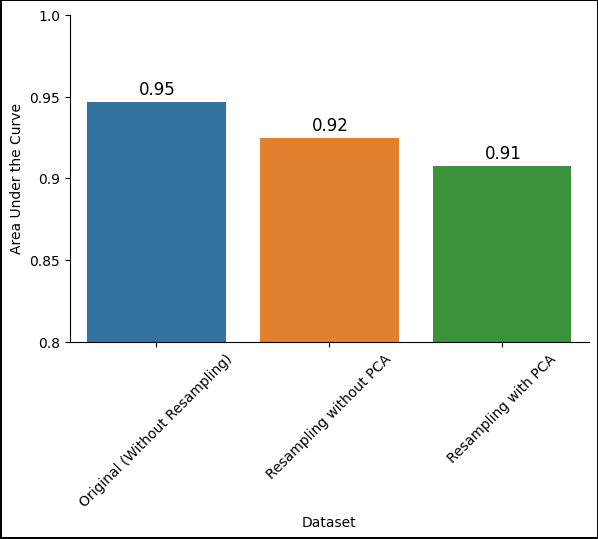

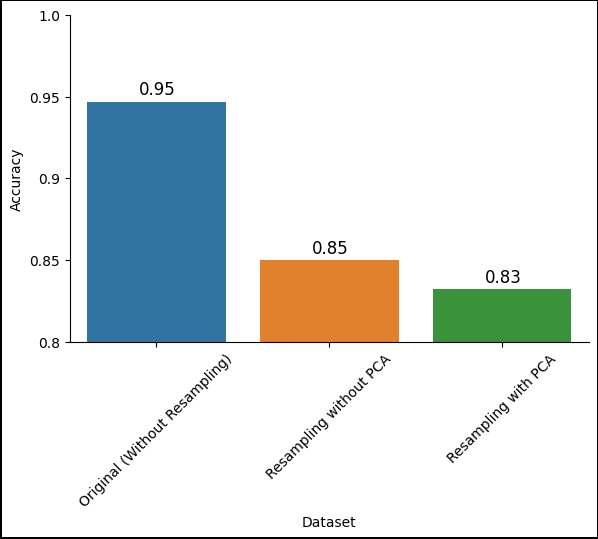

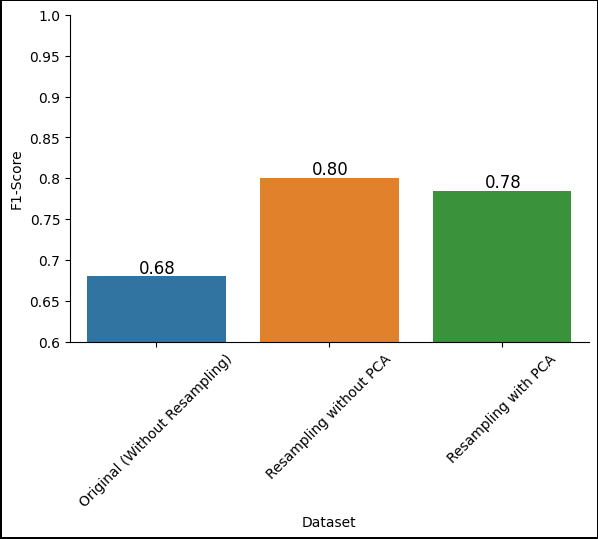

In [ ]:
plot_catplot_for_training_metrics(exp2_training_names, exp2_sgdc_auc, "Area Under the Curve", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp2_training_names, exp2_sgdc_accuracy, "Accuracy", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp2_training_names, exp2_sgdc_f1, "F1-Score", yticks_interval_space=0.05, yticks_limits=(0.6,1))

### 3.2.5 Gaussian Naive Bayes (GaussianNB)

In [ ]:
exp2_gnb_accuracy = []
exp2_gnb_precision = []
exp2_gnb_recall = []
exp2_gnb_f1 = []
exp2_gnb_auc = []

for i in range(len(exp2_training_data)):
  gnb = GaussianNB()
  gnb.fit(exp2_training_data[i], exp2_training_labels[i])

  exp2_gnb_auc.append(cross_val_score(gnb, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="roc_auc", n_jobs=4).mean())
  exp2_gnb_accuracy.append(cross_val_score(gnb, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="accuracy", n_jobs=4).mean())
  exp2_gnb_precision.append(cross_val_score(gnb, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="precision", n_jobs=4).mean())
  exp2_gnb_recall.append(cross_val_score(gnb, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="recall", n_jobs=4).mean())
  exp2_gnb_f1.append(cross_val_score(gnb, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="f1", n_jobs=4).mean())

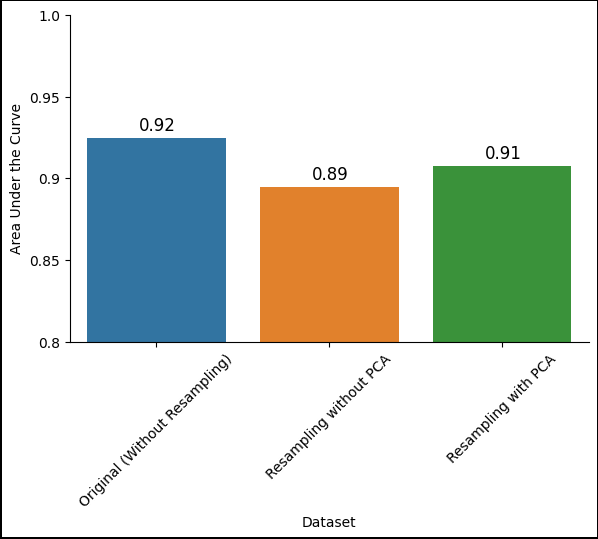

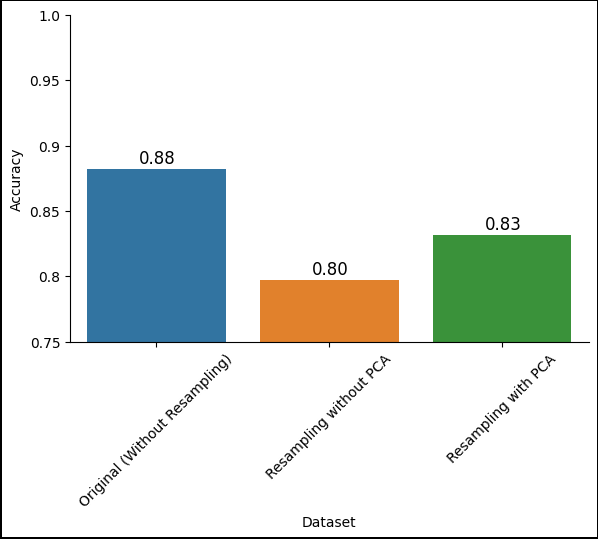

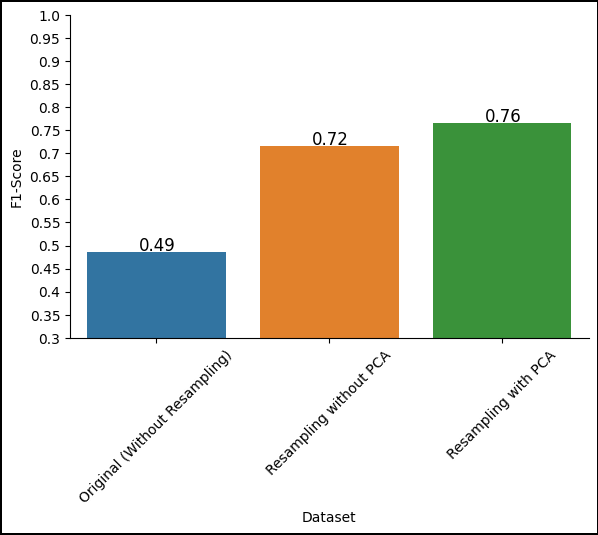

In [ ]:
plot_catplot_for_training_metrics(exp2_training_names, exp2_gnb_auc, "Area Under the Curve", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp2_training_names, exp2_gnb_accuracy, "Accuracy", yticks_interval_space=0.05, yticks_limits=(0.75,1))
plot_catplot_for_training_metrics(exp2_training_names, exp2_gnb_f1, "F1-Score", yticks_interval_space=0.05, yticks_limits=(0.3,1))

### 3.2.6 Decision Tree Classifier

In [ ]:
exp2_dtc_accuracy = []
exp2_dtc_precision = []
exp2_dtc_recall = []
exp2_dtc_f1 = []
exp2_dtc_auc = []

for i in range(len(exp2_training_data)):
  dtc = DecisionTreeClassifier(random_state=42)
  dtc.fit(exp2_training_data[i], exp2_training_labels[i])

  exp2_dtc_auc.append(cross_val_score(dtc, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="roc_auc", n_jobs=4).mean())
  exp2_dtc_accuracy.append(cross_val_score(dtc, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="accuracy", n_jobs=4).mean())
  exp2_dtc_precision.append(cross_val_score(dtc, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="precision", n_jobs=4).mean())
  exp2_dtc_recall.append(cross_val_score(dtc, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="recall", n_jobs=4).mean())
  exp2_dtc_f1.append(cross_val_score(dtc, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="f1", n_jobs=4).mean())

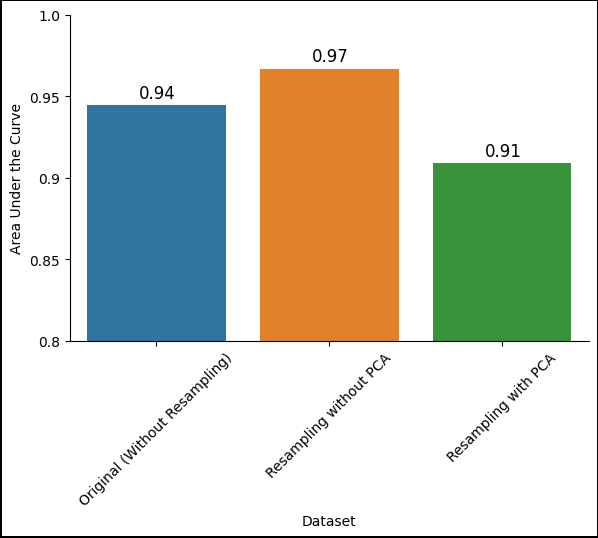

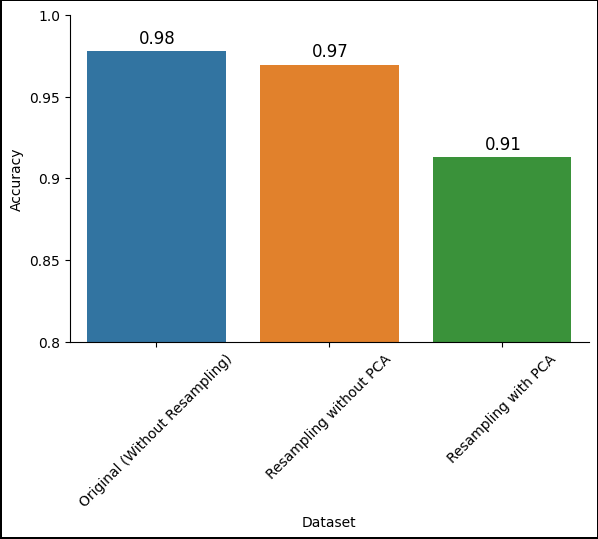

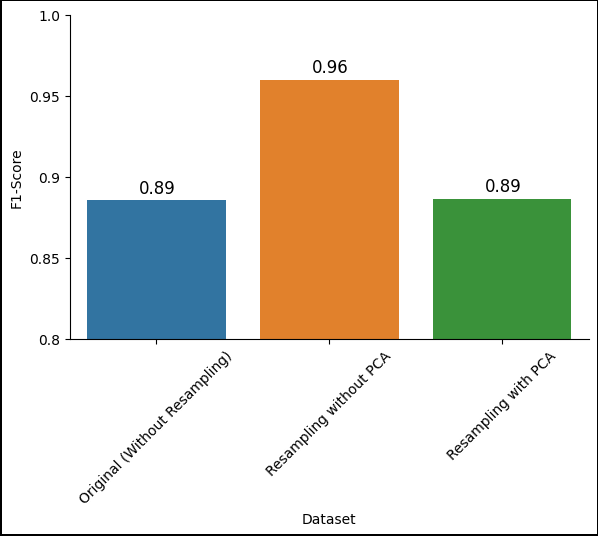

In [ ]:
plot_catplot_for_training_metrics(exp2_training_names, exp2_dtc_auc, "Area Under the Curve", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp2_training_names, exp2_dtc_accuracy, "Accuracy", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp2_training_names, exp2_dtc_f1, "F1-Score", yticks_interval_space=0.05, yticks_limits=(0.8,1))

### 3.2.7 Random Forest

In [ ]:
exp2_rfc_accuracy = []
exp2_rfc_precision = []
exp2_rfc_recall = []
exp2_rfc_f1 = []
exp2_rfc_auc = []

for i in range(len(exp2_training_data)):
  rfc = RandomForestClassifier(random_state=42, n_jobs=-1)
  rfc.fit(exp2_training_data[i], exp2_training_labels[i])

  exp2_rfc_auc.append(cross_val_score(rfc, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="roc_auc", n_jobs=4).mean())
  exp2_rfc_accuracy.append(cross_val_score(rfc, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="accuracy", n_jobs=4).mean())
  exp2_rfc_precision.append(cross_val_score(rfc, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="precision", n_jobs=4).mean())
  exp2_rfc_recall.append(cross_val_score(rfc, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="recall", n_jobs=4).mean())
  exp2_rfc_f1.append(cross_val_score(rfc, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="f1", n_jobs=4).mean())

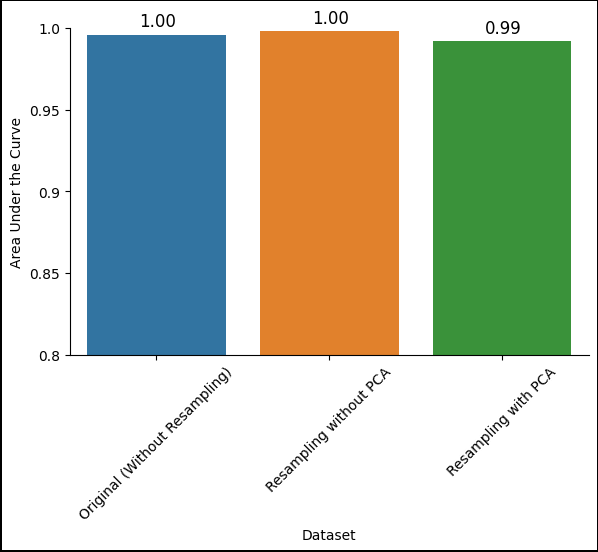

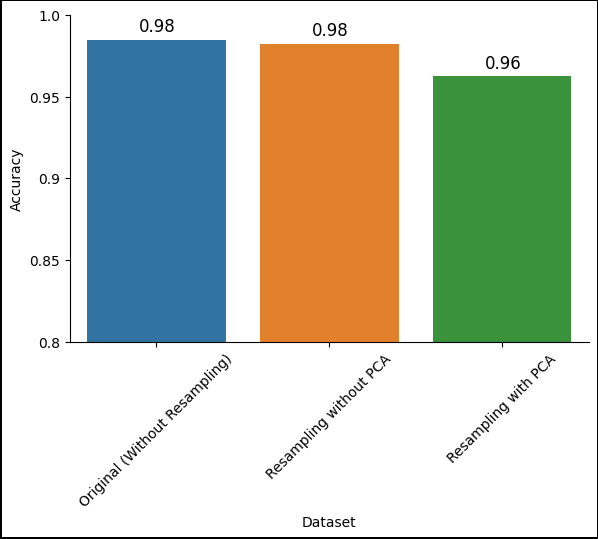

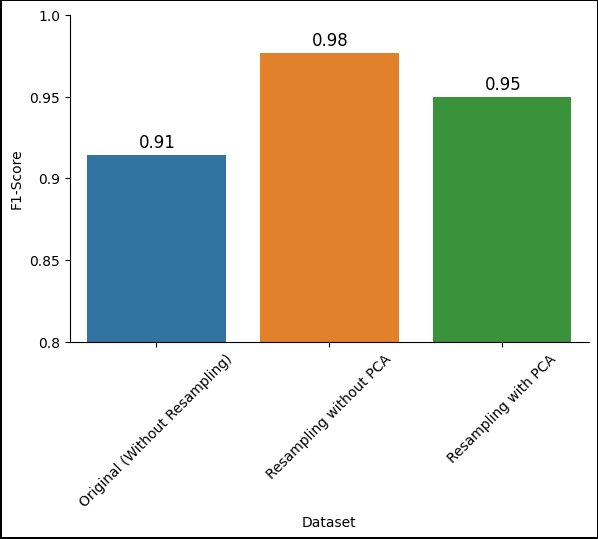

In [ ]:
plot_catplot_for_training_metrics(exp2_training_names, exp2_rfc_auc, "Area Under the Curve", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp2_training_names, exp2_rfc_accuracy, "Accuracy", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp2_training_names, exp2_rfc_f1, "F1-Score", yticks_interval_space=0.05, yticks_limits=(0.8,1))

### 3.2.8 Extra Trees

In [ ]:
exp2_etc_accuracy = []
exp2_etc_precision = []
exp2_etc_recall = []
exp2_etc_f1 = []
exp2_etc_auc = []

for i in range(len(exp2_training_data)):
  exp2_etc = ExtraTreesClassifier(random_state=42, n_jobs=-1)
  exp2_etc.fit(exp2_training_data[i], exp2_training_labels[i])

  exp2_etc_auc.append(cross_val_score(exp2_etc, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="roc_auc", n_jobs=4).mean())
  exp2_etc_accuracy.append(cross_val_score(exp2_etc, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="accuracy", n_jobs=4).mean())
  exp2_etc_precision.append(cross_val_score(exp2_etc, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="precision", n_jobs=4).mean())
  exp2_etc_recall.append(cross_val_score(exp2_etc, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="recall", n_jobs=4).mean())
  exp2_etc_f1.append(cross_val_score(exp2_etc, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="f1", n_jobs=4).mean())

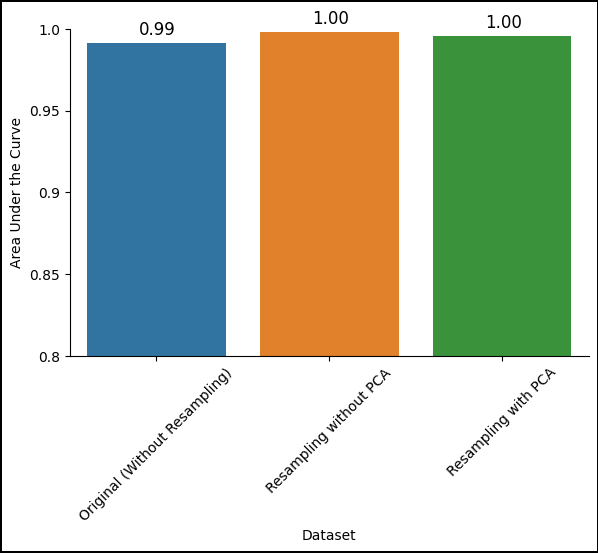

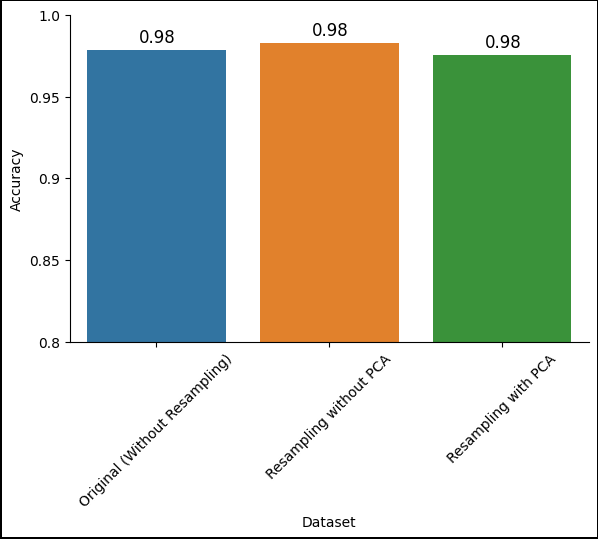

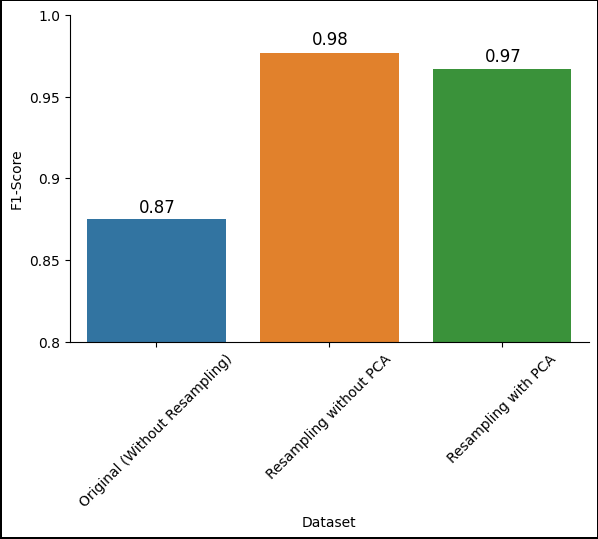

In [ ]:
plot_catplot_for_training_metrics(exp2_training_names, exp2_etc_auc, "Area Under the Curve", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp2_training_names, exp2_etc_accuracy, "Accuracy", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp2_training_names, exp2_etc_f1, "F1-Score", yticks_interval_space=0.05, yticks_limits=(0.8,1))

### 3.2.9 XGBoost Classifier

In [ ]:
exp2_xgbc_accuracy = []
exp2_xgbc_precision = []
exp2_xgbc_recall = []
exp2_xgbc_f1 = []
exp2_xgbc_auc = []

for i in range(len(exp2_training_data)):
  exp2_xgbc = XGBClassifier(random_state=42, n_jobs=-1)
  exp2_xgbc.fit(exp2_training_data[i], exp2_training_labels[i])

  exp2_xgbc_auc.append(cross_val_score(exp2_xgbc, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="roc_auc", n_jobs=4).mean())
  exp2_xgbc_accuracy.append(cross_val_score(exp2_xgbc, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="accuracy", n_jobs=4).mean())
  exp2_xgbc_precision.append(cross_val_score(exp2_xgbc, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="precision", n_jobs=4).mean())
  exp2_xgbc_recall.append(cross_val_score(exp2_xgbc, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="recall", n_jobs=4).mean())
  exp2_xgbc_f1.append(cross_val_score(exp2_xgbc, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="f1", n_jobs=4).mean())

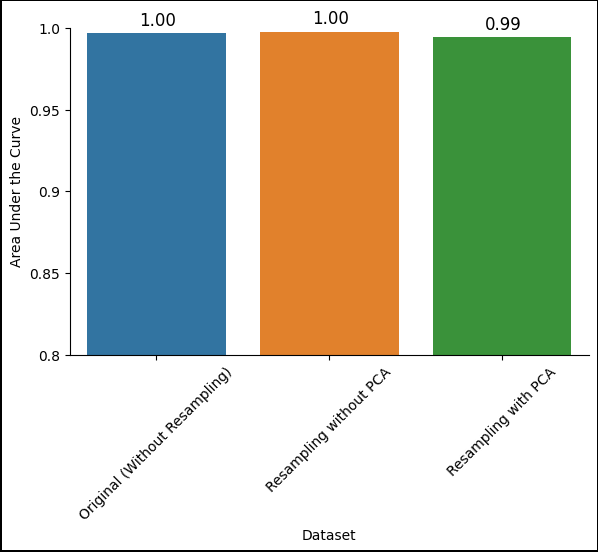

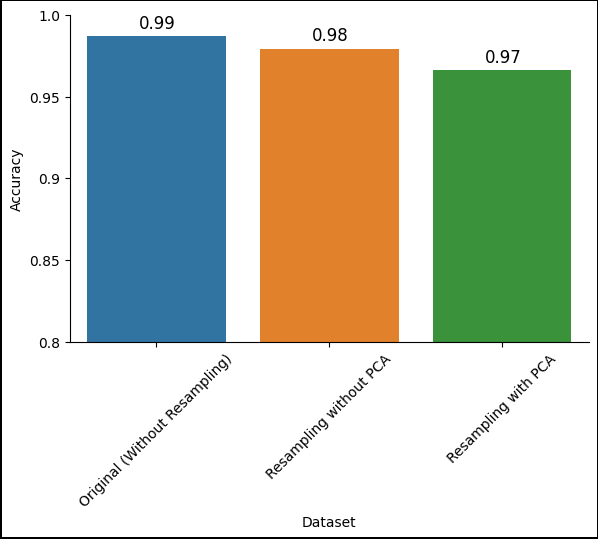

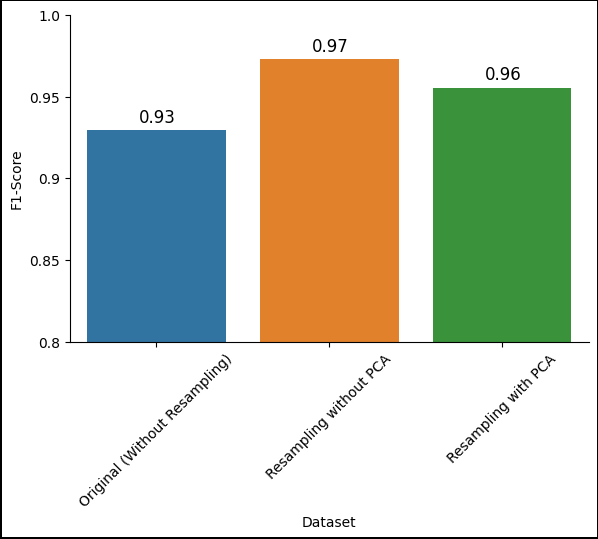

In [ ]:
plot_catplot_for_training_metrics(exp2_training_names, exp2_xgbc_auc, "Area Under the Curve", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp2_training_names, exp2_xgbc_accuracy, "Accuracy", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp2_training_names, exp2_xgbc_f1, "F1-Score", yticks_interval_space=0.05, yticks_limits=(0.8,1))

### 3.2.10 Balanced Bagging Classifier

In [ ]:
exp2_bbc_accuracy = []
exp2_bbc_precision = []
exp2_bbc_recall = []
exp2_bbc_f1 = []
exp2_bbc_auc = []

for i in range(len(exp2_training_data)):
  exp2_bbc = BalancedBaggingClassifier(random_state=42, n_jobs=-1)
  exp2_bbc.fit(exp2_training_data[i], exp2_training_labels[i])

  exp2_bbc_auc.append(cross_val_score(exp2_bbc, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="roc_auc", n_jobs=4).mean())
  exp2_bbc_accuracy.append(cross_val_score(exp2_bbc, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="accuracy", n_jobs=4).mean())
  exp2_bbc_precision.append(cross_val_score(exp2_bbc, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="precision", n_jobs=4).mean())
  exp2_bbc_recall.append(cross_val_score(exp2_bbc, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="recall", n_jobs=4).mean())
  exp2_bbc_f1.append(cross_val_score(exp2_bbc, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="f1", n_jobs=4).mean())

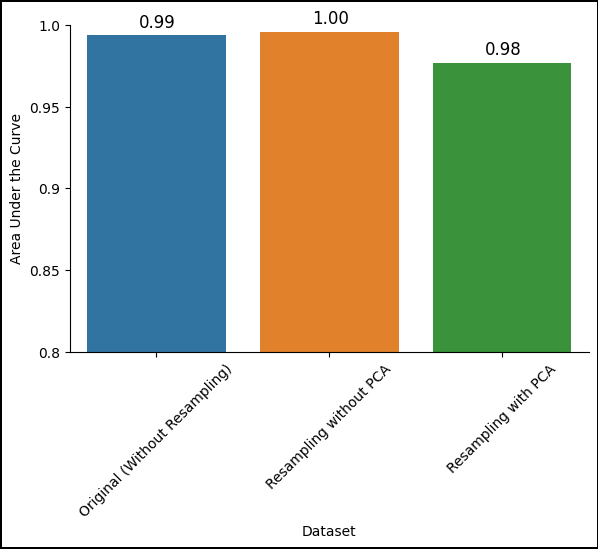

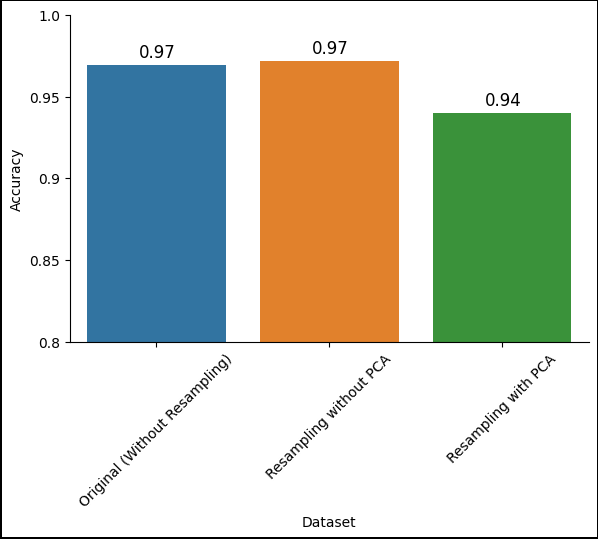

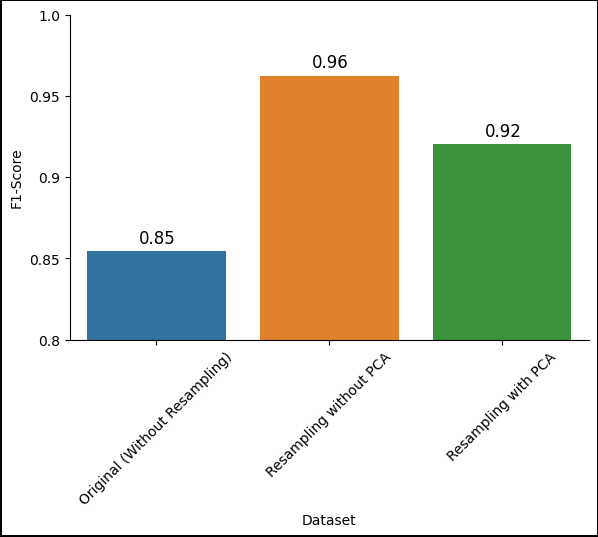

In [ ]:
plot_catplot_for_training_metrics(exp2_training_names, exp2_bbc_auc, "Area Under the Curve", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp2_training_names, exp2_bbc_accuracy, "Accuracy", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp2_training_names, exp2_bbc_f1, "F1-Score", yticks_interval_space=0.05, yticks_limits=(0.8,1))

## 3.3 Training: Experiment 3

In [ ]:
print("Experiment 3 - Original (Without Resampling)   - Training Set Shape:", X_scaled_train_v3.shape)          # y_train_v3
print(y_train_v3.shape)
print("Experiment 3 - Resampling without PCA          - Training Set Shape:", X_resampled_train_v3.shape)       # y_resampled_train_v3
print(y_resampled_train_v3.shape)
print("Experiment 3 - Resampling with PCA             - Training Set Shape:", X_resampled_train_pca_v3.shape)   # y_resampled_train_v3
print(y_resampled_train_v3.shape)

Experiment 3 - Original (Without Resampling)   - Training Set Shape: (3993, 12)
(3993, 1)
Experiment 3 - Resampling without PCA          - Training Set Shape: (2805, 12)
(2805, 1)
Experiment 3 - Resampling with PCA             - Training Set Shape: (2805, 8)
(2805, 1)


In [ ]:
exp3_training_data = [X_scaled_train_v3, X_resampled_train_v3, X_resampled_train_pca_v3]
exp3_training_labels = [y_train_v3, y_resampled_train_v3, y_resampled_train_v3]
exp3_training_names = ["Original (Without Resampling)", "Resampling without PCA", "Resampling with PCA"]

### 3.3.1 Logistic Regression

In [ ]:
exp3_log_reg_accuracy = []
exp3_log_reg_precision = []
exp3_log_reg_recall = []
exp3_log_reg_f1 = []
exp3_log_reg_auc = []

for i in range(len(exp3_training_data)):
  log_reg = LogisticRegression(random_state=42, n_jobs=-1)
  log_reg.fit(exp3_training_data[i], exp3_training_labels[i])

  exp3_log_reg_auc.append(cross_val_score(log_reg, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="roc_auc", n_jobs=4).mean())
  exp3_log_reg_accuracy.append(cross_val_score(log_reg, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="accuracy", n_jobs=4).mean())
  exp3_log_reg_precision.append(cross_val_score(log_reg, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="precision", n_jobs=4).mean())
  exp3_log_reg_recall.append(cross_val_score(log_reg, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="recall", n_jobs=4).mean())
  exp3_log_reg_f1.append(cross_val_score(log_reg, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="f1", n_jobs=4).mean())

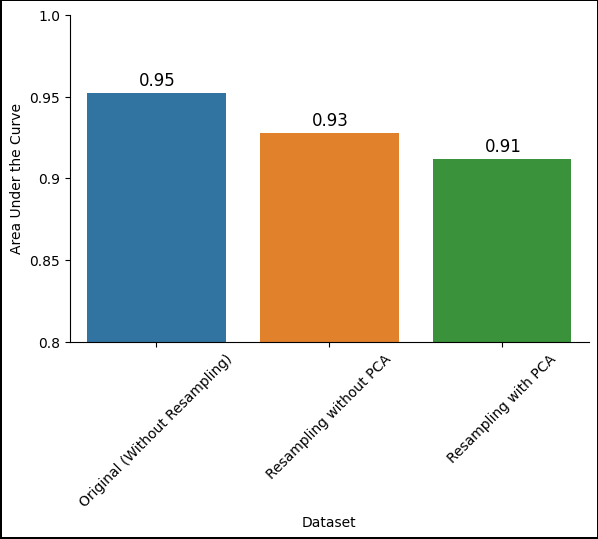

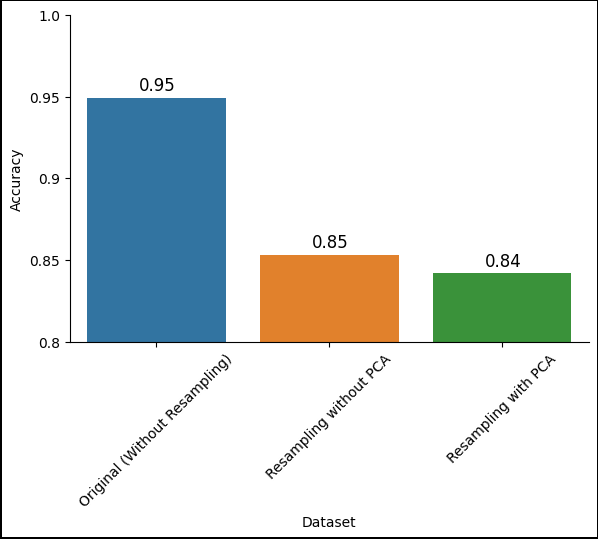

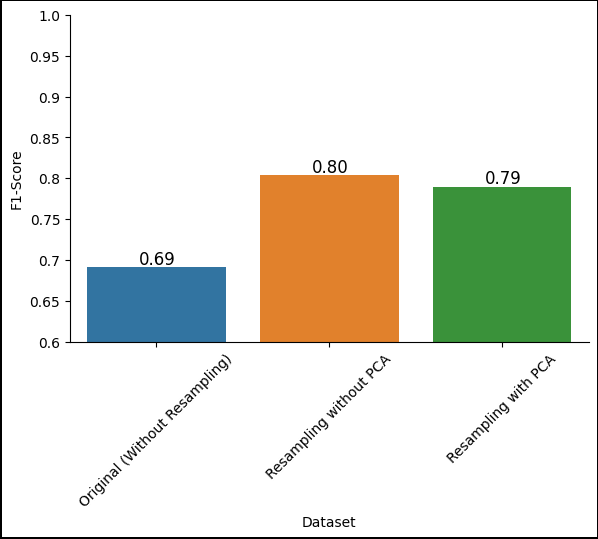

In [ ]:
plot_catplot_for_training_metrics(exp3_training_names, exp3_log_reg_auc, "Area Under the Curve", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp3_training_names, exp3_log_reg_accuracy, "Accuracy", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp3_training_names, exp3_log_reg_f1, "F1-Score", yticks_interval_space=0.05, yticks_limits=(0.6,1))

### 3.3.2 Support Vector Machine Classifier (SVC)

In [ ]:
exp3_svc_accuracy = []
exp3_svc_precision = []
exp3_svc_recall = []
exp3_svc_f1 = []
exp3_svc_auc = []

for i in range(len(exp3_training_data)):
  svc = LinearSVC(random_state=42)
  svc.fit(exp3_training_data[i], exp3_training_labels[i])

  exp3_svc_auc.append(cross_val_score(svc, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="roc_auc", n_jobs=4).mean())
  exp3_svc_accuracy.append(cross_val_score(svc, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="accuracy", n_jobs=4).mean())
  exp3_svc_precision.append(cross_val_score(svc, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="precision", n_jobs=4).mean())
  exp3_svc_recall.append(cross_val_score(svc, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="recall", n_jobs=4).mean())
  exp3_svc_f1.append(cross_val_score(svc, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="f1", n_jobs=4).mean())

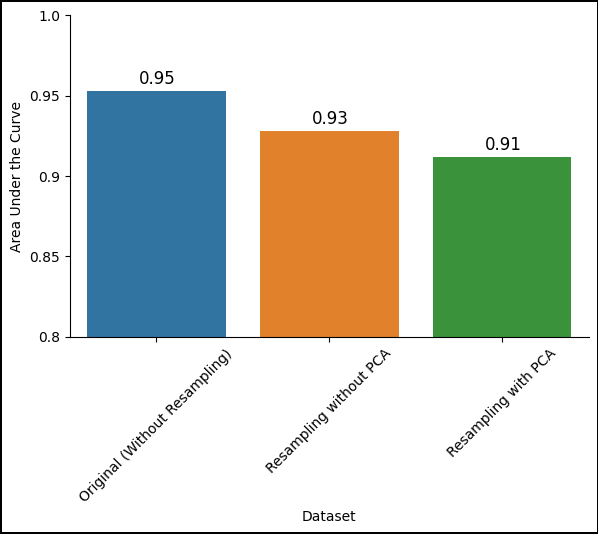

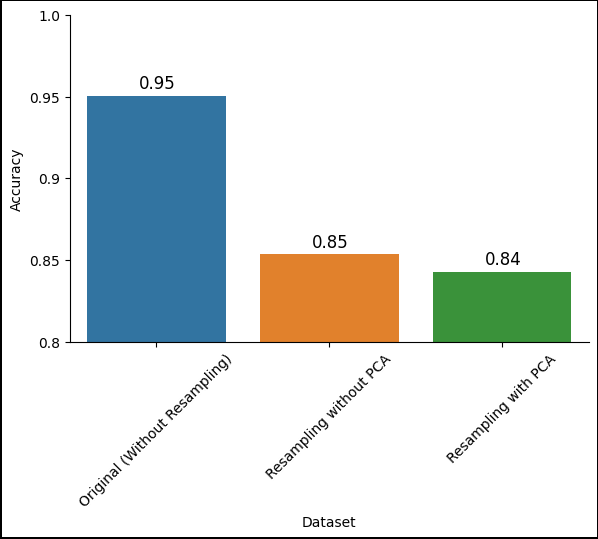

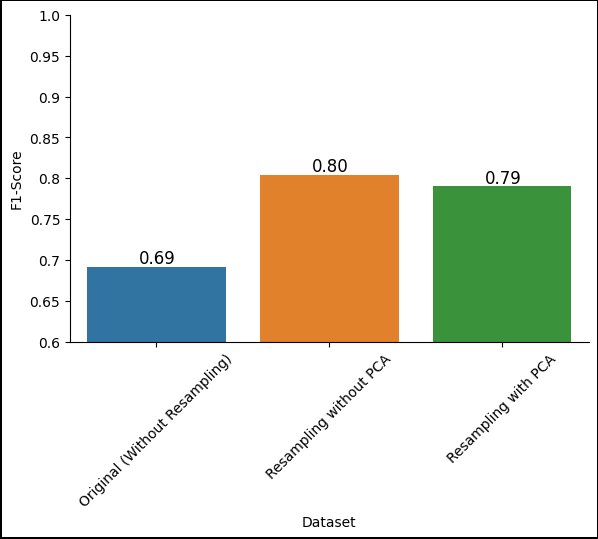

In [ ]:
plot_catplot_for_training_metrics(exp3_training_names, exp3_svc_auc, "Area Under the Curve", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp3_training_names, exp3_svc_accuracy, "Accuracy", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp3_training_names, exp3_svc_f1, "F1-Score", yticks_interval_space=0.05, yticks_limits=(0.6,1))

### 3.3.3 K-Nearest Neighbors



In [ ]:
exp3_knn_accuracy = []
exp3_knn_precision = []
exp3_knn_recall = []
exp3_knn_f1 = []
exp3_knn_auc = []

for i in range(len(exp3_training_data)):
  knn = KNeighborsClassifier(n_jobs=-1)
  knn.fit(exp3_training_data[i], exp3_training_labels[i])

  exp3_knn_auc.append(cross_val_score(knn, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="roc_auc", n_jobs=4).mean())
  exp3_knn_accuracy.append(cross_val_score(knn, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="accuracy", n_jobs=4).mean())
  exp3_knn_precision.append(cross_val_score(knn, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="precision", n_jobs=4).mean())
  exp3_knn_recall.append(cross_val_score(knn, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="recall", n_jobs=4).mean())
  exp3_knn_f1.append(cross_val_score(knn, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="f1", n_jobs=4).mean())

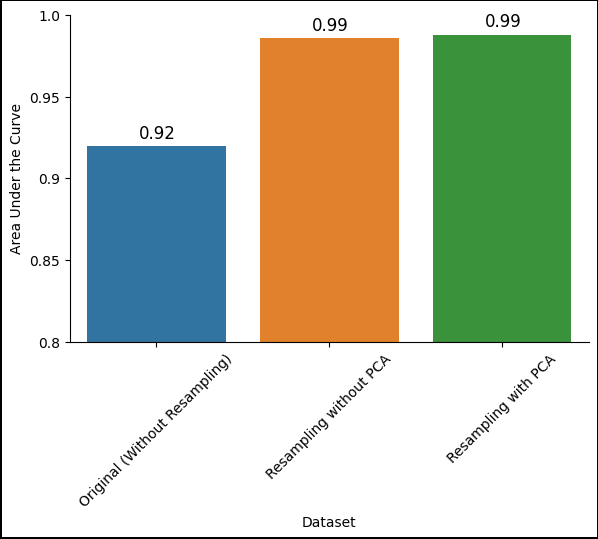

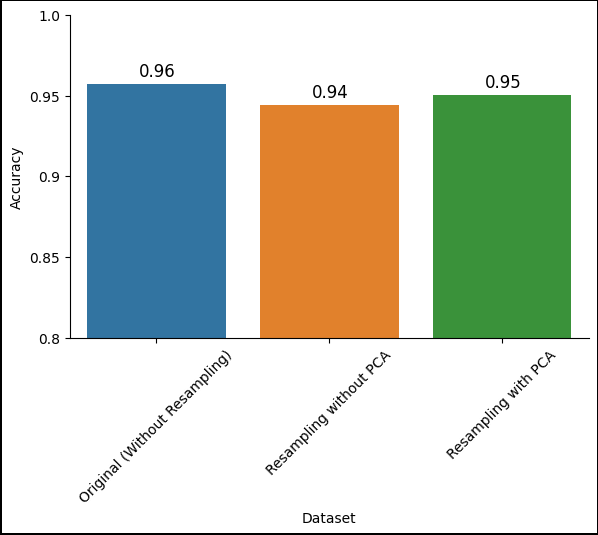

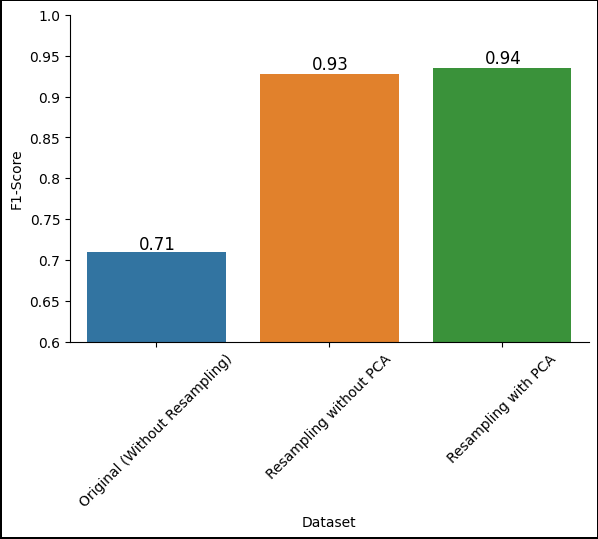

In [ ]:
plot_catplot_for_training_metrics(exp3_training_names, exp3_knn_auc, "Area Under the Curve", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp3_training_names, exp3_knn_accuracy, "Accuracy", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp3_training_names, exp3_knn_f1, "F1-Score", yticks_interval_space=0.05, yticks_limits=(0.6,1))

### 3.3.4 Stochastic Gradient Descent Classifier (SGD)

In [ ]:
exp3_sgdc_accuracy = []
exp3_sgdc_precision = []
exp3_sgdc_recall = []
exp3_sgdc_f1 = []
exp3_sgdc_auc = []

for i in range(len(exp3_training_data)):
  sgdc = SGDClassifier(random_state=42, loss='log', n_jobs=-1)
  sgdc.fit(exp3_training_data[i], exp3_training_labels[i])

  exp3_sgdc_auc.append(cross_val_score(sgdc, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="roc_auc", n_jobs=4).mean())
  exp3_sgdc_accuracy.append(cross_val_score(sgdc, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="accuracy", n_jobs=4).mean())
  exp3_sgdc_precision.append(cross_val_score(sgdc, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="precision", n_jobs=4).mean())
  exp3_sgdc_recall.append(cross_val_score(sgdc, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="recall", n_jobs=4).mean())
  exp3_sgdc_f1.append(cross_val_score(sgdc, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="f1", n_jobs=4).mean())

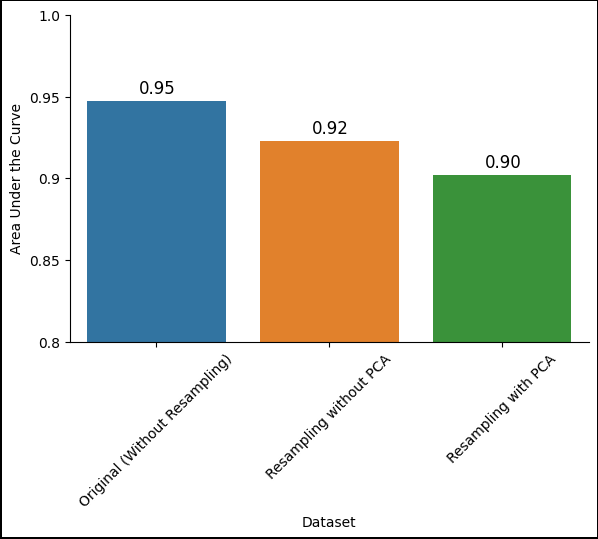

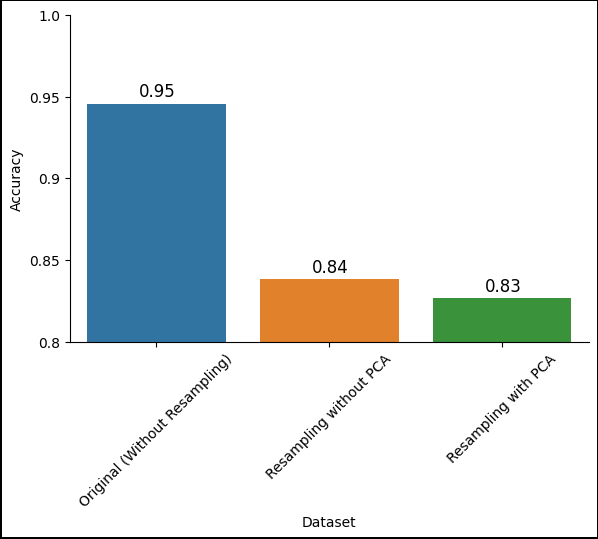

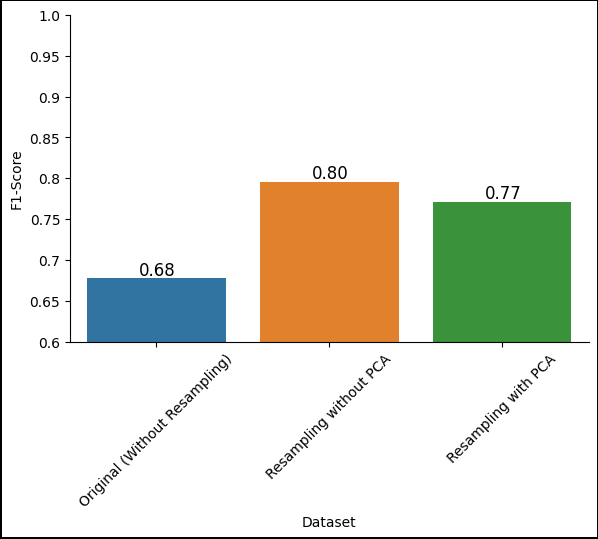

In [ ]:
plot_catplot_for_training_metrics(exp3_training_names, exp3_sgdc_auc, "Area Under the Curve", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp3_training_names, exp3_sgdc_accuracy, "Accuracy", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp3_training_names, exp3_sgdc_f1, "F1-Score", yticks_interval_space=0.05, yticks_limits=(0.6,1))

### 3.3.5 Gaussian Naive Bayes (GaussianNB)

In [ ]:
exp3_gnb_accuracy = []
exp3_gnb_precision = []
exp3_gnb_recall = []
exp3_gnb_f1 = []
exp3_gnb_auc = []

for i in range(len(exp3_training_data)):
  gnb = GaussianNB()
  gnb.fit(exp3_training_data[i], exp3_training_labels[i])

  exp3_gnb_auc.append(cross_val_score(gnb, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="roc_auc", n_jobs=4).mean())
  exp3_gnb_accuracy.append(cross_val_score(gnb, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="accuracy", n_jobs=4).mean())
  exp3_gnb_precision.append(cross_val_score(gnb, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="precision", n_jobs=4).mean())
  exp3_gnb_recall.append(cross_val_score(gnb, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="recall", n_jobs=4).mean())
  exp3_gnb_f1.append(cross_val_score(gnb, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="f1", n_jobs=4).mean())

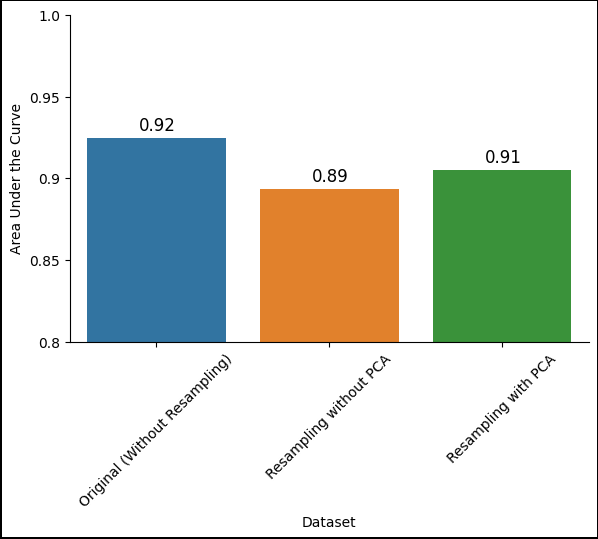

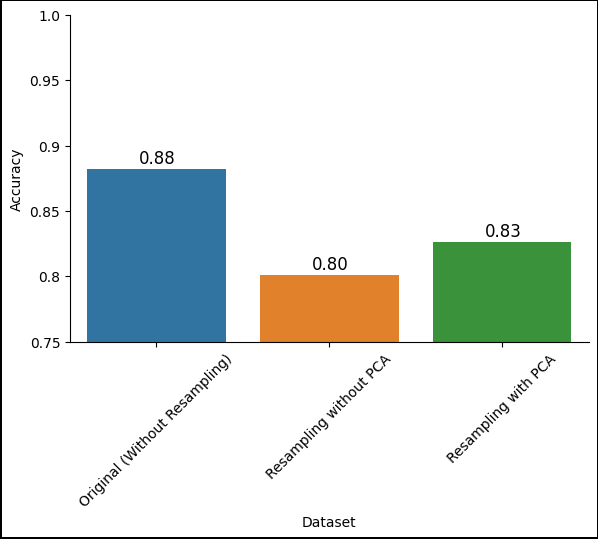

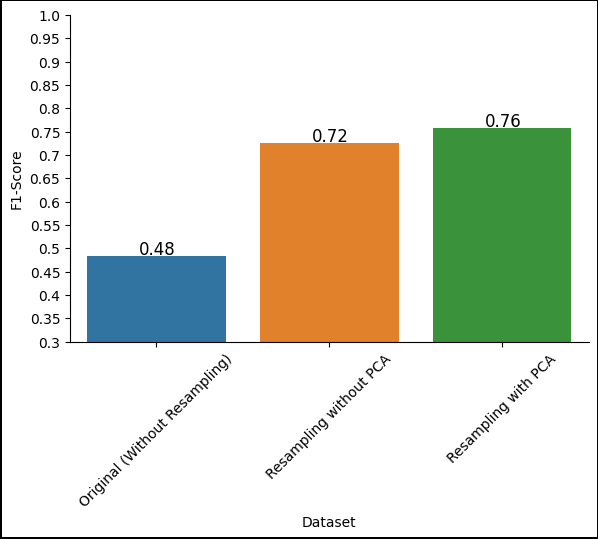

In [ ]:
plot_catplot_for_training_metrics(exp3_training_names, exp3_gnb_auc, "Area Under the Curve", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp3_training_names, exp3_gnb_accuracy, "Accuracy", yticks_interval_space=0.05, yticks_limits=(0.75,1))
plot_catplot_for_training_metrics(exp3_training_names, exp3_gnb_f1, "F1-Score", yticks_interval_space=0.05, yticks_limits=(0.3,1))

### 3.3.6 Decision Tree Classifier

In [ ]:
exp3_dtc_accuracy = []
exp3_dtc_precision = []
exp3_dtc_recall = []
exp3_dtc_f1 = []
exp3_dtc_auc = []

for i in range(len(exp3_training_data)):
  dtc = DecisionTreeClassifier(random_state=42)
  dtc.fit(exp3_training_data[i], exp3_training_labels[i])

  exp3_dtc_auc.append(cross_val_score(dtc, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="roc_auc", n_jobs=4).mean())
  exp3_dtc_accuracy.append(cross_val_score(dtc, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="accuracy", n_jobs=4).mean())
  exp3_dtc_precision.append(cross_val_score(dtc, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="precision", n_jobs=4).mean())
  exp3_dtc_recall.append(cross_val_score(dtc, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="recall", n_jobs=4).mean())
  exp3_dtc_f1.append(cross_val_score(dtc, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="f1", n_jobs=4).mean())

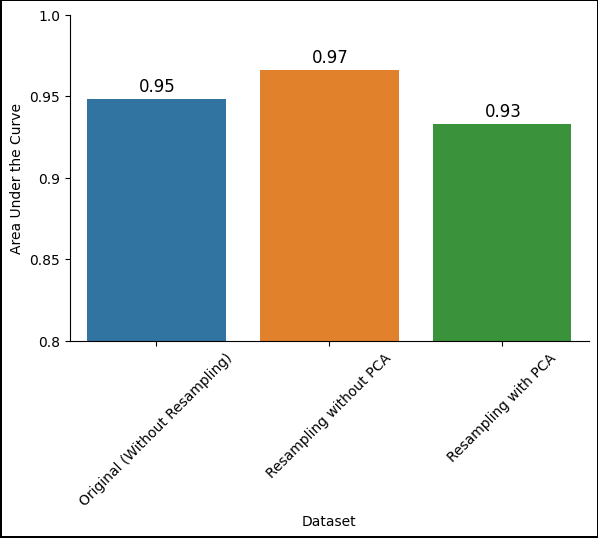

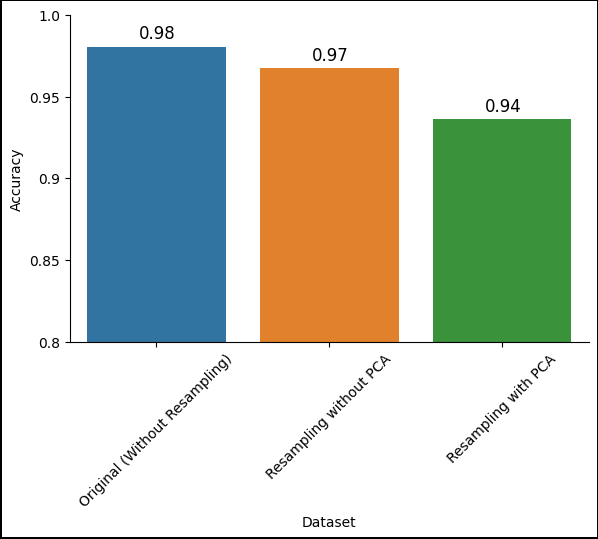

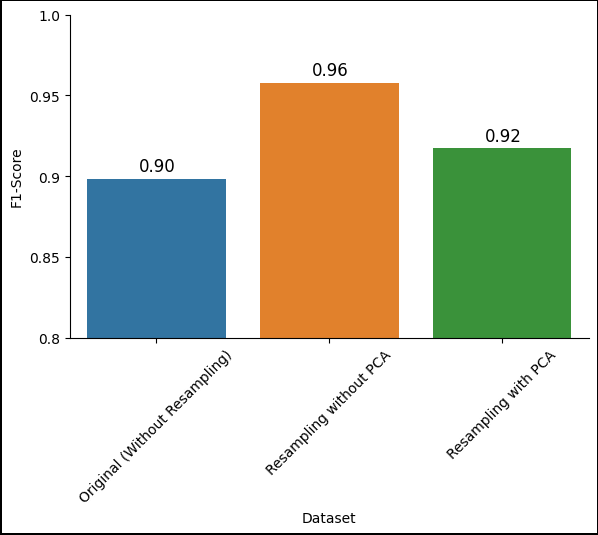

In [ ]:
plot_catplot_for_training_metrics(exp3_training_names, exp3_dtc_auc, "Area Under the Curve", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp3_training_names, exp3_dtc_accuracy, "Accuracy", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp3_training_names, exp3_dtc_f1, "F1-Score", yticks_interval_space=0.05, yticks_limits=(0.8,1))

### 3.3.7 Random Forest

In [ ]:
exp3_rfc_accuracy = []
exp3_rfc_precision = []
exp3_rfc_recall = []
exp3_rfc_f1 = []
exp3_rfc_auc = []

for i in range(len(exp3_training_data)):
  rfc = RandomForestClassifier(random_state=42, n_jobs=-1)
  rfc.fit(exp3_training_data[i], exp3_training_labels[i])

  exp3_rfc_auc.append(cross_val_score(rfc, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="roc_auc", n_jobs=4).mean())
  exp3_rfc_accuracy.append(cross_val_score(rfc, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="accuracy", n_jobs=4).mean())
  exp3_rfc_precision.append(cross_val_score(rfc, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="precision", n_jobs=4).mean())
  exp3_rfc_recall.append(cross_val_score(rfc, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="recall", n_jobs=4).mean())
  exp3_rfc_f1.append(cross_val_score(rfc, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="f1", n_jobs=4).mean())

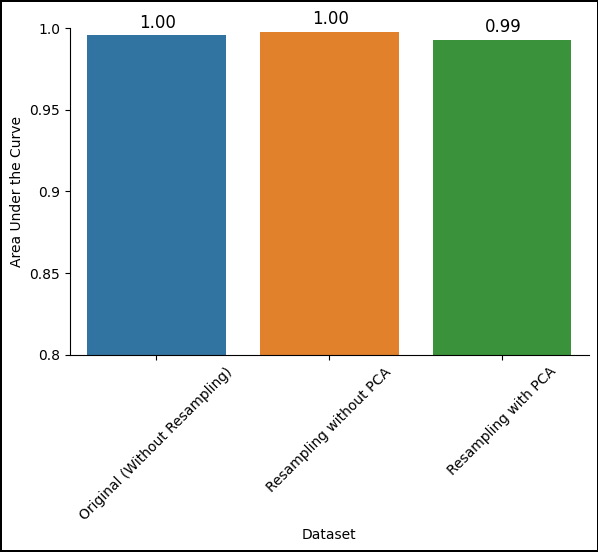

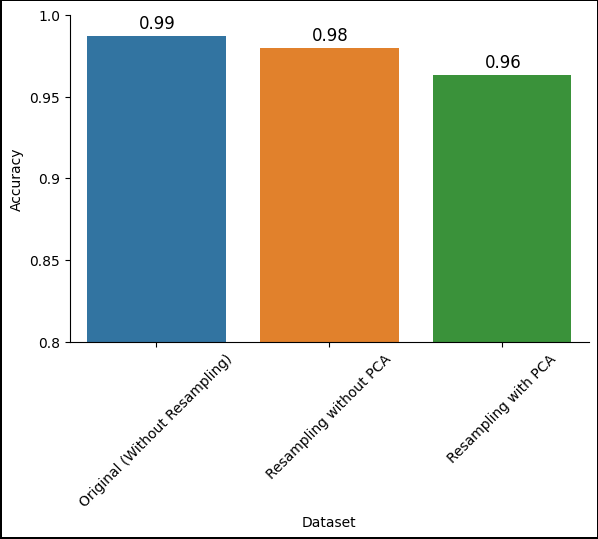

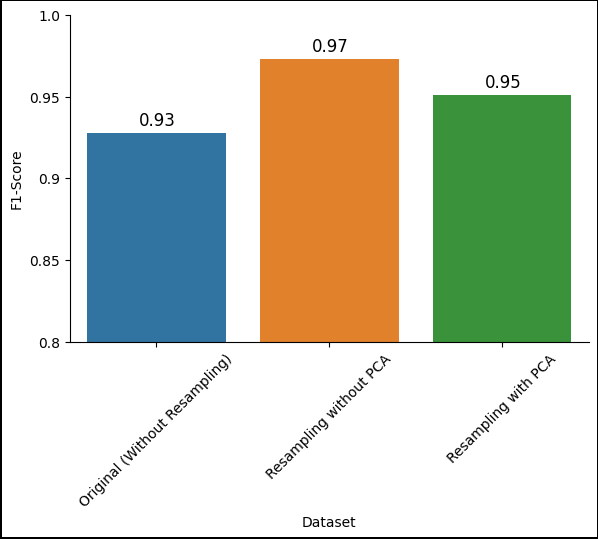

In [ ]:
plot_catplot_for_training_metrics(exp3_training_names, exp3_rfc_auc, "Area Under the Curve", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp3_training_names, exp3_rfc_accuracy, "Accuracy", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp3_training_names, exp3_rfc_f1, "F1-Score", yticks_interval_space=0.05, yticks_limits=(0.8,1))

### 3.3.8 Extra Trees

In [ ]:
exp3_etc_accuracy = []
exp3_etc_precision = []
exp3_etc_recall = []
exp3_etc_f1 = []
exp3_etc_auc = []

for i in range(len(exp3_training_data)):
  exp3_etc = ExtraTreesClassifier(random_state=42, n_jobs=-1)
  exp3_etc.fit(exp3_training_data[i], exp3_training_labels[i])

  exp3_etc_auc.append(cross_val_score(exp3_etc, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="roc_auc", n_jobs=4).mean())
  exp3_etc_accuracy.append(cross_val_score(exp3_etc, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="accuracy", n_jobs=4).mean())
  exp3_etc_precision.append(cross_val_score(exp3_etc, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="precision", n_jobs=4).mean())
  exp3_etc_recall.append(cross_val_score(exp3_etc, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="recall", n_jobs=4).mean())
  exp3_etc_f1.append(cross_val_score(exp3_etc, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="f1", n_jobs=4).mean())

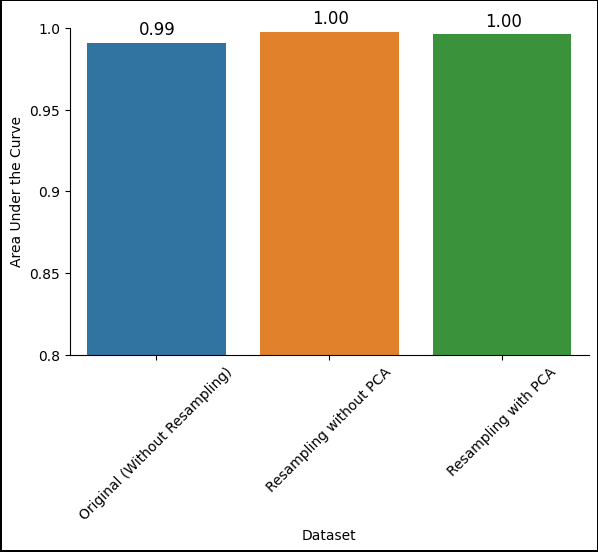

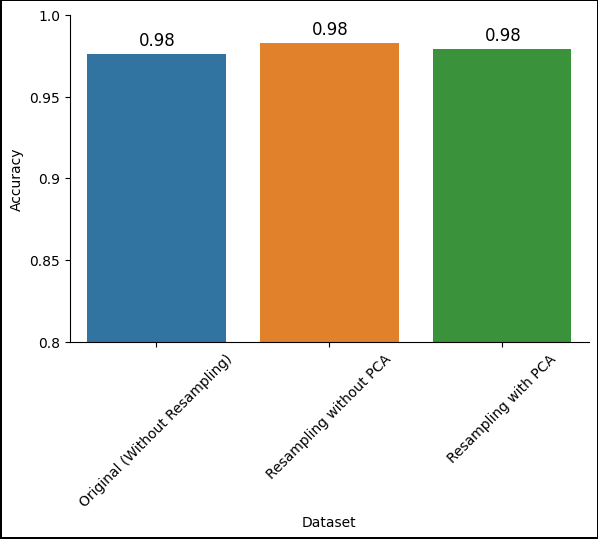

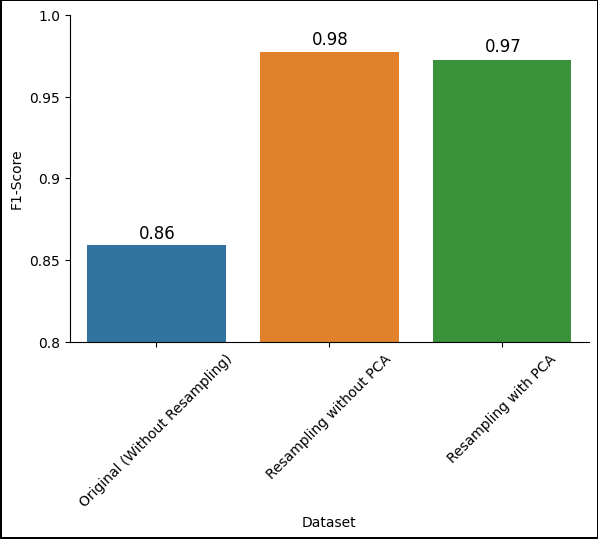

In [ ]:
plot_catplot_for_training_metrics(exp3_training_names, exp3_etc_auc, "Area Under the Curve", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp3_training_names, exp3_etc_accuracy, "Accuracy", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp3_training_names, exp3_etc_f1, "F1-Score", yticks_interval_space=0.05, yticks_limits=(0.8,1))

### 3.3.9 XGBoost Classifier

In [ ]:
exp3_xgbc_accuracy = []
exp3_xgbc_precision = []
exp3_xgbc_recall = []
exp3_xgbc_f1 = []
exp3_xgbc_auc = []

for i in range(len(exp3_training_data)):
  exp3_xgbc = XGBClassifier(random_state=42, n_jobs=-1)
  exp3_xgbc.fit(exp3_training_data[i], exp3_training_labels[i])

  exp3_xgbc_auc.append(cross_val_score(exp3_xgbc, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="roc_auc", n_jobs=4).mean())
  exp3_xgbc_accuracy.append(cross_val_score(exp3_xgbc, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="accuracy", n_jobs=4).mean())
  exp3_xgbc_precision.append(cross_val_score(exp3_xgbc, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="precision", n_jobs=4).mean())
  exp3_xgbc_recall.append(cross_val_score(exp3_xgbc, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="recall", n_jobs=4).mean())
  exp3_xgbc_f1.append(cross_val_score(exp3_xgbc, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="f1", n_jobs=4).mean())

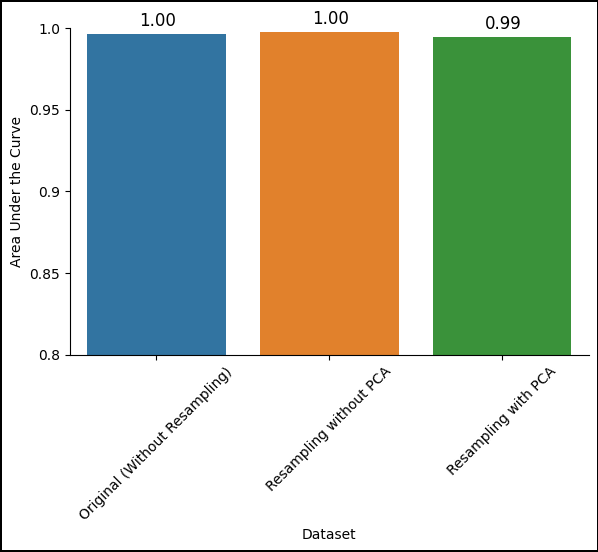

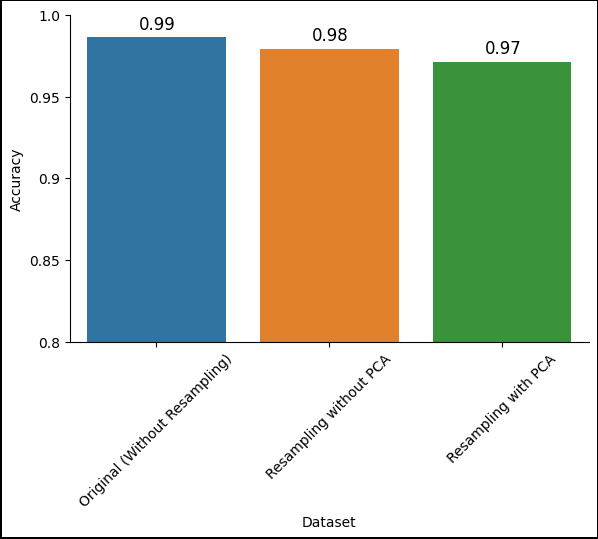

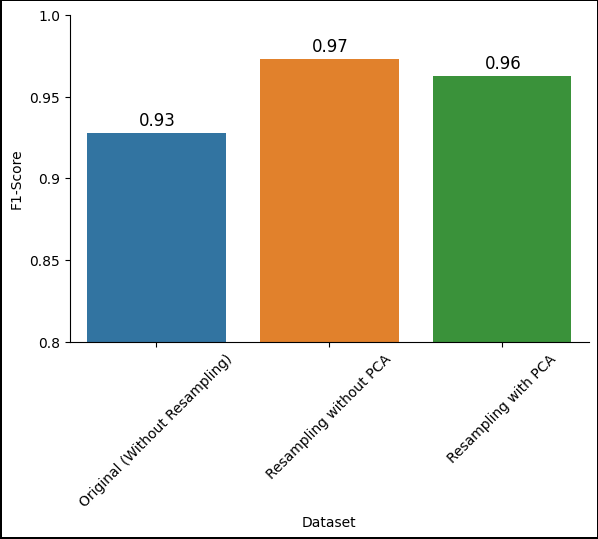

In [ ]:
plot_catplot_for_training_metrics(exp3_training_names, exp3_xgbc_auc, "Area Under the Curve", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp3_training_names, exp3_xgbc_accuracy, "Accuracy", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp3_training_names, exp3_xgbc_f1, "F1-Score", yticks_interval_space=0.05, yticks_limits=(0.8,1))

### 3.3.10 Balanced Bagging Classifier

In [ ]:
exp3_bbc_accuracy = []
exp3_bbc_precision = []
exp3_bbc_recall = []
exp3_bbc_f1 = []
exp3_bbc_auc = []

for i in range(len(exp3_training_data)):
  exp3_bbc = BalancedBaggingClassifier(random_state=42, n_jobs=-1)
  exp3_bbc.fit(exp3_training_data[i], exp3_training_labels[i])

  exp3_bbc_auc.append(cross_val_score(exp3_bbc, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="roc_auc", n_jobs=4).mean())
  exp3_bbc_accuracy.append(cross_val_score(exp3_bbc, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="accuracy", n_jobs=4).mean())
  exp3_bbc_precision.append(cross_val_score(exp3_bbc, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="precision", n_jobs=4).mean())
  exp3_bbc_recall.append(cross_val_score(exp3_bbc, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="recall", n_jobs=4).mean())
  exp3_bbc_f1.append(cross_val_score(exp3_bbc, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="f1", n_jobs=4).mean())

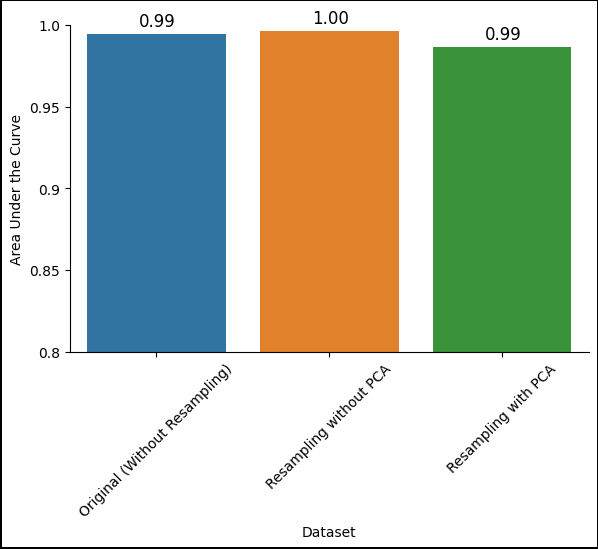

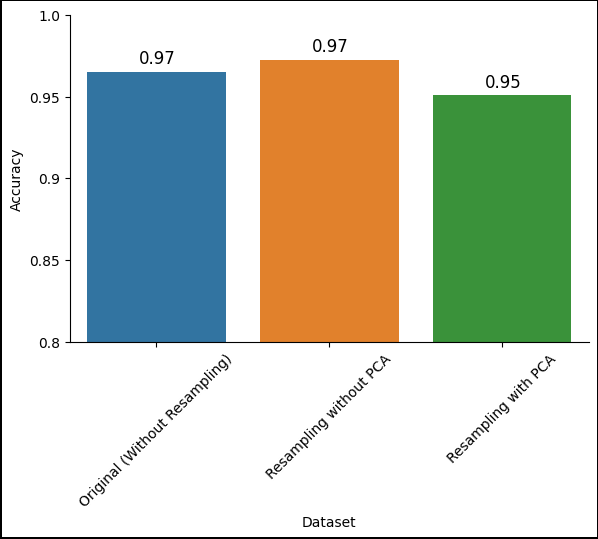

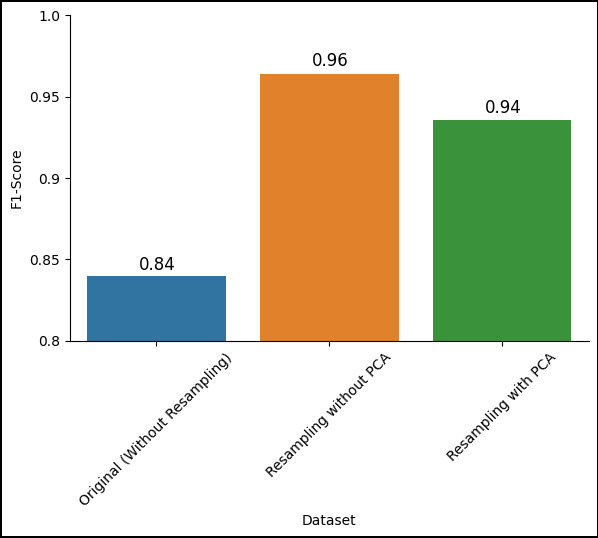

In [ ]:
plot_catplot_for_training_metrics(exp3_training_names, exp3_bbc_auc, "Area Under the Curve", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp3_training_names, exp3_bbc_accuracy, "Accuracy", yticks_interval_space=0.05, yticks_limits=(0.8,1))
plot_catplot_for_training_metrics(exp3_training_names, exp3_bbc_f1, "F1-Score", yticks_interval_space=0.05, yticks_limits=(0.8,1))

## 3.4 Model Performance Analysis

### 3.4.1 Summary of Experiment 1

In [ ]:
models = ["LogReg", "SVC", "KNN", "SGD", "GNB", "DT", "RF", "ET", "XGB", "BB"]

log_reg_df = pd.DataFrame.from_dict({
  "model": [models[0]] * 3,
  "dataset": exp1_training_names,
  "auc": log_reg_auc,
  "f1": log_reg_f1,
  "accuracy": log_reg_accuracy,
})

svc_df = pd.DataFrame.from_dict({
  "model": [models[1]] * 3,
  "dataset": exp1_training_names,
  "auc": svc_auc,
  "f1": svc_f1,
  "accuracy": svc_accuracy,
})

knn_df = pd.DataFrame.from_dict({
  "model": [models[2]] * 3,
  "dataset": exp1_training_names,
  "auc": knn_auc,
  "f1": knn_f1,
  "accuracy": knn_accuracy,
})

sgdc_df = pd.DataFrame.from_dict({
  "model": [models[3]] * 3,
  "dataset": exp1_training_names,
  "auc": sgdc_auc,
  "f1": sgdc_f1,
  "accuracy": sgdc_accuracy,
})

gnb_df = pd.DataFrame.from_dict({
  "model": [models[4]] * 3,
  "dataset": exp1_training_names,
  "auc": gnb_auc,
  "f1": gnb_f1,
  "accuracy": gnb_accuracy,
})

dtc_df = pd.DataFrame.from_dict({
  "model": [models[5]] * 3,
  "dataset": exp1_training_names,
  "auc": dtc_auc,
  "f1": dtc_f1,
  "accuracy": dtc_accuracy,
})

rfc_df = pd.DataFrame.from_dict({
  "model": [models[6]] * 3,
  "dataset": exp1_training_names,
  "auc": rfc_auc,
  "f1": rfc_f1,
  "accuracy": rfc_accuracy,
})

etc_df = pd.DataFrame.from_dict({
  "model": [models[7]] * 3,
  "dataset": exp1_training_names,
  "auc": etc_auc,
  "f1": etc_f1,
  "accuracy": etc_accuracy,
})

xgbc_df = pd.DataFrame.from_dict({
  "model": [models[8]] * 3,
  "dataset": exp1_training_names,
  "auc": xgbc_auc,
  "f1": xgbc_f1,
  "accuracy": xgbc_accuracy,
})

bbc_df = pd.DataFrame.from_dict({
  "model": [models[9]] * 3,
  "dataset": exp1_training_names,
  "auc": bbc_auc,
  "f1": bbc_f1,
  "accuracy": bbc_accuracy,
})

In [ ]:
exp1_summary_df = pd.concat([log_reg_df, svc_df, knn_df, sgdc_df, gnb_df, dtc_df, rfc_df, etc_df, xgbc_df, bbc_df], ignore_index=True)

In [ ]:
# sns.set(rc={'figure.figsize':(20, 9)})
# exp1_summary_barplot = sns.barplot(data=exp1_summary_df, x="model", y="auc", hue="dataset")
# plt.title('Area Under the Curve - Experiment 1')
# sns.reset_orig()

In [ ]:
# sns.set(rc={'figure.figsize':(20, 9)})
# exp1_summary_barplot = sns.barplot(data=exp1_summary_df, x="model", y="accuracy", hue="dataset")
# plt.title('Accuracy - Experiment 1')
# sns.reset_orig()

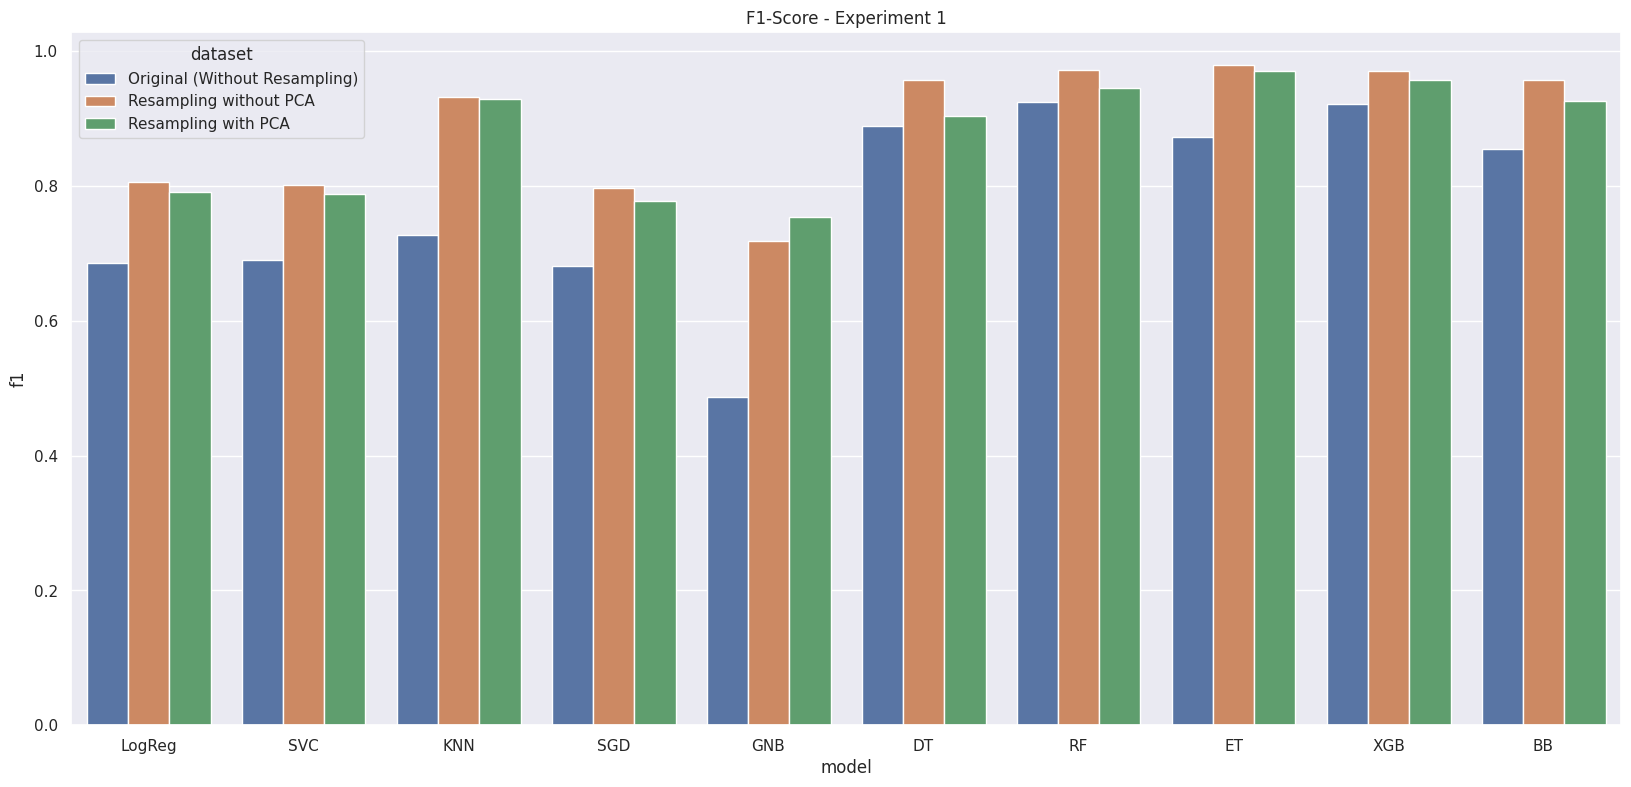

In [ ]:
sns.set(rc={'figure.figsize':(20, 9)})
exp1_summary_barplot = sns.barplot(data=exp1_summary_df, x="model", y="f1", hue="dataset")
plt.title('F1-Score - Experiment 1')
sns.reset_orig()

In [ ]:
print("F1-Scores - Experiment 1")
print("========================")
print('Random Forest    - Dataset1 (Original Without Resampling): {0:.4f}'.format(rfc_f1[0]))
print('Extra Trees      - Dataset1 (Original Without Resampling): {0:.4f}'.format(etc_f1[0]))
print('XGBoost          - Dataset1 (Original Without Resampling): {0:.4f}'.format(xgbc_f1[0]))
print('Balanced Bagging - Dataset1 (Original Without Resampling): {0:.4f}'.format(bbc_f1[0]))
print()
print('Random Forest    - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(rfc_f1[1]))
print('Extra Trees      - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(etc_f1[1]))
print('XGBoost          - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(xgbc_f1[1]))
print('Balanced Bagging - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(bbc_f1[1]))
print()
print('Random Forest    - Dataset3 (With Resampling With PCA):    {0:.4f}'.format(rfc_f1[2]))
print('Extra Trees      - Dataset3 (With Resampling With PCA):    {0:.4f}'.format(etc_f1[2]))
print('XGBoost          - Dataset3 (With Resampling With PCA):    {0:.4f}'.format(xgbc_f1[2]))
print('Balanced Bagging - Dataset3 (With Resampling With PCA):    {0:.4f}'.format(bbc_f1[2]))

F1-Scores - Experiment 1
Random Forest    - Dataset1 (Original Without Resampling): 0.9245
Extra Trees      - Dataset1 (Original Without Resampling): 0.8728
XGBoost          - Dataset1 (Original Without Resampling): 0.9218
Balanced Bagging - Dataset1 (Original Without Resampling): 0.8544

Random Forest    - Dataset2 (With Resampling Without PCA): 0.9717
Extra Trees      - Dataset2 (With Resampling Without PCA): 0.9792
XGBoost          - Dataset2 (With Resampling Without PCA): 0.9713
Balanced Bagging - Dataset2 (With Resampling Without PCA): 0.9572

Random Forest    - Dataset3 (With Resampling With PCA):    0.9462
Extra Trees      - Dataset3 (With Resampling With PCA):    0.9705
XGBoost          - Dataset3 (With Resampling With PCA):    0.9567
Balanced Bagging - Dataset3 (With Resampling With PCA):    0.9263


### 3.4.2 Summary of Experiment 2

In [ ]:
models = ["LogReg", "SVC", "KNN", "SGD", "GNB", "DT", "RF", "ET", "XGB", "BB"]

exp2_log_reg_df = pd.DataFrame.from_dict({
  "model": [models[0]] * 3,
  "dataset": exp2_training_names,
  "auc": exp2_log_reg_auc,
  "f1": exp2_log_reg_f1,
  "accuracy": exp2_log_reg_accuracy,
})

exp2_svc_df = pd.DataFrame.from_dict({
  "model": [models[1]] * 3,
  "dataset": exp2_training_names,
  "auc": exp2_svc_auc,
  "f1": exp2_svc_f1,
  "accuracy": exp2_svc_accuracy,
})

exp2_knn_df = pd.DataFrame.from_dict({
  "model": [models[2]] * 3,
  "dataset": exp2_training_names,
  "auc": exp2_knn_auc,
  "f1": exp2_knn_f1,
  "accuracy": exp2_knn_accuracy,
})

exp2_sgdc_df = pd.DataFrame.from_dict({
  "model": [models[3]] * 3,
  "dataset": exp2_training_names,
  "auc": exp2_sgdc_auc,
  "f1": exp2_sgdc_f1,
  "accuracy": exp2_sgdc_accuracy,
})

exp2_gnb_df = pd.DataFrame.from_dict({
  "model": [models[4]] * 3,
  "dataset": exp2_training_names,
  "auc": exp2_gnb_auc,
  "f1": exp2_gnb_f1,
  "accuracy": exp2_gnb_accuracy,
})

exp2_dtc_df = pd.DataFrame.from_dict({
  "model": [models[5]] * 3,
  "dataset": exp2_training_names,
  "auc": exp2_dtc_auc,
  "f1": exp2_dtc_f1,
  "accuracy": exp2_dtc_accuracy,
})

exp2_rfc_df = pd.DataFrame.from_dict({
  "model": [models[6]] * 3,
  "dataset": exp2_training_names,
  "auc": exp2_rfc_auc,
  "f1": exp2_rfc_f1,
  "accuracy": exp2_rfc_accuracy,
})

exp2_etc_df = pd.DataFrame.from_dict({
  "model": [models[7]] * 3,
  "dataset": exp2_training_names,
  "auc": exp2_etc_auc,
  "f1": exp2_etc_f1,
  "accuracy": exp2_etc_accuracy,
})

exp2_xgbc_df = pd.DataFrame.from_dict({
  "model": [models[8]] * 3,
  "dataset": exp2_training_names,
  "auc": exp2_xgbc_auc,
  "f1": exp2_xgbc_f1,
  "accuracy": exp2_xgbc_accuracy,
})

exp2_bbc_df = pd.DataFrame.from_dict({
  "model": [models[9]] * 3,
  "dataset": exp2_training_names,
  "auc": exp2_bbc_auc,
  "f1": exp2_bbc_f1,
  "accuracy": exp2_bbc_accuracy,
})

In [ ]:
exp2_summary_df = pd.concat([exp2_log_reg_df, exp2_svc_df, exp2_knn_df, exp2_sgdc_df, exp2_gnb_df, exp2_dtc_df, exp2_rfc_df, exp2_etc_df, exp2_xgbc_df, exp2_bbc_df], ignore_index=True)

In [ ]:
# sns.set(rc={'figure.figsize':(20, 9)})
# exp2_summary_barplot = sns.barplot(data=exp2_summary_df, x="model", y="auc", hue="dataset")
# plt.title('Area Under the Curve - Experiment 2')
# sns.reset_orig()

In [ ]:
# sns.set(rc={'figure.figsize':(20, 9)})
# exp2_summary_barplot = sns.barplot(data=exp2_summary_df, x="model", y="accuracy", hue="dataset")
# plt.title('Accuracy - Experiment 2')
# sns.reset_orig()

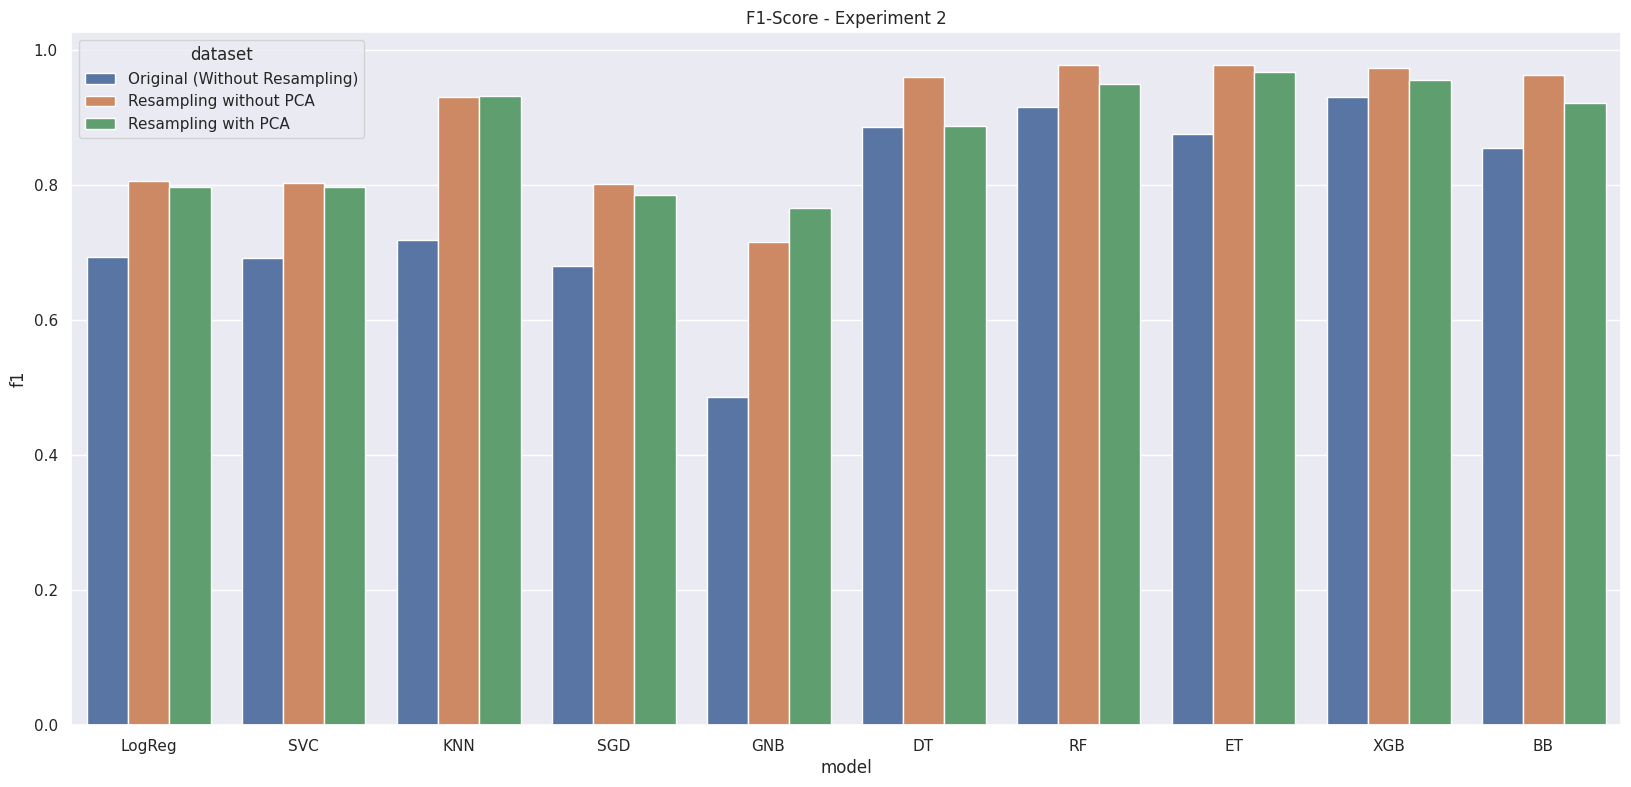

In [ ]:
sns.set(rc={'figure.figsize':(20, 9)})
exp2_summary_barplot = sns.barplot(data=exp2_summary_df, x="model", y="f1", hue="dataset")
plt.title('F1-Score - Experiment 2')
sns.reset_orig()

In [ ]:
print("F1-Scores - Experiment 2")
print("========================")
print('Random Forest    - Dataset1 (Original Without Resampling): {0:.4f}'.format(exp2_rfc_f1[0]))
print('Extra Trees      - Dataset1 (Original Without Resampling): {0:.4f}'.format(exp2_etc_f1[0]))
print('XGBoost          - Dataset1 (Original Without Resampling): {0:.4f}'.format(exp2_xgbc_f1[0]))
print('Balanced Bagging - Dataset1 (Original Without Resampling): {0:.4f}'.format(exp2_bbc_f1[0]))
print()
print('Random Forest    - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(exp2_rfc_f1[1]))
print('Extra Trees      - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(exp2_etc_f1[1]))
print('XGBoost          - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(exp2_xgbc_f1[1]))
print('Balanced Bagging - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(exp2_bbc_f1[1]))
print()
print('Random Forest    - Dataset3 (With Resampling With PCA):    {0:.4f}'.format(exp2_rfc_f1[2]))
print('Extra Trees      - Dataset3 (With Resampling With PCA):    {0:.4f}'.format(exp2_etc_f1[2]))
print('XGBoost          - Dataset3 (With Resampling With PCA):    {0:.4f}'.format(exp2_xgbc_f1[2]))
print('Balanced Bagging - Dataset3 (With Resampling With PCA):    {0:.4f}'.format(exp2_bbc_f1[2]))

F1-Scores - Experiment 2
Random Forest    - Dataset1 (Original Without Resampling): 0.9143
Extra Trees      - Dataset1 (Original Without Resampling): 0.8748
XGBoost          - Dataset1 (Original Without Resampling): 0.9298
Balanced Bagging - Dataset1 (Original Without Resampling): 0.8549

Random Forest    - Dataset2 (With Resampling Without PCA): 0.9766
Extra Trees      - Dataset2 (With Resampling Without PCA): 0.9768
XGBoost          - Dataset2 (With Resampling Without PCA): 0.9728
Balanced Bagging - Dataset2 (With Resampling Without PCA): 0.9626

Random Forest    - Dataset3 (With Resampling With PCA):    0.9497
Extra Trees      - Dataset3 (With Resampling With PCA):    0.9667
XGBoost          - Dataset3 (With Resampling With PCA):    0.9555
Balanced Bagging - Dataset3 (With Resampling With PCA):    0.9204


### 3.4.3 Summary of Experiment 3

In [ ]:
models = ["LogReg", "SVC", "KNN", "SGD", "GNB", "DT", "RF", "ET", "XGB", "BB"]

exp3_log_reg_df = pd.DataFrame.from_dict({
  "model": [models[0]] * 3,
  "dataset": exp3_training_names,
  "auc": exp3_log_reg_auc,
  "f1": exp3_log_reg_f1,
  "accuracy": exp3_log_reg_accuracy,
})

exp3_svc_df = pd.DataFrame.from_dict({
  "model": [models[1]] * 3,
  "dataset": exp3_training_names,
  "auc": exp3_svc_auc,
  "f1": exp3_svc_f1,
  "accuracy": exp3_svc_accuracy,
})

exp3_knn_df = pd.DataFrame.from_dict({
  "model": [models[2]] * 3,
  "dataset": exp3_training_names,
  "auc": exp3_knn_auc,
  "f1": exp3_knn_f1,
  "accuracy": exp3_knn_accuracy,
})

exp3_sgdc_df = pd.DataFrame.from_dict({
  "model": [models[3]] * 3,
  "dataset": exp3_training_names,
  "auc": exp3_sgdc_auc,
  "f1": exp3_sgdc_f1,
  "accuracy": exp3_sgdc_accuracy,
})

exp3_gnb_df = pd.DataFrame.from_dict({
  "model": [models[4]] * 3,
  "dataset": exp3_training_names,
  "auc": exp3_gnb_auc,
  "f1": exp3_gnb_f1,
  "accuracy": exp3_gnb_accuracy,
})

exp3_dtc_df = pd.DataFrame.from_dict({
  "model": [models[5]] * 3,
  "dataset": exp3_training_names,
  "auc": exp3_dtc_auc,
  "f1": exp3_dtc_f1,
  "accuracy": exp3_dtc_accuracy,
})

exp3_rfc_df = pd.DataFrame.from_dict({
  "model": [models[6]] * 3,
  "dataset": exp3_training_names,
  "auc": exp3_rfc_auc,
  "f1": exp3_rfc_f1,
  "accuracy": exp3_rfc_accuracy,
})

exp3_etc_df = pd.DataFrame.from_dict({
  "model": [models[7]] * 3,
  "dataset": exp3_training_names,
  "auc": exp3_etc_auc,
  "f1": exp3_etc_f1,
  "accuracy": exp3_etc_accuracy,
})

exp3_xgbc_df = pd.DataFrame.from_dict({
  "model": [models[8]] * 3,
  "dataset": exp3_training_names,
  "auc": exp3_xgbc_auc,
  "f1": exp3_xgbc_f1,
  "accuracy": exp3_xgbc_accuracy,
})

exp3_bbc_df = pd.DataFrame.from_dict({
  "model": [models[9]] * 3,
  "dataset": exp3_training_names,
  "auc": exp3_bbc_auc,
  "f1": exp3_bbc_f1,
  "accuracy": exp3_bbc_accuracy,
})

In [ ]:
exp3_summary_df = pd.concat([exp3_log_reg_df, exp3_svc_df, exp3_knn_df, exp3_sgdc_df, exp3_gnb_df, exp3_dtc_df, exp3_rfc_df, exp3_etc_df, exp3_xgbc_df, exp3_bbc_df], ignore_index=True)

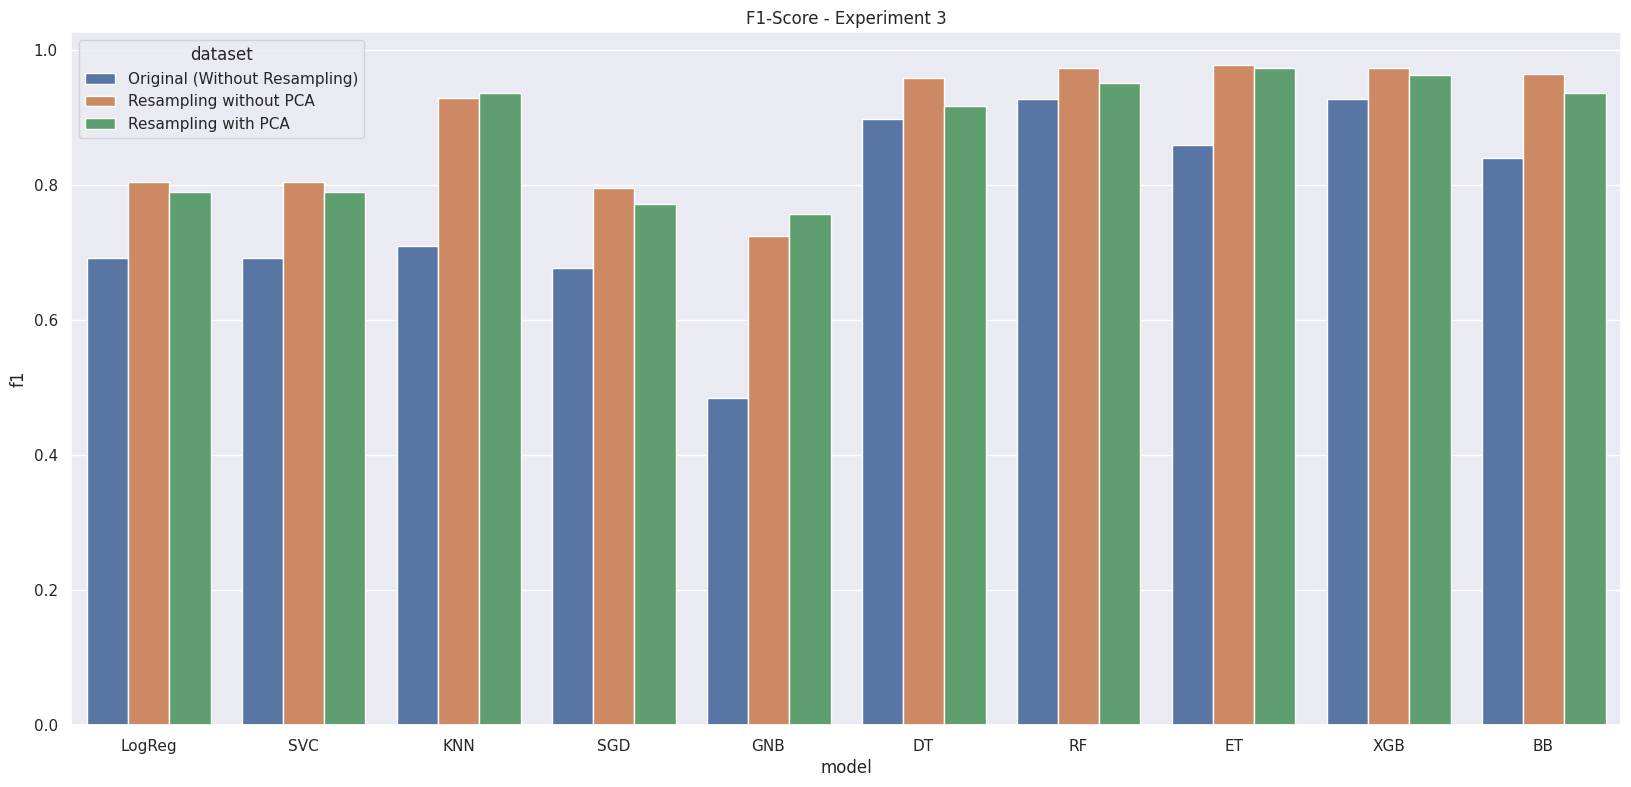

In [ ]:
sns.set(rc={'figure.figsize':(20, 9)})
exp3_summary_barplot = sns.barplot(data=exp3_summary_df, x="model", y="f1", hue="dataset")
plt.title('F1-Score - Experiment 3')
sns.reset_orig()

In [ ]:
print("F1-Scores - Experiment 3")
print("========================")
print('Random Forest    - Dataset1 (Original Without Resampling): {0:.4f}'.format(exp3_rfc_f1[0]))
print('Extra Trees      - Dataset1 (Original Without Resampling): {0:.4f}'.format(exp3_etc_f1[0]))
print('XGBoost          - Dataset1 (Original Without Resampling): {0:.4f}'.format(exp3_xgbc_f1[0]))
print('Balanced Bagging - Dataset1 (Original Without Resampling): {0:.4f}'.format(exp3_bbc_f1[0]))
print()
print('Random Forest    - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(exp3_rfc_f1[1]))
print('Extra Trees      - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(exp3_etc_f1[1]))
print('XGBoost          - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(exp3_xgbc_f1[1]))
print('Balanced Bagging - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(exp3_bbc_f1[1]))
print()
print('Random Forest    - Dataset3 (With Resampling With PCA):    {0:.4f}'.format(exp3_rfc_f1[2]))
print('Extra Trees      - Dataset3 (With Resampling With PCA):    {0:.4f}'.format(exp3_etc_f1[2]))
print('XGBoost          - Dataset3 (With Resampling With PCA):    {0:.4f}'.format(exp3_xgbc_f1[2]))
print('Balanced Bagging - Dataset3 (With Resampling With PCA):    {0:.4f}'.format(exp3_bbc_f1[2]))

F1-Scores - Experiment 3
Random Forest    - Dataset1 (Original Without Resampling): 0.9277
Extra Trees      - Dataset1 (Original Without Resampling): 0.8592
XGBoost          - Dataset1 (Original Without Resampling): 0.9275
Balanced Bagging - Dataset1 (Original Without Resampling): 0.8395

Random Forest    - Dataset2 (With Resampling Without PCA): 0.9731
Extra Trees      - Dataset2 (With Resampling Without PCA): 0.9773
XGBoost          - Dataset2 (With Resampling Without PCA): 0.9728
Balanced Bagging - Dataset2 (With Resampling Without PCA): 0.9640

Random Forest    - Dataset3 (With Resampling With PCA):    0.9512
Extra Trees      - Dataset3 (With Resampling With PCA):    0.9726
XGBoost          - Dataset3 (With Resampling With PCA):    0.9626
Balanced Bagging - Dataset3 (With Resampling With PCA):    0.9356


## 3.5 Voting Classifier

### 3.5.1 Experiment 1

In [ ]:
exp1_voting_accuracy = []
exp1_voting_precision = []
exp1_voting_recall = []
exp1_voting_f1 = []
exp1_voting_auc = []

for i in range(len(exp1_training_data)):
  exp1_voting = VotingClassifier(
      estimators=[
                  ('exp1_etc', exp1_etc),
                  ('exp1_xgbc', exp1_xgbc),
                  ('exp1_bbc', exp1_bbc)
      ], voting='soft', n_jobs=4)
  exp1_voting.fit(exp1_training_data[i], exp1_training_labels[i])

  exp1_voting_auc.append(cross_val_score(exp1_voting, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="roc_auc", n_jobs=4).mean())
  exp1_voting_accuracy.append(cross_val_score(exp1_voting, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="accuracy", n_jobs=4).mean())
  exp1_voting_precision.append(cross_val_score(exp1_voting, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="precision", n_jobs=4).mean())
  exp1_voting_recall.append(cross_val_score(exp1_voting, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="recall", n_jobs=4).mean())
  exp1_voting_f1.append(cross_val_score(exp1_voting, exp1_training_data[i], exp1_training_labels[i], cv=5, scoring="f1", n_jobs=4).mean())

### 3.5.2 Experiment 2

In [ ]:
exp2_voting_accuracy = []
exp2_voting_precision = []
exp2_voting_recall = []
exp2_voting_f1 = []
exp2_voting_auc = []

for i in range(len(exp2_training_data)):
  exp2_voting = VotingClassifier(
      estimators=[
                  ('exp2_etc', exp2_etc),
                  ('exp2_xgbc', exp2_xgbc),
                  ('exp2_bbc', exp2_bbc)
      ], voting='soft', n_jobs=4)
  exp2_voting.fit(exp2_training_data[i], exp2_training_labels[i])

  exp2_voting_auc.append(cross_val_score(exp2_voting, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="roc_auc", n_jobs=4).mean())
  exp2_voting_accuracy.append(cross_val_score(exp2_voting, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="accuracy", n_jobs=4).mean())
  exp2_voting_precision.append(cross_val_score(exp2_voting, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="precision", n_jobs=4).mean())
  exp2_voting_recall.append(cross_val_score(exp2_voting, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="recall", n_jobs=4).mean())
  exp2_voting_f1.append(cross_val_score(exp2_voting, exp2_training_data[i], exp2_training_labels[i], cv=5, scoring="f1", n_jobs=4).mean())

### 3.5.3 Experiment 3

In [ ]:
exp3_voting_accuracy = []
exp3_voting_precision = []
exp3_voting_recall = []
exp3_voting_f1 = []
exp3_voting_auc = []

for i in range(len(exp3_training_data)):
  exp3_voting = VotingClassifier(
      estimators=[
                  ('exp3_etc', exp3_etc),
                  ('exp3_xgbc', exp3_xgbc),
                  ('exp3_bbc', exp3_bbc)
      ], voting='soft', n_jobs=4)
  exp3_voting.fit(exp3_training_data[i], exp3_training_labels[i])

  exp3_voting_auc.append(cross_val_score(exp3_voting, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="roc_auc", n_jobs=4).mean())
  exp3_voting_accuracy.append(cross_val_score(exp3_voting, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="accuracy", n_jobs=4).mean())
  exp3_voting_precision.append(cross_val_score(exp3_voting, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="precision", n_jobs=4).mean())
  exp3_voting_recall.append(cross_val_score(exp3_voting, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="recall", n_jobs=4).mean())
  exp3_voting_f1.append(cross_val_score(exp3_voting, exp3_training_data[i], exp3_training_labels[i], cv=5, scoring="f1", n_jobs=4).mean())

## 3.6 Best Model Selection

In [ ]:
models = ["Extra Trees", "XGBoost", "Balanced Bagging", "Voting"]

In [ ]:
exp1_etc_df = pd.DataFrame.from_dict({
  "model": [models[0]] * 3,
  "dataset": exp1_training_names,
  "auc": etc_auc,
  "f1": etc_f1,
  "accuracy": etc_accuracy,
})

exp1_xgbc_df = pd.DataFrame.from_dict({
  "model": [models[1]] * 3,
  "dataset": exp1_training_names,
  "auc": xgbc_auc,
  "f1": xgbc_f1,
  "accuracy": xgbc_accuracy,
})

exp1_bbc_df = pd.DataFrame.from_dict({
  "model": [models[2]] * 3,
  "dataset": exp1_training_names,
  "auc": bbc_auc,
  "f1": bbc_f1,
  "accuracy": bbc_accuracy,
})

exp1_voting_df = pd.DataFrame.from_dict({
  "model": [models[3]] * 3,
  "dataset": exp1_training_names,
  "auc": exp1_voting_auc,
  "f1": exp1_voting_f1,
  "accuracy": exp1_voting_accuracy,
})

exp2_etc_df = pd.DataFrame.from_dict({
  "model": [models[0]] * 3,
  "dataset": exp2_training_names,
  "auc": exp2_etc_auc,
  "f1": exp2_etc_f1,
  "accuracy": exp2_etc_accuracy,
})

exp2_xgbc_df = pd.DataFrame.from_dict({
  "model": [models[1]] * 3,
  "dataset": exp2_training_names,
  "auc": exp2_xgbc_auc,
  "f1": exp2_xgbc_f1,
  "accuracy": exp2_xgbc_accuracy,
})

exp2_bbc_df = pd.DataFrame.from_dict({
  "model": [models[2]] * 3,
  "dataset": exp2_training_names,
  "auc": exp2_bbc_auc,
  "f1": exp2_bbc_f1,
  "accuracy": exp2_bbc_accuracy,
})

exp2_voting_df = pd.DataFrame.from_dict({
  "model": [models[3]] * 3,
  "dataset": exp2_training_names,
  "auc": exp2_voting_auc,
  "f1": exp2_voting_f1,
  "accuracy": exp2_voting_accuracy,
})

exp3_etc_df = pd.DataFrame.from_dict({
  "model": [models[0]] * 3,
  "dataset": exp3_training_names,
  "auc": exp3_etc_auc,
  "f1": exp3_etc_f1,
  "accuracy": exp3_etc_accuracy,
})

exp3_xgbc_df = pd.DataFrame.from_dict({
  "model": [models[1]] * 3,
  "dataset": exp3_training_names,
  "auc": exp3_xgbc_auc,
  "f1": exp3_xgbc_f1,
  "accuracy": exp3_xgbc_accuracy,
})

exp3_bbc_df = pd.DataFrame.from_dict({
  "model": [models[2]] * 3,
  "dataset": exp3_training_names,
  "auc": exp3_bbc_auc,
  "f1": exp3_bbc_f1,
  "accuracy": exp3_bbc_accuracy,
})

exp3_voting_df = pd.DataFrame.from_dict({
  "model": [models[3]] * 3,
  "dataset": exp3_training_names,
  "auc": exp3_voting_auc,
  "f1": exp3_voting_f1,
  "accuracy": exp3_voting_accuracy,
})

In [ ]:
exp1_voting_summary_df = pd.concat([exp1_etc_df, exp1_xgbc_df, exp1_bbc_df, exp1_voting_df], ignore_index=True)

In [ ]:
exp2_voting_summary_df = pd.concat([exp2_etc_df, exp2_xgbc_df, exp2_bbc_df, exp2_voting_df], ignore_index=True)

In [ ]:
exp3_voting_summary_df = pd.concat([exp3_etc_df, exp3_xgbc_df, exp3_bbc_df, exp3_voting_df], ignore_index=True)

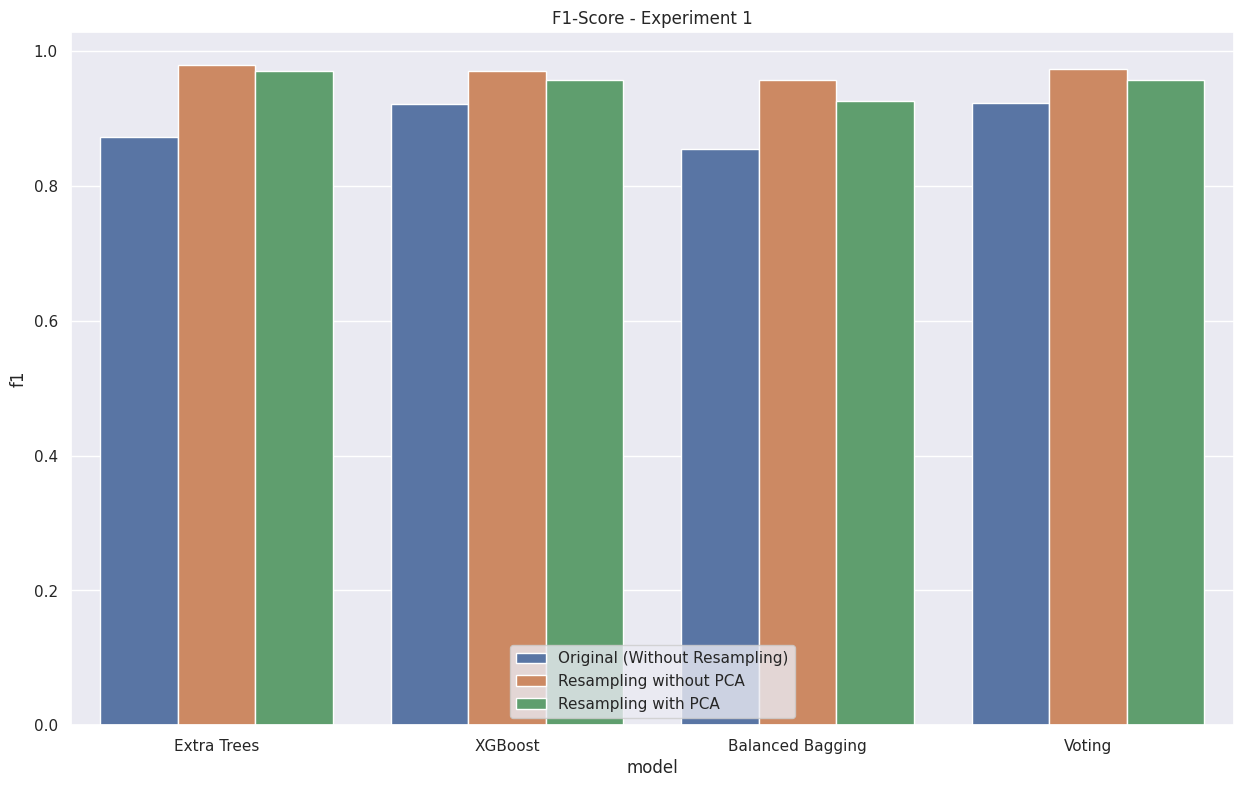

In [ ]:
sns.set(rc={'figure.figsize':(15, 9)})
exp1_voting_summary_barplot = sns.barplot(data=exp1_voting_summary_df, x="model", y="f1", hue="dataset")
plt.title('F1-Score - Experiment 1')
plt.legend(loc="lower center")
sns.reset_orig()

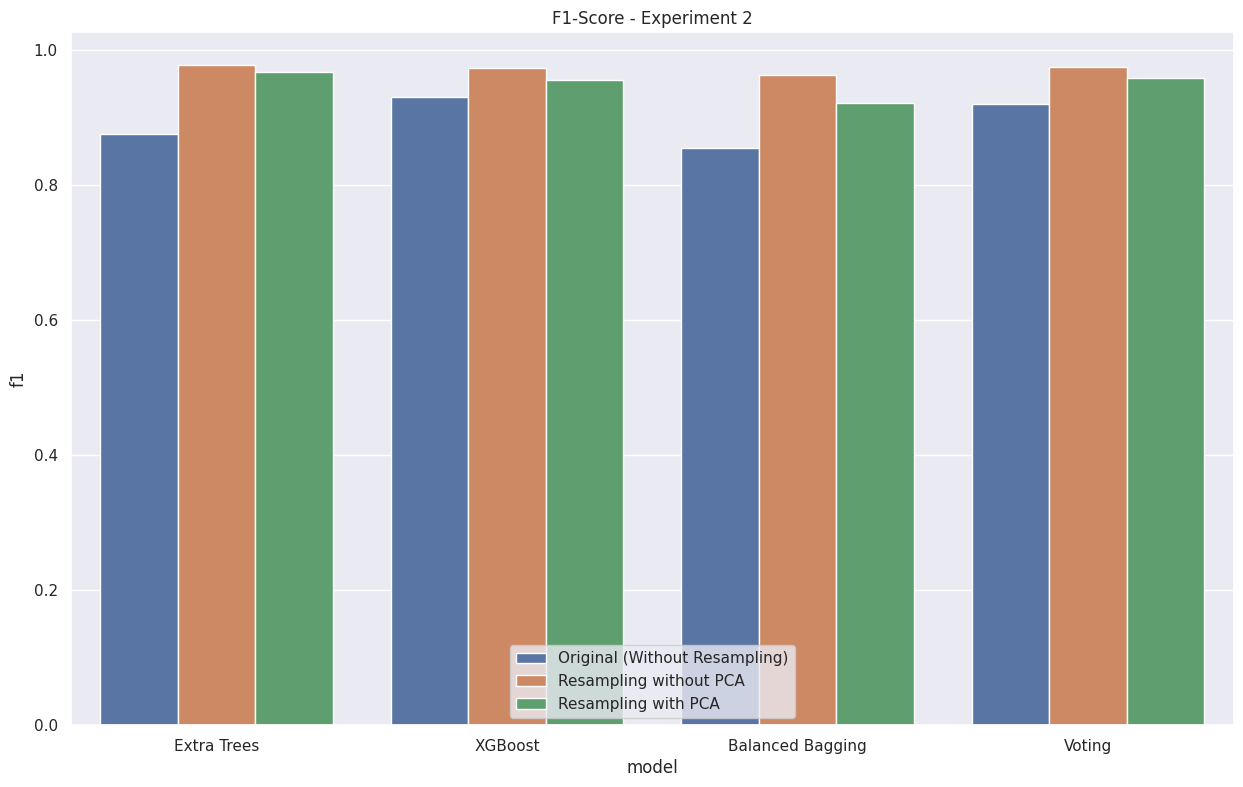

In [ ]:
sns.set(rc={'figure.figsize':(15, 9)})
exp2_voting_summary_barplot = sns.barplot(data=exp2_voting_summary_df, x="model", y="f1", hue="dataset")
plt.title('F1-Score - Experiment 2')
plt.legend(loc="lower center")
sns.reset_orig()

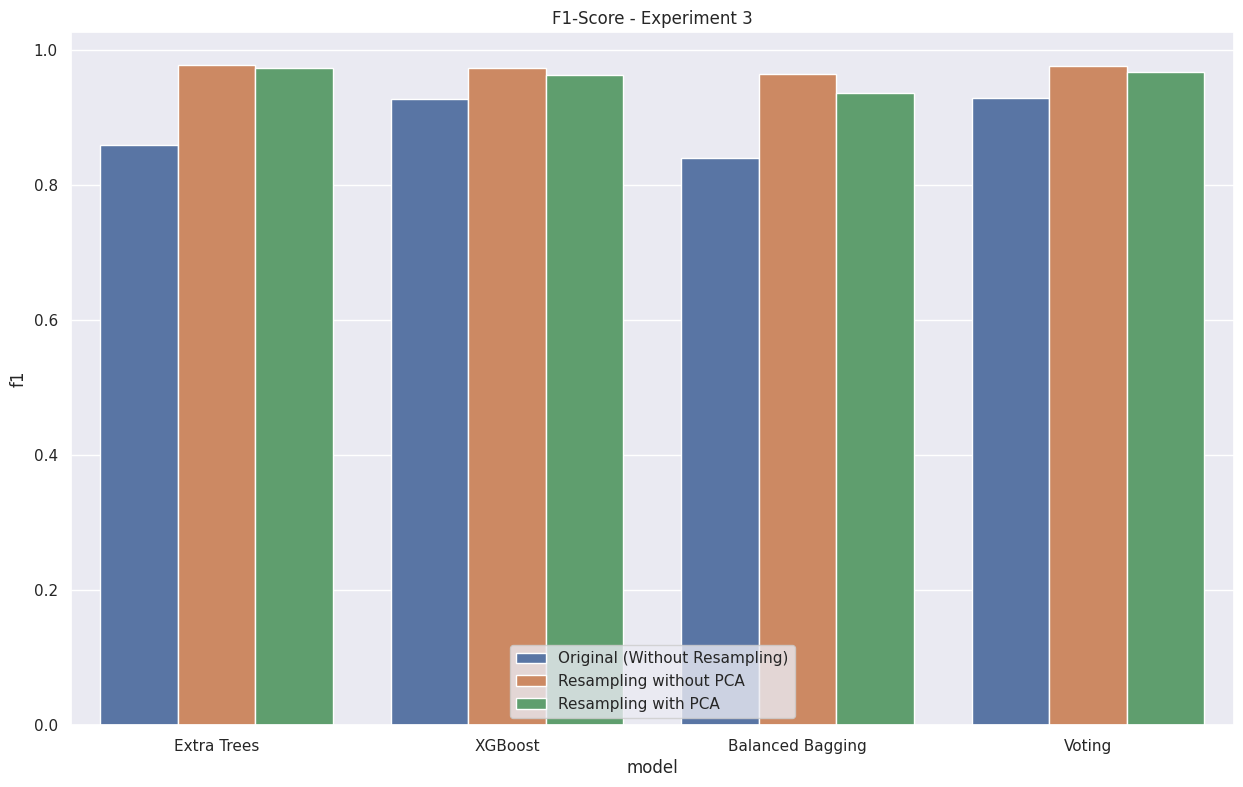

In [ ]:
sns.set(rc={'figure.figsize':(15, 9)})
exp3_voting_summary_barplot = sns.barplot(data=exp3_voting_summary_df, x="model", y="f1", hue="dataset")
plt.title('F1-Score - Experiment 3')
plt.legend(loc="lower center")
sns.reset_orig()

In [ ]:
print("F1-Scores - Experiment 1")
print("========================")
print('Extra Trees      - Dataset1 (Original Without Resampling): {0:.4f}'.format(etc_f1[0]))
print('XGBoost          - Dataset1 (Original Without Resampling): {0:.4f}'.format(xgbc_f1[0]))
print('Balanced Bagging - Dataset1 (Original Without Resampling): {0:.4f}'.format(bbc_f1[0]))
print('Soft Voting      - Dataset1 (Original Without Resampling): {0:.4f}'.format(exp1_voting_f1[0]))
print()
print('Extra Trees      - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(etc_f1[1]))
print('XGBoost          - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(xgbc_f1[1]))
print('Balanced Bagging - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(bbc_f1[1]))
print('Soft Voting      - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(exp1_voting_f1[1]))
print()
print('Extra Trees      - Dataset3 (With Resampling With PCA):    {0:.4f}'.format(etc_f1[2]))
print('XGBoost          - Dataset3 (With Resampling With PCA):    {0:.4f}'.format(xgbc_f1[2]))
print('Balanced Bagging - Dataset3 (With Resampling With PCA):    {0:.4f}'.format(bbc_f1[2]))
print('Soft Voting      - Dataset3 (With Resampling With PCA):    {0:.4f}'.format(exp1_voting_f1[2]))

F1-Scores - Experiment 1
Extra Trees      - Dataset1 (Original Without Resampling): 0.8728
XGBoost          - Dataset1 (Original Without Resampling): 0.9218
Balanced Bagging - Dataset1 (Original Without Resampling): 0.8544
Soft Voting      - Dataset1 (Original Without Resampling): 0.9225

Extra Trees      - Dataset2 (With Resampling Without PCA): 0.9792
XGBoost          - Dataset2 (With Resampling Without PCA): 0.9713
Balanced Bagging - Dataset2 (With Resampling Without PCA): 0.9572
Soft Voting      - Dataset2 (With Resampling Without PCA): 0.9737

Extra Trees      - Dataset3 (With Resampling With PCA):    0.9705
XGBoost          - Dataset3 (With Resampling With PCA):    0.9567
Balanced Bagging - Dataset3 (With Resampling With PCA):    0.9263
Soft Voting      - Dataset3 (With Resampling With PCA):    0.9571


In [ ]:
print("F1-Scores - Experiment 2")
print("========================")
print('Extra Trees      - Dataset1 (Original Without Resampling): {0:.4f}'.format(exp2_etc_f1[0]))
print('XGBoost          - Dataset1 (Original Without Resampling): {0:.4f}'.format(exp2_xgbc_f1[0]))
print('Balanced Bagging - Dataset1 (Original Without Resampling): {0:.4f}'.format(exp2_bbc_f1[0]))
print('Soft Voting      - Dataset1 (Original Without Resampling): {0:.4f}'.format(exp2_voting_f1[0]))
print()
print('Extra Trees      - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(exp2_etc_f1[1]))
print('XGBoost          - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(exp2_xgbc_f1[1]))
print('Balanced Bagging - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(exp2_bbc_f1[1]))
print('Soft Voting      - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(exp2_voting_f1[1]))
print()
print('Extra Trees      - Dataset3 (With Resampling With PCA):    {0:.4f}'.format(exp2_etc_f1[2]))
print('XGBoost          - Dataset3 (With Resampling With PCA):    {0:.4f}'.format(exp2_xgbc_f1[2]))
print('Balanced Bagging - Dataset3 (With Resampling With PCA):    {0:.4f}'.format(exp2_bbc_f1[2]))
print('Soft Voting      - Dataset3 (With Resampling With PCA):    {0:.4f}'.format(exp2_voting_f1[2]))

F1-Scores - Experiment 2
Extra Trees      - Dataset1 (Original Without Resampling): 0.8748
XGBoost          - Dataset1 (Original Without Resampling): 0.9298
Balanced Bagging - Dataset1 (Original Without Resampling): 0.8549
Soft Voting      - Dataset1 (Original Without Resampling): 0.9194

Extra Trees      - Dataset2 (With Resampling Without PCA): 0.9768
XGBoost          - Dataset2 (With Resampling Without PCA): 0.9728
Balanced Bagging - Dataset2 (With Resampling Without PCA): 0.9626
Soft Voting      - Dataset2 (With Resampling Without PCA): 0.9743

Extra Trees      - Dataset3 (With Resampling With PCA):    0.9667
XGBoost          - Dataset3 (With Resampling With PCA):    0.9555
Balanced Bagging - Dataset3 (With Resampling With PCA):    0.9204
Soft Voting      - Dataset3 (With Resampling With PCA):    0.9585


In [ ]:
print("F1-Scores - Experiment 3")
print("========================")
print('Extra Trees      - Dataset1 (Original Without Resampling): {0:.4f}'.format(exp3_etc_f1[0]))
print('XGBoost          - Dataset1 (Original Without Resampling): {0:.4f}'.format(exp3_xgbc_f1[0]))
print('Balanced Bagging - Dataset1 (Original Without Resampling): {0:.4f}'.format(exp3_bbc_f1[0]))
print('Soft Voting      - Dataset1 (Original Without Resampling): {0:.4f}'.format(exp3_voting_f1[0]))
print()
print('Extra Trees      - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(exp3_etc_f1[1]))
print('XGBoost          - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(exp3_xgbc_f1[1]))
print('Balanced Bagging - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(exp3_bbc_f1[1]))
print('Soft Voting      - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(exp3_voting_f1[1]))
print()
print('Extra Trees      - Dataset3 (With Resampling With PCA):    {0:.4f}'.format(exp3_etc_f1[2]))
print('XGBoost          - Dataset3 (With Resampling With PCA):    {0:.4f}'.format(exp3_xgbc_f1[2]))
print('Balanced Bagging - Dataset3 (With Resampling With PCA):    {0:.4f}'.format(exp3_bbc_f1[2]))
print('Soft Voting      - Dataset3 (With Resampling With PCA):    {0:.4f}'.format(exp3_voting_f1[2]))

F1-Scores - Experiment 3
Extra Trees      - Dataset1 (Original Without Resampling): 0.8592
XGBoost          - Dataset1 (Original Without Resampling): 0.9275
Balanced Bagging - Dataset1 (Original Without Resampling): 0.8395
Soft Voting      - Dataset1 (Original Without Resampling): 0.9293

Extra Trees      - Dataset2 (With Resampling Without PCA): 0.9773
XGBoost          - Dataset2 (With Resampling Without PCA): 0.9728
Balanced Bagging - Dataset2 (With Resampling Without PCA): 0.9640
Soft Voting      - Dataset2 (With Resampling Without PCA): 0.9756

Extra Trees      - Dataset3 (With Resampling With PCA):    0.9726
XGBoost          - Dataset3 (With Resampling With PCA):    0.9626
Balanced Bagging - Dataset3 (With Resampling With PCA):    0.9356
Soft Voting      - Dataset3 (With Resampling With PCA):    0.9673


## 3.7 Dataset Decision

As we can see, in all experiments the **Dataset1 (Original Without Resampling)** has a little bit lower performance in comparison with the other datasets. Therefore, we decided to eliminate it.

As well, in the **Dataset3 (With Resampling With PCA)** it is clear, that we are losing some information by applying dimensionality reduction. And to be honest, the reduction from 12 features to 8 features didn't come up whether with a significant performance enhancement or with a faster training time. Therefore, we decided to eliminate it.

So, our focus will be on the **Dataset2 (With Resampling Without PCA)** in the following sections.

<br />

Accordingly, We have 3 different Datasets:
  - 1: Experiment 1 - Resampling without PCA
  - 2: Experiment 2 - Resampling without PCA
  - 3: Experiment 3 - Resampling without PCA

As a reminder, we had 3 Experiments:
  - Experiment 1: Having all Cities instead of ZIP Codes
  - Experiment 2: Having Cities with #Records >= 5 (Cities with #Records < 5 would be assigned to `"Other City"` Class)
  - Experiment 3: Having all Counties instead of ZIP Codes

## 3.8 Hyperparameter Tuning

### 3.8.1 Tuning Extra Trees

In [ ]:
extra_trees_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 6, 10],
    'min_samples_leaf': [1, 3, 5, 10],
    'max_features': [None, 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy', "log_loss"]
}
# 3 * 3 * 3 * 4 * 3 * 3 = 972 Candidates

#### 3.8.1.1 Experiment 1

In [ ]:
# exp1_etc_temp = ExtraTreesClassifier(random_state=42, n_jobs=-1)

# exp1_etc_gs = GridSearchCV(
#   estimator=exp1_etc_temp,
#   param_grid=extra_trees_param_grid,
#   cv=5,
#   n_jobs=-1,
#   verbose=4
# )
# fitting_exp1_etc_tuner_start_time = time.time()
# exp1_etc_gs.fit(exp1_training_data[1], exp1_training_labels[1])
# fitting_exp1_etc_tuner_end_time = time.time()

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


In [ ]:
# print("Training took {} for fine-tuning the Extra Trees model".format(datetime.timedelta(seconds=int(fitting_exp1_etc_tuner_end_time - fitting_exp1_etc_tuner_start_time))))

Training took 0:33:50 for fine-tuning the Extra Trees model


It took 33 Minutes (00:33:50) to search the best hyperparameters for this model

In [ ]:
# # Print the best hyperparameters and the corresponding mean cross-validated score
# print("Best Hyperparameters: ", exp1_etc_gs.best_params_)
# print("Best Score: ", exp1_etc_gs.best_score_)

# ### >> Best Hyperparameters:  {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
# ### >> Best Score:  0.9851063829787234

# # Return the best model found during the search
# exp1_etc_tuned = exp1_etc_gs.best_estimator_

Best Hyperparameters:  {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Score:  0.9851063829787234


```json
optimal_hyperparameters = {
  'criterion': 'gini',
  'max_depth': None,
  'max_features': 'sqrt',
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 300
}
```

In [ ]:
exp1_etc_tuned = ExtraTreesClassifier(
    n_estimators=300,
    criterion="gini",
    max_depth=None,
    max_features="sqrt",
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)

exp1_etc_tuned.fit(exp1_training_data[1], exp1_training_labels[1])

ExtraTreesClassifier(n_estimators=300, n_jobs=-1, random_state=42)

In [ ]:
exp1_etc_tuned_auc = cross_val_score(exp1_etc_tuned, exp1_training_data[1], exp1_training_labels[1], cv=5, scoring="roc_auc", n_jobs=4).mean()
exp1_etc_tuned_accuracy = cross_val_score(exp1_etc_tuned, exp1_training_data[1], exp1_training_labels[1], cv=5, scoring="accuracy", n_jobs=4).mean()
exp1_etc_tuned_precision = cross_val_score(exp1_etc_tuned, exp1_training_data[1], exp1_training_labels[1], cv=5, scoring="precision", n_jobs=4).mean()
exp1_etc_tuned_recall = cross_val_score(exp1_etc_tuned, exp1_training_data[1], exp1_training_labels[1], cv=5, scoring="recall", n_jobs=4).mean()
exp1_etc_tuned_f1 = cross_val_score(exp1_etc_tuned, exp1_training_data[1], exp1_training_labels[1], cv=5, scoring="f1", n_jobs=4).mean()

#### 3.8.1.2 Experiment 2

In [ ]:
# exp2_etc_temp = ExtraTreesClassifier(random_state=42, n_jobs=-1)

# exp2_etc_gs = GridSearchCV(
#   estimator=exp2_etc_temp,
#   param_grid=extra_trees_param_grid,
#   cv=5,
#   n_jobs=-1,
#   verbose=4
# )
# fitting_exp2_etc_tuner_start_time = time.time()
# exp2_etc_gs.fit(exp2_training_data[1], exp2_training_labels[1])
# fitting_exp2_etc_tuner_end_time = time.time()

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


In [ ]:
# print("Training took {} for fine-tuning the Extra Trees model".format(datetime.timedelta(seconds=int(fitting_exp2_etc_tuner_end_time - fitting_exp2_etc_tuner_start_time))))

Training took 0:44:43 for fine-tuning the Extra Trees model


It took 44 Minutes (00:44:43) to search the best hyperparameters for this model

In [ ]:
# # Print the best hyperparameters and the corresponding mean cross-validated score
# print("Best Hyperparameters: ", exp2_etc_gs.best_params_)
# print("Best Score: ", exp2_etc_gs.best_score_)

# ### >> Best Hyperparameters:  {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
# ### >> Best Score:  0.9851157974016193

# # Return the best model found during the search
# exp2_etc_tuned = exp2_etc_gs.best_estimator_

Best Hyperparameters:  {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Score:  0.9851157974016193


```json
optimal_hyperparameters = {
  'criterion': 'gini',
  'max_depth': None,
  'max_features': 'sqrt',
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 200
}
```

In [ ]:
exp2_etc_tuned = ExtraTreesClassifier(
    n_estimators=200,
    criterion="gini",
    max_depth=None,
    max_features="sqrt",
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)

exp2_etc_tuned.fit(exp2_training_data[1], exp2_training_labels[1])

ExtraTreesClassifier(n_estimators=200, n_jobs=-1, random_state=42)

In [ ]:
exp2_etc_tuned_auc = cross_val_score(exp2_etc_tuned, exp2_training_data[1], exp2_training_labels[1], cv=5, scoring="roc_auc", n_jobs=4).mean()
exp2_etc_tuned_accuracy = cross_val_score(exp2_etc_tuned, exp2_training_data[1], exp2_training_labels[1], cv=5, scoring="accuracy", n_jobs=4).mean()
exp2_etc_tuned_precision = cross_val_score(exp2_etc_tuned, exp2_training_data[1], exp2_training_labels[1], cv=5, scoring="precision", n_jobs=4).mean()
exp2_etc_tuned_recall = cross_val_score(exp2_etc_tuned, exp2_training_data[1], exp2_training_labels[1], cv=5, scoring="recall", n_jobs=4).mean()
exp2_etc_tuned_f1 = cross_val_score(exp2_etc_tuned, exp2_training_data[1], exp2_training_labels[1], cv=5, scoring="f1", n_jobs=4).mean()

#### 3.8.1.3 Experiment 3

In [ ]:
# exp3_etc_temp = ExtraTreesClassifier(random_state=42, n_jobs=-1)

# exp3_etc_gs = GridSearchCV(
#   estimator=exp3_etc_temp,
#   param_grid=extra_trees_param_grid,
#   cv=5,
#   n_jobs=-1,
#   verbose=4
# )
# fitting_exp3_etc_tuner_start_time = time.time()
# exp3_etc_gs.fit(exp3_training_data[1], exp3_training_labels[1])
# fitting_exp3_etc_tuner_end_time = time.time()

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


In [ ]:
# print("Training took {} for fine-tuning the Extra Trees model".format(datetime.timedelta(seconds=int(fitting_exp3_etc_tuner_end_time - fitting_exp3_etc_tuner_start_time))))

Training took 0:07:17 for fine-tuning the Extra Trees model


It took 7 Minutes (0:07:17) to search the best hyperparameters for this model

In [ ]:
# # Print the best hyperparameters and the corresponding mean cross-validated score
# print("Best Hyperparameters: ", exp3_etc_gs.best_params_)
# print("Best Score: ", exp3_etc_gs.best_score_)


# ### >> Best Hyperparameters:  {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
# ### >> Best Score:  0.9836007130124778

# # Return the best model found during the search
# exp3_etc_tuned = exp3_etc_gs.best_estimator_

Best Hyperparameters:  {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Score:  0.9836007130124778


```json
optimal_hyperparameters = {
  'criterion': 'entropy',
  'max_depth': None,
  'max_features': 'sqrt',
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 300
}
```

In [ ]:
exp3_etc_tuned = ExtraTreesClassifier(
    n_estimators=300,
    criterion="entropy",
    max_depth=None,
    max_features="sqrt",
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)

exp3_etc_tuned.fit(exp3_training_data[1], exp3_training_labels[1])

ExtraTreesClassifier(criterion='entropy', n_estimators=300, n_jobs=-1,
                     random_state=42)

In [ ]:
exp3_etc_tuned_auc = cross_val_score(exp3_etc_tuned, exp3_training_data[1], exp3_training_labels[1], cv=5, scoring="roc_auc", n_jobs=4).mean()
exp3_etc_tuned_accuracy = cross_val_score(exp3_etc_tuned, exp3_training_data[1], exp3_training_labels[1], cv=5, scoring="accuracy", n_jobs=4).mean()
exp3_etc_tuned_precision = cross_val_score(exp3_etc_tuned, exp3_training_data[1], exp3_training_labels[1], cv=5, scoring="precision", n_jobs=4).mean()
exp3_etc_tuned_recall = cross_val_score(exp3_etc_tuned, exp3_training_data[1], exp3_training_labels[1], cv=5, scoring="recall", n_jobs=4).mean()
exp3_etc_tuned_f1 = cross_val_score(exp3_etc_tuned, exp3_training_data[1], exp3_training_labels[1], cv=5, scoring="f1", n_jobs=4).mean()

#### 3.8.1.4 Summary

In [ ]:
print("F1-Scores using Extra Trees - Before Fine-tuning")
print("========================")
print('Experiment 1 - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(etc_f1[1]))
print('Experiment 2 - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(exp2_etc_f1[1]))
print('Experiment 3 - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(exp3_etc_f1[1]))

F1-Scores using Extra Trees - Before Fine-tuning
Experiment 1 - Dataset2 (With Resampling Without PCA): 0.9792
Experiment 2 - Dataset2 (With Resampling Without PCA): 0.9768
Experiment 3 - Dataset2 (With Resampling Without PCA): 0.9773


In [ ]:
print("F1-Scores using Extra Trees - After Fine-tuning")
print("========================")
print('Experiment 1 - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(exp1_etc_tuned_f1))
print('Experiment 2 - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(exp2_etc_tuned_f1))
print('Experiment 3 - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(exp3_etc_tuned_f1))

F1-Scores using Extra Trees - After Fine-tuning
Experiment 1 - Dataset2 (With Resampling Without PCA): 0.9802
Experiment 2 - Dataset2 (With Resampling Without PCA): 0.9801
Experiment 3 - Dataset2 (With Resampling Without PCA): 0.9783


### 3.8.2 Tuning XGBoost

In [ ]:
xgboost_param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.001, 0.01, 0.1, 0.5],
    'gamma': [0, 0.1, 0.5],
    'reg_alpha': [0.1, 0.5, 1, 5],
    'reg_lambda': [0.1, 0.5, 1, 5],
    'colsample_bytree': [0.5, 0.75, 1]
}
# 4 * 3 * 4 * 3 * 4 * 4 * 3 = 6912 Candidates

#### 3.8.2.1 Experiment 1

In [ ]:
# exp1_xgbc_temp = XGBClassifier(random_state=42, n_jobs=-1)

# exp1_xgbc_gs = GridSearchCV(
#   estimator=exp1_xgbc_temp,
#   param_grid=xgboost_param_grid,
#   cv=5,
#   n_jobs=-1,
#   verbose=4
# )
# fitting_exp1_xgbc_tuner_start_time = time.time()
# exp1_xgbc_gs.fit(exp1_training_data[1], exp1_training_labels[1])
# fitting_exp1_xgbc_tuner_end_time = time.time()

Fitting 5 folds for each of 6912 candidates, totalling 34560 fits


In [ ]:
# print("Training took {} for fine-tuning the XGBoost model".format(datetime.timedelta(seconds=int(fitting_exp1_xgbc_tuner_end_time - fitting_exp1_xgbc_tuner_start_time))))

Training took 0:28:33 for fine-tuning the XGBoost model


It took 28 Minutes (0:28:33) to search the best hyperparameters for this model

In [ ]:
# # Print the best hyperparameters and the corresponding mean cross-validated score
# print("Best Hyperparameters: ", exp1_xgbc_gs.best_params_)
# print("Best Score: ", exp1_xgbc_gs.best_score_)

# ### >> Best Hyperparameters:  {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0.5}
# ### >> Best Score:  0.9822695035460993

# # Return the best model found during the search
# exp1_xgbc_tuned = exp1_xgbc_gs.best_estimator_

Best Hyperparameters:  {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0.5}
Best Score:  0.9822695035460993


```json
optimal_hyperparameters = {
  'colsample_bytree': 0.5,
  'gamma': 0,
  'learning_rate': 0.1,
  'max_depth': 10,
  'n_estimators': 100,
  'reg_alpha': 0.1,
  'reg_lambda': 0.5
}
```

In [ ]:
exp1_xgbc_tuned = XGBClassifier(
  colsample_bytree=0.5,
  gamma=0,
  learning_rate=0.1,
  max_depth=10,
  n_estimators=100,
  reg_alpha=0.1,
  reg_lambda=0.5,
  random_state=42,
  n_jobs=-1
)

exp1_xgbc_tuned.fit(exp1_training_data[1], exp1_training_labels[1])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [ ]:
exp1_xgbc_tuned_auc = cross_val_score(exp1_xgbc_tuned, exp1_training_data[1], exp1_training_labels[1], cv=5, scoring="roc_auc", n_jobs=4).mean()
exp1_xgbc_tuned_accuracy = cross_val_score(exp1_xgbc_tuned, exp1_training_data[1], exp1_training_labels[1], cv=5, scoring="accuracy", n_jobs=4).mean()
exp1_xgbc_tuned_precision = cross_val_score(exp1_xgbc_tuned, exp1_training_data[1], exp1_training_labels[1], cv=5, scoring="precision", n_jobs=4).mean()
exp1_xgbc_tuned_recall = cross_val_score(exp1_xgbc_tuned, exp1_training_data[1], exp1_training_labels[1], cv=5, scoring="recall", n_jobs=4).mean()
exp1_xgbc_tuned_f1 = cross_val_score(exp1_xgbc_tuned, exp1_training_data[1], exp1_training_labels[1], cv=5, scoring="f1", n_jobs=4).mean()

#### 3.8.2.2 Experiment 2

In [ ]:
# exp2_xgbc_temp = XGBClassifier(random_state=42, n_jobs=-1)

# exp2_xgbc_gs = GridSearchCV(
#   estimator=exp2_xgbc_temp,
#   param_grid=xgboost_param_grid,
#   cv=5,
#   n_jobs=-1,
#   verbose=4
# )
# fitting_exp2_xgbc_tuner_start_time = time.time()
# exp2_xgbc_gs.fit(exp2_training_data[1], exp2_training_labels[1])
# fitting_exp2_xgbc_tuner_end_time = time.time()

Fitting 5 folds for each of 6912 candidates, totalling 34560 fits


In [ ]:
print("Training took {} for fine-tuning the XGBoost model".format(datetime.timedelta(seconds=int(fitting_exp2_xgbc_tuner_end_time - fitting_exp2_xgbc_tuner_start_time))))

Training took 0:28:22 for fine-tuning the XGBoost model


It took 28 Minutes (0:28:22) to search the best hyperparameters for this model

In [ ]:
# # Print the best hyperparameters and the corresponding mean cross-validated score
# print("Best Hyperparameters: ", exp2_xgbc_gs.best_params_)
# print("Best Score: ", exp2_xgbc_gs.best_score_)

# ### >> Best Hyperparameters:  {'colsample_bytree': 0.5, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 0.1}
# ### >> Best Score:  0.9833433753844224

# # Return the best model found during the search
# exp2_xgbc_tuned = exp2_xgbc_gs.best_estimator_

Best Hyperparameters:  {'colsample_bytree': 0.5, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 0.1}
Best Score:  0.9833433753844224


```json
optimal_hyperparameters = {
  'colsample_bytree': 0.5,
  'gamma': 0.1,
  'learning_rate': 0.1,
  'max_depth': 10,
  'n_estimators': 200,
  'reg_alpha': 0.1,
  'reg_lambda': 0.1
}
```

In [ ]:
exp2_xgbc_tuned = XGBClassifier(
  colsample_bytree=0.5,
  gamma=0.1,
  learning_rate=0.1,
  max_depth=10,
  n_estimators=200,
  reg_alpha=0.1,
  reg_lambda=0.1,
  random_state=42,
  n_jobs=-1
)

exp2_xgbc_tuned.fit(exp2_training_data[1], exp2_training_labels[1])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [ ]:
exp2_xgbc_tuned_auc = cross_val_score(exp2_xgbc_tuned, exp2_training_data[1], exp2_training_labels[1], cv=5, scoring="roc_auc", n_jobs=4).mean()
exp2_xgbc_tuned_accuracy = cross_val_score(exp2_xgbc_tuned, exp2_training_data[1], exp2_training_labels[1], cv=5, scoring="accuracy", n_jobs=4).mean()
exp2_xgbc_tuned_precision = cross_val_score(exp2_xgbc_tuned, exp2_training_data[1], exp2_training_labels[1], cv=5, scoring="precision", n_jobs=4).mean()
exp2_xgbc_tuned_recall = cross_val_score(exp2_xgbc_tuned, exp2_training_data[1], exp2_training_labels[1], cv=5, scoring="recall", n_jobs=4).mean()
exp2_xgbc_tuned_f1 = cross_val_score(exp2_xgbc_tuned, exp2_training_data[1], exp2_training_labels[1], cv=5, scoring="f1", n_jobs=4).mean()

#### 3.8.2.3 Experiment 3

In [ ]:
# exp3_xgbc_temp = XGBClassifier(random_state=42, n_jobs=-1)

# exp3_xgbc_gs = GridSearchCV(
#   estimator=exp3_xgbc_temp,
#   param_grid=xgboost_param_grid,
#   cv=5,
#   n_jobs=-1,
#   verbose=4
# )
# fitting_exp3_xgbc_tuner_start_time = time.time()
# exp3_xgbc_gs.fit(exp3_training_data[1], exp3_training_labels[1])
# fitting_exp3_xgbc_tuner_end_time = time.time()

Fitting 5 folds for each of 6912 candidates, totalling 34560 fits


In [ ]:
# print("Training took {} for fine-tuning the XGBoost model".format(datetime.timedelta(seconds=int(fitting_exp3_xgbc_tuner_end_time - fitting_exp3_xgbc_tuner_start_time))))

Training took 0:27:47 for fine-tuning the XGBoost model


It took 27 Minutes (0:27:47) to search the best hyperparameters for this model

In [ ]:
# # Print the best hyperparameters and the corresponding mean cross-validated score
# print("Best Hyperparameters: ", exp3_xgbc_gs.best_params_)
# print("Best Score: ", exp3_xgbc_gs.best_score_)

# ### >> Best Hyperparameters:  {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 0.5}
# ### >> Best Score:  0.9832442067736185

# # Return the best model found during the search
# exp3_xgbc_tuned = exp3_xgbc_gs.best_estimator_

Best Hyperparameters:  {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 0.5}
Best Score:  0.9832442067736185


```json
optimal_hyperparameters = {
  'colsample_bytree': 0.5,
  'gamma': 0,
  'learning_rate': 0.1,
  'max_depth': 5,
  'n_estimators': 200,
  'reg_alpha': 0.1,
  'reg_lambda': 0.5
}
```

In [ ]:
exp3_xgbc_tuned = XGBClassifier(
  colsample_bytree=0.5,
  gamma=0,
  learning_rate=0.1,
  max_depth=5,
  n_estimators=200,
  reg_alpha=0.1,
  reg_lambda=0.5,
  random_state=42,
  n_jobs=-1
)

exp3_xgbc_tuned.fit(exp3_training_data[1], exp3_training_labels[1])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [ ]:
exp3_xgbc_tuned_auc = cross_val_score(exp3_xgbc_tuned, exp3_training_data[1], exp3_training_labels[1], cv=5, scoring="roc_auc", n_jobs=4).mean()
exp3_xgbc_tuned_accuracy = cross_val_score(exp3_xgbc_tuned, exp3_training_data[1], exp3_training_labels[1], cv=5, scoring="accuracy", n_jobs=4).mean()
exp3_xgbc_tuned_precision = cross_val_score(exp3_xgbc_tuned, exp3_training_data[1], exp3_training_labels[1], cv=5, scoring="precision", n_jobs=4).mean()
exp3_xgbc_tuned_recall = cross_val_score(exp3_xgbc_tuned, exp3_training_data[1], exp3_training_labels[1], cv=5, scoring="recall", n_jobs=4).mean()
exp3_xgbc_tuned_f1 = cross_val_score(exp3_xgbc_tuned, exp3_training_data[1], exp3_training_labels[1], cv=5, scoring="f1", n_jobs=4).mean()

#### 3.8.2.4 Summary

In [ ]:
print("F1-Scores using XGBoost - Before Fine-tuning")
print("========================")
print('Experiment 1 - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(xgbc_f1[1]))
print('Experiment 2 - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(exp2_xgbc_f1[1]))
print('Experiment 3 - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(exp3_xgbc_f1[1]))

F1-Scores using XGBoost - Before Fine-tuning
Experiment 1 - Dataset2 (With Resampling Without PCA): 0.9713
Experiment 2 - Dataset2 (With Resampling Without PCA): 0.9728
Experiment 3 - Dataset2 (With Resampling Without PCA): 0.9728


In [ ]:
print("F1-Scores using XGBoost - After Fine-tuning")
print("========================")
print('Experiment 1 - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(exp1_xgbc_tuned_f1))
print('Experiment 2 - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(exp2_xgbc_tuned_f1))
print('Experiment 3 - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(exp3_xgbc_tuned_f1))

F1-Scores using XGBoost - After Fine-tuning
Experiment 1 - Dataset2 (With Resampling Without PCA): 0.9772
Experiment 2 - Dataset2 (With Resampling Without PCA): 0.9778
Experiment 3 - Dataset2 (With Resampling Without PCA): 0.9750


### 3.8.3 Tuning Balanced Bagging Classifier

In [ ]:
balanced_bagging_param_grid = {
    'n_estimators': [5, 10, 30, 50, 100],
    'max_samples': [0.5, 0.75, 0.9, 1.0],
    'max_features': [0.5, 0.75, 0.9, 1.0],
    'sampling_strategy': ['not majority', 'not minority', 'all', 'majority']
}
# 5 * 4 * 4 * 4  = 320 Candidates

#### 3.8.3.1 Experiment 1

In [ ]:
# exp1_bbc_temp = BalancedBaggingClassifier(random_state=42, n_jobs=-1)

# exp1_bbc_gs = GridSearchCV(
#   estimator=exp1_bbc_temp,
#   param_grid=balanced_bagging_param_grid,
#   cv=5,
#   n_jobs=-1,
#   verbose=4
# )
# fitting_exp1_bbc_tuner_start_time = time.time()
# exp1_bbc_gs.fit(exp1_training_data[1], exp1_training_labels[1])
# fitting_exp1_bbc_tuner_end_time = time.time()

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


In [ ]:
# print("Training took {} for fine-tuning the Balanced Bagging Classifier model".format(datetime.timedelta(seconds=int(fitting_exp1_bbc_tuner_end_time - fitting_exp1_bbc_tuner_start_time))))

Training took 0:07:01 for fine-tuning the Balanced Bagging Classifier model


It took 7 Minutes (0:07:01) to search the best hyperparameters for this model

In [ ]:
# # Print the best hyperparameters and the corresponding mean cross-validated score
# print("Best Hyperparameters: ", exp1_bbc_gs.best_params_)
# print("Best Score: ", exp1_bbc_gs.best_score_)

# ### >> Best Hyperparameters:  {'max_features': 0.75, 'max_samples': 1.0, 'n_estimators': 50, 'sampling_strategy': 'not majority'}
# ### >> Best Score:  0.9826241134751774

# # Return the best model found during the search
# exp1_bbc_tuned = exp1_bbc_gs.best_estimator_

Best Hyperparameters:  {'max_features': 0.75, 'max_samples': 1.0, 'n_estimators': 50, 'sampling_strategy': 'not majority'}
Best Score:  0.9826241134751774


```json
optimal_hyperparameters = {
  'max_features': 0.75,
  'max_samples': 1.0,
  'n_estimators': 50,
  'sampling_strategy': 'not majority'
}
```

In [ ]:
exp1_bbc_tuned = BalancedBaggingClassifier(
    n_estimators=50,
    max_features=0.75,
    max_samples=1.0,
    sampling_strategy="not majority",
    random_state=42,
    n_jobs=-1
)
exp1_bbc_tuned.fit(exp1_training_data[1], exp1_training_labels[1])

BalancedBaggingClassifier(max_features=0.75, n_estimators=50, n_jobs=-1,
                          random_state=42, sampling_strategy='not majority')

In [ ]:
exp1_bbc_tuned_auc = cross_val_score(exp1_bbc_tuned, exp1_training_data[1], exp1_training_labels[1], cv=5, scoring="roc_auc", n_jobs=4).mean()
exp1_bbc_tuned_accuracy = cross_val_score(exp1_bbc_tuned, exp1_training_data[1], exp1_training_labels[1], cv=5, scoring="accuracy", n_jobs=4).mean()
exp1_bbc_tuned_precision = cross_val_score(exp1_bbc_tuned, exp1_training_data[1], exp1_training_labels[1], cv=5, scoring="precision", n_jobs=4).mean()
exp1_bbc_tuned_recall = cross_val_score(exp1_bbc_tuned, exp1_training_data[1], exp1_training_labels[1], cv=5, scoring="recall", n_jobs=4).mean()
exp1_bbc_tuned_f1 = cross_val_score(exp1_bbc_tuned, exp1_training_data[1], exp1_training_labels[1], cv=5, scoring="f1", n_jobs=4).mean()

#### 3.8.3.2 Experiment 2

In [ ]:
# exp2_bbc_temp = BalancedBaggingClassifier(random_state=42, n_jobs=-1)

# exp2_bbc_gs = GridSearchCV(
#   estimator=exp2_bbc_temp,
#   param_grid=balanced_bagging_param_grid,
#   cv=5,
#   n_jobs=-1,
#   verbose=4
# )
# fitting_exp2_bbc_tuner_start_time = time.time()
# exp2_bbc_gs.fit(exp2_training_data[1], exp2_training_labels[1])
# fitting_exp2_bbc_tuner_end_time = time.time()

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


In [ ]:
# print("Training took {} for fine-tuning the Balanced Bagging Classifier model".format(datetime.timedelta(seconds=int(fitting_exp2_bbc_tuner_end_time - fitting_exp2_bbc_tuner_start_time))))

Training took 0:08:37 for fine-tuning the Balanced Bagging Classifier model


It took 8 Minutes (0:08:37) to search the best hyperparameters for this model

In [ ]:
# # Print the best hyperparameters and the corresponding mean cross-validated score
# print("Best Hyperparameters: ", exp2_bbc_gs.best_params_)
# print("Best Score: ", exp2_bbc_gs.best_score_)

# ### >> Best Hyperparameters:  {'max_features': 0.75, 'max_samples': 0.9, 'n_estimators': 100, 'sampling_strategy': 'not minority'}
# ### >> Best Score:  0.982986882570765

# # Return the best model found during the search
# exp2_bbc_tuned = exp2_bbc_gs.best_estimator_

Best Hyperparameters:  {'max_features': 0.75, 'max_samples': 0.9, 'n_estimators': 100, 'sampling_strategy': 'not minority'}
Best Score:  0.982986882570765


```json
optimal_hyperparameters = {
  'max_features': 0.75,
  'max_samples': 0.9,
  'n_estimators': 100,
  'sampling_strategy': 'not minority'
}
```

In [ ]:
exp2_bbc_tuned = BalancedBaggingClassifier(
    n_estimators=100,
    max_features=0.75,
    max_samples=0.9,
    sampling_strategy="not minority",
    random_state=42,
    n_jobs=-1
)
exp2_bbc_tuned.fit(exp2_training_data[1], exp2_training_labels[1])

BalancedBaggingClassifier(max_features=0.75, max_samples=0.9, n_estimators=100,
                          n_jobs=-1, random_state=42,
                          sampling_strategy='not minority')

In [ ]:
exp2_bbc_tuned_auc = cross_val_score(exp2_bbc_tuned, exp2_training_data[1], exp2_training_labels[1], cv=5, scoring="roc_auc", n_jobs=4).mean()
exp2_bbc_tuned_accuracy = cross_val_score(exp2_bbc_tuned, exp2_training_data[1], exp2_training_labels[1], cv=5, scoring="accuracy", n_jobs=4).mean()
exp2_bbc_tuned_precision = cross_val_score(exp2_bbc_tuned, exp2_training_data[1], exp2_training_labels[1], cv=5, scoring="precision", n_jobs=4).mean()
exp2_bbc_tuned_recall = cross_val_score(exp2_bbc_tuned, exp2_training_data[1], exp2_training_labels[1], cv=5, scoring="recall", n_jobs=4).mean()
exp2_bbc_tuned_f1 = cross_val_score(exp2_bbc_tuned, exp2_training_data[1], exp2_training_labels[1], cv=5, scoring="f1", n_jobs=4).mean()

#### 3.8.3.3 Experiment 3

In [ ]:
# exp3_bbc_temp = BalancedBaggingClassifier(random_state=42, n_jobs=-1)

# exp3_bbc_gs = GridSearchCV(
#   estimator=exp3_bbc_temp,
#   param_grid=balanced_bagging_param_grid,
#   cv=5,
#   n_jobs=-1,
#   verbose=4
# )
# fitting_exp3_bbc_tuner_start_time = time.time()
# exp3_bbc_gs.fit(exp3_training_data[1], exp3_training_labels[1])
# fitting_exp3_bbc_tuner_end_time = time.time()

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


In [ ]:
# print("Training took {} for fine-tuning the Balanced Bagging Classifier model".format(datetime.timedelta(seconds=int(fitting_exp3_bbc_tuner_end_time - fitting_exp3_bbc_tuner_start_time))))

Training took 0:08:02 for fine-tuning the Balanced Bagging Classifier model


It took 8 Minutes (0:08:02) to search the best hyperparameters for this model

In [ ]:
# # Print the best hyperparameters and the corresponding mean cross-validated score
# print("Best Hyperparameters: ", exp3_bbc_gs.best_params_)
# print("Best Score: ", exp3_bbc_gs.best_score_)

# ### >> Best Hyperparameters:  {'max_features': 0.75, 'max_samples': 1.0, 'n_estimators': 100, 'sampling_strategy': 'not majority'}
# ### >> Best Score:  0.983957219251337

# # Return the best model found during the search
# exp3_bbc_tuned = exp3_bbc_gs.best_estimator_

Best Hyperparameters:  {'max_features': 0.75, 'max_samples': 1.0, 'n_estimators': 100, 'sampling_strategy': 'not majority'}
Best Score:  0.983957219251337


```json
optimal_hyperparameters = {
  'max_features': 0.75,
  'max_samples': 1.0,
  'n_estimators': 100,
  'sampling_strategy': 'not majority'
}
```

In [ ]:
exp3_bbc_tuned = BalancedBaggingClassifier(
    n_estimators=100,
    max_features=0.75,
    max_samples=1.0,
    sampling_strategy="not majority",
    random_state=42,
    n_jobs=-1
)
exp3_bbc_tuned.fit(exp3_training_data[1], exp3_training_labels[1])

BalancedBaggingClassifier(max_features=0.75, n_estimators=100, n_jobs=-1,
                          random_state=42, sampling_strategy='not majority')

In [ ]:
exp3_bbc_tuned_auc = cross_val_score(exp3_bbc_tuned, exp3_training_data[1], exp3_training_labels[1], cv=5, scoring="roc_auc", n_jobs=4).mean()
exp3_bbc_tuned_accuracy = cross_val_score(exp3_bbc_tuned, exp3_training_data[1], exp3_training_labels[1], cv=5, scoring="accuracy", n_jobs=4).mean()
exp3_bbc_tuned_precision = cross_val_score(exp3_bbc_tuned, exp3_training_data[1], exp3_training_labels[1], cv=5, scoring="precision", n_jobs=4).mean()
exp3_bbc_tuned_recall = cross_val_score(exp3_bbc_tuned, exp3_training_data[1], exp3_training_labels[1], cv=5, scoring="recall", n_jobs=4).mean()
exp3_bbc_tuned_f1 = cross_val_score(exp3_bbc_tuned, exp3_training_data[1], exp3_training_labels[1], cv=5, scoring="f1", n_jobs=4).mean()

#### 3.8.3.4 Summary

In [ ]:
print("F1-Scores using Balanced Bagging - Before Fine-tuning")
print("========================")
print('Experiment 1 - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(bbc_f1[1]))
print('Experiment 2 - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(exp2_bbc_f1[1]))
print('Experiment 3 - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(exp3_bbc_f1[1]))

F1-Scores using Balanced Bagging - Before Fine-tuning
Experiment 1 - Dataset2 (With Resampling Without PCA): 0.9572
Experiment 2 - Dataset2 (With Resampling Without PCA): 0.9626
Experiment 3 - Dataset2 (With Resampling Without PCA): 0.9640


In [ ]:
print("F1-Scores using Balanced Bagging - After Fine-tuning")
print("========================")
print('Experiment 1 - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(exp1_bbc_tuned_f1))
print('Experiment 2 - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(exp2_bbc_tuned_f1))
print('Experiment 3 - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(exp3_bbc_tuned_f1))

F1-Scores using Balanced Bagging - After Fine-tuning
Experiment 1 - Dataset2 (With Resampling Without PCA): 0.9768
Experiment 2 - Dataset2 (With Resampling Without PCA): 0.9774
Experiment 3 - Dataset2 (With Resampling Without PCA): 0.9787


## 3.9 Re-Training the Voting Classifier

### 3.9.1 Experiment 1

In [ ]:
exp1_voting_tuned = VotingClassifier(
    estimators=[
                ('exp1_etc', exp1_etc_tuned),
                ('exp1_xgbc', exp1_xgbc_tuned),
                ('exp1_bbc', exp1_bbc_tuned)
    ], voting='soft', n_jobs=-1,)
exp1_voting_tuned.fit(exp1_training_data[1], exp1_training_labels[1])

exp1_voting_tuned_auc = cross_val_score(exp1_voting_tuned, exp1_training_data[1], exp1_training_labels[1], cv=5, scoring="roc_auc", n_jobs=4).mean()
exp1_voting_tuned_accuracy = cross_val_score(exp1_voting_tuned, exp1_training_data[1], exp1_training_labels[1], cv=5, scoring="accuracy", n_jobs=4).mean()
exp1_voting_tuned_precision = cross_val_score(exp1_voting_tuned, exp1_training_data[1], exp1_training_labels[1], cv=5, scoring="precision", n_jobs=4).mean()
exp1_voting_tuned_recall = cross_val_score(exp1_voting_tuned, exp1_training_data[1], exp1_training_labels[1], cv=5, scoring="recall", n_jobs=4).mean()
exp1_voting_tuned_f1 = cross_val_score(exp1_voting_tuned, exp1_training_data[1], exp1_training_labels[1], cv=5, scoring="f1", n_jobs=4).mean()

### 3.9.2 Experiment 2

In [ ]:
exp2_voting_tuned = VotingClassifier(
    estimators=[
                ('exp2_etc', exp2_etc_tuned),
                ('exp2_xgbc', exp2_xgbc_tuned),
                ('exp2_bbc', exp2_bbc_tuned)
    ], voting='soft', n_jobs=-1,)
exp2_voting_tuned.fit(exp2_training_data[1], exp2_training_labels[1])

exp2_voting_tuned_auc = cross_val_score(exp2_voting_tuned, exp2_training_data[1], exp2_training_labels[1], cv=5, scoring="roc_auc", n_jobs=4).mean()
exp2_voting_tuned_accuracy = cross_val_score(exp2_voting_tuned, exp2_training_data[1], exp2_training_labels[1], cv=5, scoring="accuracy", n_jobs=4).mean()
exp2_voting_tuned_precision = cross_val_score(exp2_voting_tuned, exp2_training_data[1], exp2_training_labels[1], cv=5, scoring="precision", n_jobs=4).mean()
exp2_voting_tuned_recall = cross_val_score(exp2_voting_tuned, exp2_training_data[1], exp2_training_labels[1], cv=5, scoring="recall", n_jobs=4).mean()
exp2_voting_tuned_f1 = cross_val_score(exp2_voting_tuned, exp2_training_data[1], exp2_training_labels[1], cv=5, scoring="f1", n_jobs=4).mean()

### 3.9.3 Experiment 3

In [ ]:
exp3_voting_tuned = VotingClassifier(
    estimators=[
                ('exp3_etc', exp3_etc_tuned),
                ('exp3_xgbc', exp3_xgbc_tuned),
                ('exp3_bbc', exp3_bbc_tuned)
    ], voting='soft', n_jobs=-1,)
exp3_voting_tuned.fit(exp3_training_data[1], exp3_training_labels[1])

exp3_voting_tuned_auc = cross_val_score(exp3_voting_tuned, exp3_training_data[1], exp3_training_labels[1], cv=5, scoring="roc_auc", n_jobs=4).mean()
exp3_voting_tuned_accuracy = cross_val_score(exp3_voting_tuned, exp3_training_data[1], exp3_training_labels[1], cv=5, scoring="accuracy", n_jobs=4).mean()
exp3_voting_tuned_precision = cross_val_score(exp3_voting_tuned, exp3_training_data[1], exp3_training_labels[1], cv=5, scoring="precision", n_jobs=4).mean()
exp3_voting_tuned_recall = cross_val_score(exp3_voting_tuned, exp3_training_data[1], exp3_training_labels[1], cv=5, scoring="recall", n_jobs=4).mean()
exp3_voting_tuned_f1 = cross_val_score(exp3_voting_tuned, exp3_training_data[1], exp3_training_labels[1], cv=5, scoring="f1", n_jobs=4).mean()

## 3.10 Comparison between Normal Models and Fine-tuned Models

In [ ]:
models = ["Extra Trees", "XGBoost", "Balanced Bagging", "Voting"]
types = ["Normal", "Fine-tuned"]

### 3.10.1 Experiment 1

In [ ]:
exp1_comp_etc_df = pd.DataFrame.from_dict({
  "model": [models[0]] * 2,
  "types": types,
  "f1": [etc_f1[1], exp1_etc_tuned_f1]
})

exp1_comp_xgbc_df = pd.DataFrame.from_dict({
  "model": [models[1]] * 2,
  "types": types,
  "f1": [xgbc_f1[1], exp1_xgbc_tuned_f1]
})

exp1_comp_bbc_df = pd.DataFrame.from_dict({
  "model": [models[2]] * 2,
  "types": types,
  "f1": [bbc_f1[1], exp1_bbc_tuned_f1]
})

exp1_comp_voting_df = pd.DataFrame.from_dict({
  "model": [models[3]] * 2,
  "types": types,
  "f1": [exp1_voting_f1[1], exp1_voting_tuned_f1]
})

In [ ]:
exp1_comp_df = pd.concat([exp1_comp_etc_df, exp1_comp_xgbc_df, exp1_comp_bbc_df, exp1_comp_voting_df], ignore_index=True)

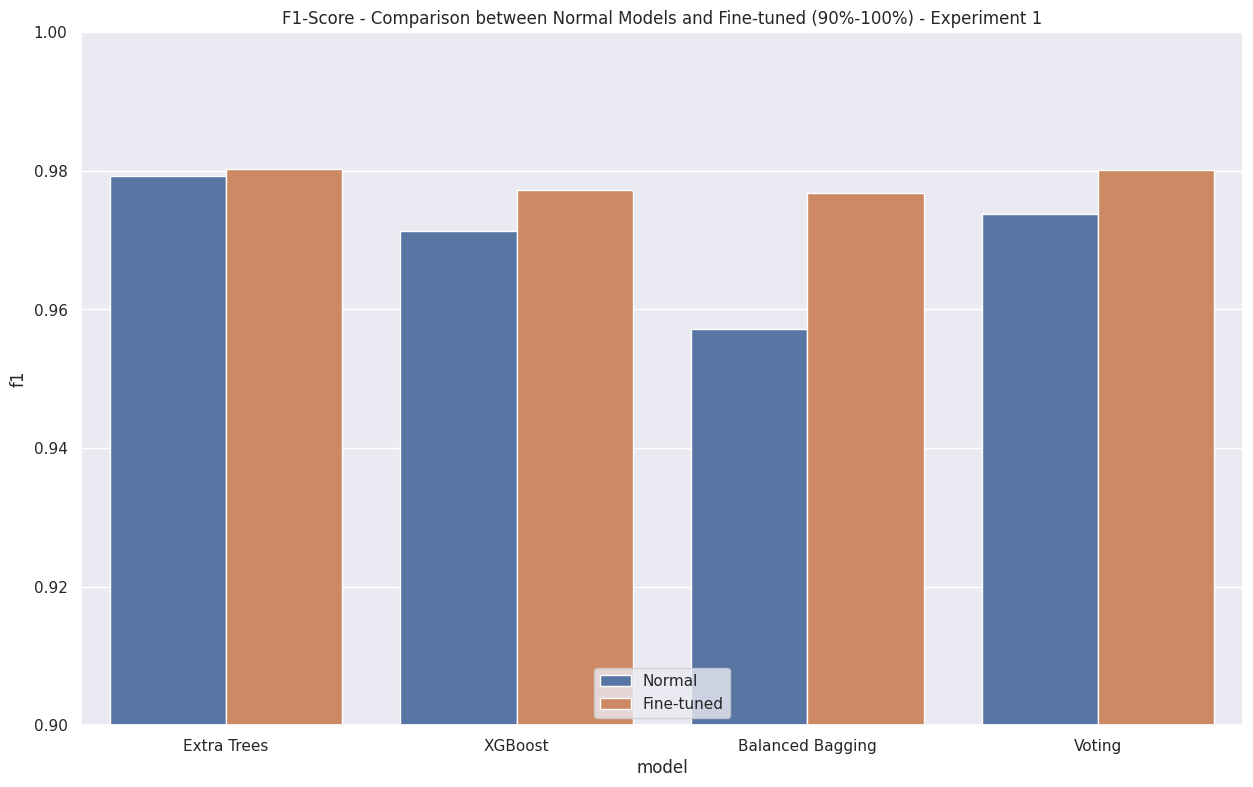

In [ ]:
sns.set(rc={'figure.figsize':(15, 9)})
exp1_comp_barplot = sns.barplot(data=exp1_comp_df, x="model", y="f1", hue="types")
plt.title('F1-Score - Comparison between Normal Models and Fine-tuned (90%-100%) - Experiment 1')
plt.legend(loc="lower center")
plt.ylim(0.9, 1)
sns.reset_orig()

### 3.10.2 Experiment 2

In [ ]:
exp2_comp_etc_df = pd.DataFrame.from_dict({
  "model": [models[0]] * 2,
  "types": types,
  "f1": [exp2_etc_f1[1], exp2_etc_tuned_f1]
})

exp2_comp_xgbc_df = pd.DataFrame.from_dict({
  "model": [models[1]] * 2,
  "types": types,
  "f1": [exp2_xgbc_f1[1], exp2_xgbc_tuned_f1]
})

exp2_comp_bbc_df = pd.DataFrame.from_dict({
  "model": [models[2]] * 2,
  "types": types,
  "f1": [exp2_bbc_f1[1], exp2_bbc_tuned_f1]
})

exp2_comp_voting_df = pd.DataFrame.from_dict({
  "model": [models[3]] * 2,
  "types": types,
  "f1": [exp2_voting_f1[1], exp2_voting_tuned_f1]
})

In [ ]:
exp2_comp_df = pd.concat([exp2_comp_etc_df, exp2_comp_xgbc_df, exp2_comp_bbc_df, exp2_comp_voting_df], ignore_index=True)

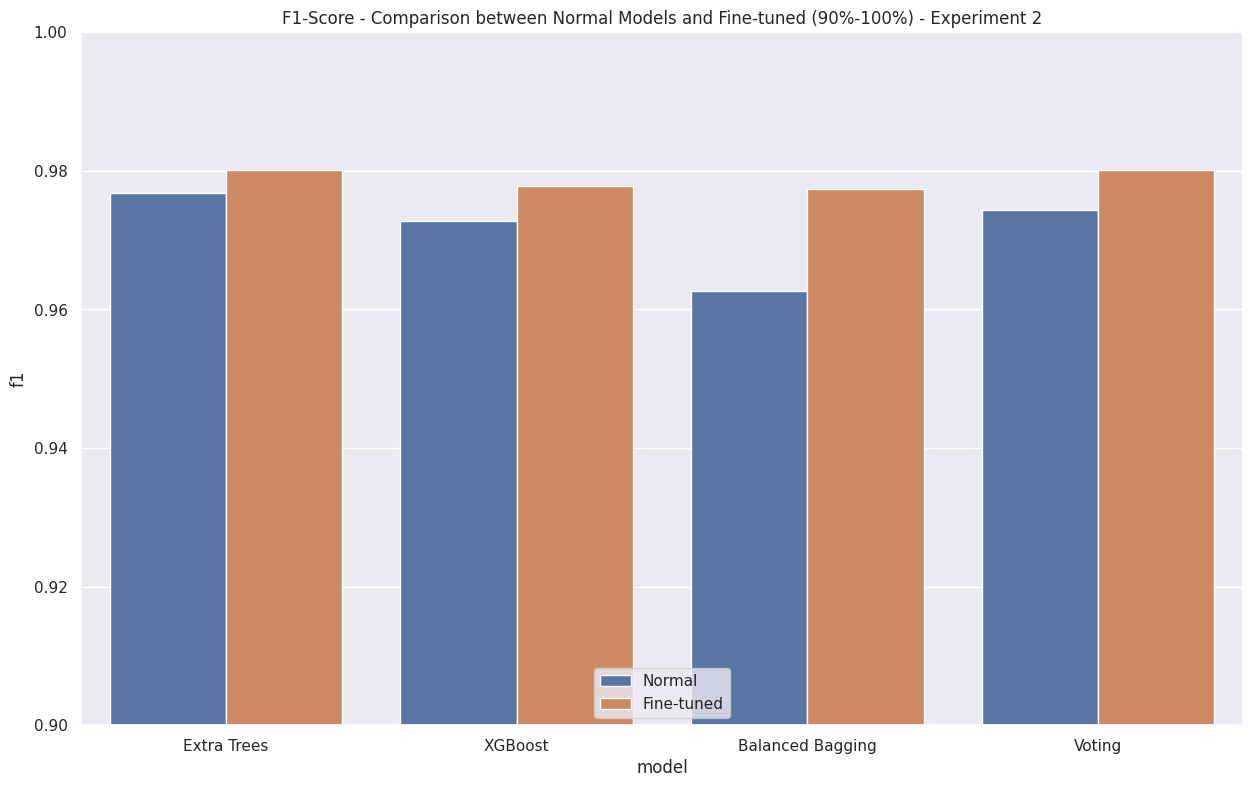

In [ ]:
sns.set(rc={'figure.figsize':(15, 9)})
exp2_comp_barplot = sns.barplot(data=exp2_comp_df, x="model", y="f1", hue="types")
plt.title('F1-Score - Comparison between Normal Models and Fine-tuned (90%-100%) - Experiment 2')
plt.legend(loc="lower center")
plt.ylim(0.9, 1)
sns.reset_orig()

### 3.10.3 Experiment 3

In [ ]:
exp3_comp_etc_df = pd.DataFrame.from_dict({
  "model": [models[0]] * 2,
  "types": types,
  "f1": [exp3_etc_f1[1], exp3_etc_tuned_f1]
})

exp3_comp_xgbc_df = pd.DataFrame.from_dict({
  "model": [models[1]] * 2,
  "types": types,
  "f1": [exp3_xgbc_f1[1], exp3_xgbc_tuned_f1]
})

exp3_comp_bbc_df = pd.DataFrame.from_dict({
  "model": [models[2]] * 2,
  "types": types,
  "f1": [exp3_bbc_f1[1], exp3_bbc_tuned_f1]
})

exp3_comp_voting_df = pd.DataFrame.from_dict({
  "model": [models[3]] * 2,
  "types": types,
  "f1": [exp3_voting_f1[1], exp3_voting_tuned_f1]
})

In [ ]:
exp3_comp_df = pd.concat([exp3_comp_etc_df, exp3_comp_xgbc_df, exp3_comp_bbc_df, exp3_comp_voting_df], ignore_index=True)

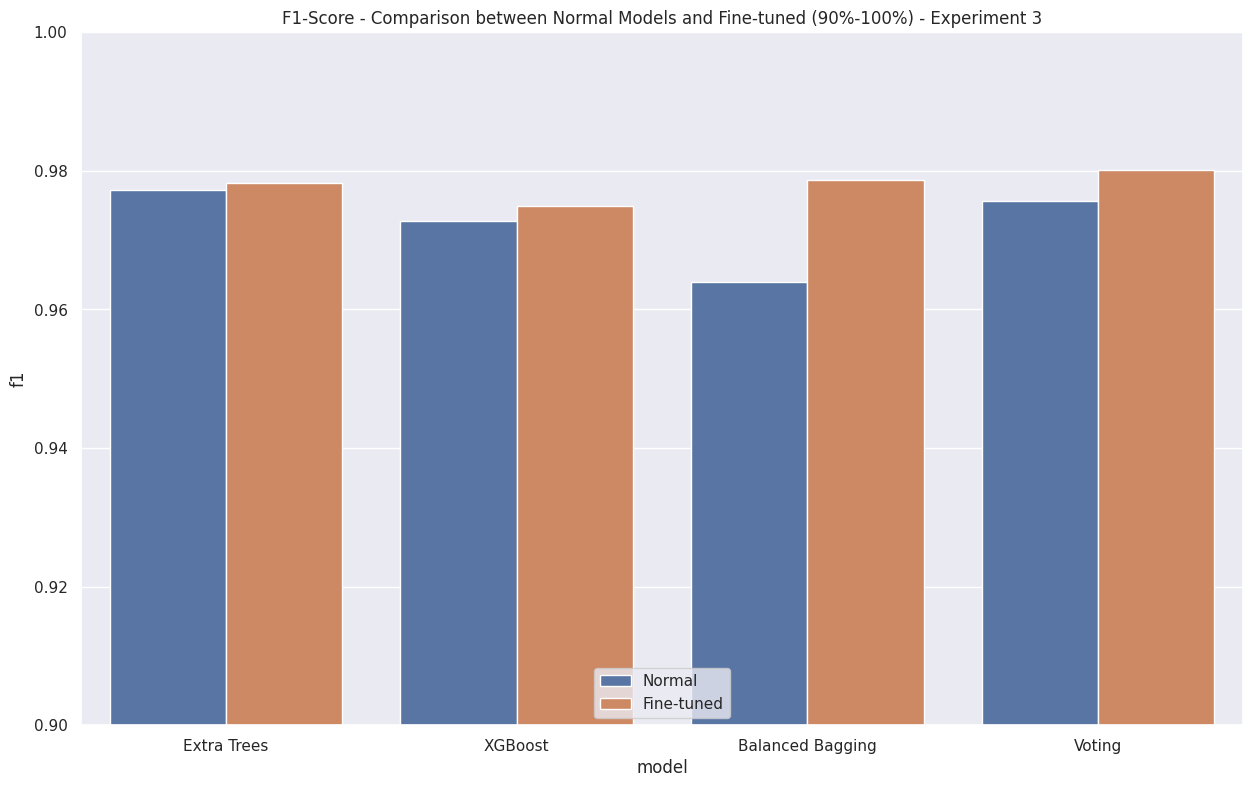

In [ ]:
sns.set(rc={'figure.figsize':(15, 9)})
exp3_comp_barplot = sns.barplot(data=exp3_comp_df, x="model", y="f1", hue="types")
plt.title('F1-Score - Comparison between Normal Models and Fine-tuned (90%-100%) - Experiment 3')
plt.legend(loc="lower center")
plt.ylim(0.9, 1)
sns.reset_orig()

## 3.11 Performance Analysis of Fine-tuned Models

In [ ]:
print("F1-Scores - Experiment 1")
print("========================")
print('Extra Trees      - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(exp1_etc_tuned_f1))
print('XGBoost          - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(exp1_xgbc_tuned_f1))
print('Balanced Bagging - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(exp1_bbc_tuned_f1))
print('Soft Voting      - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(exp1_voting_tuned_f1))
print()
print("F1-Scores - Experiment 2")
print("========================")
print('Extra Trees      - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(exp2_etc_tuned_f1))
print('XGBoost          - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(exp2_xgbc_tuned_f1))
print('Balanced Bagging - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(exp2_bbc_tuned_f1))
print('Soft Voting      - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(exp2_voting_tuned_f1))
print()
print("F1-Scores - Experiment 3")
print("========================")
print('Extra Trees      - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(exp3_etc_tuned_f1))
print('XGBoost          - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(exp3_xgbc_tuned_f1))
print('Balanced Bagging - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(exp3_bbc_tuned_f1))
print('Soft Voting      - Dataset2 (With Resampling Without PCA): {0:.4f}'.format(exp3_voting_tuned_f1))

F1-Scores - Experiment 1
Extra Trees      - Dataset2 (With Resampling Without PCA): 0.9802
XGBoost          - Dataset2 (With Resampling Without PCA): 0.9772
Balanced Bagging - Dataset2 (With Resampling Without PCA): 0.9768
Soft Voting      - Dataset2 (With Resampling Without PCA): 0.9801

F1-Scores - Experiment 2
Extra Trees      - Dataset2 (With Resampling Without PCA): 0.9801
XGBoost          - Dataset2 (With Resampling Without PCA): 0.9778
Balanced Bagging - Dataset2 (With Resampling Without PCA): 0.9774
Soft Voting      - Dataset2 (With Resampling Without PCA): 0.9802

F1-Scores - Experiment 3
Extra Trees      - Dataset2 (With Resampling Without PCA): 0.9783
XGBoost          - Dataset2 (With Resampling Without PCA): 0.9750
Balanced Bagging - Dataset2 (With Resampling Without PCA): 0.9787
Soft Voting      - Dataset2 (With Resampling Without PCA): 0.9802


### 3.11.1 According to Model

In [ ]:
models = ["Extra Trees", "XGBoost", "Balanced Bagging", "Voting"]
experiments = ["Experiment 1", "Experiment 2", "Experiment 3"]

In [ ]:
tuned_etc_df = pd.DataFrame.from_dict({
  "model": [models[0]] * 3,
  "experiments": experiments,
  "f1": [exp1_etc_tuned_f1, exp2_etc_tuned_f1, exp3_etc_tuned_f1]
})

tuned_xgbc_df = pd.DataFrame.from_dict({
  "model": [models[1]] * 3,
  "experiments": experiments,
  "f1": [exp1_xgbc_tuned_f1, exp2_xgbc_tuned_f1, exp3_xgbc_tuned_f1]
})

tuned_bbc_df = pd.DataFrame.from_dict({
  "model": [models[2]] * 3,
  "experiments": experiments,
  "f1": [exp1_bbc_tuned_f1, exp2_bbc_tuned_f1, exp3_bbc_tuned_f1]
})

tuned_voting_df = pd.DataFrame.from_dict({
  "model": [models[3]] * 3,
  "experiments": experiments,
  "f1": [exp1_voting_tuned_f1, exp2_voting_tuned_f1, exp3_voting_tuned_f1]
})

In [ ]:
tuned_summary_df = pd.concat([tuned_etc_df, tuned_xgbc_df, tuned_bbc_df, tuned_voting_df], ignore_index=True)

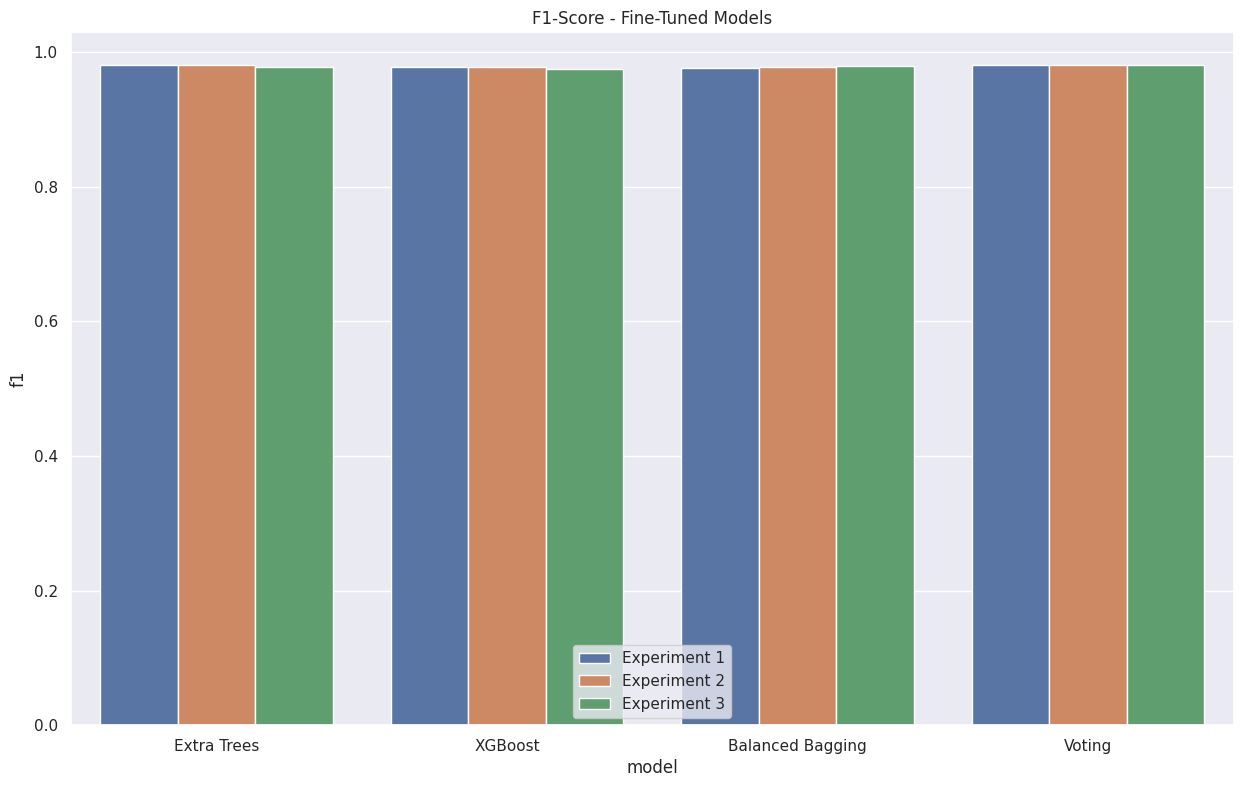

In [ ]:
sns.set(rc={'figure.figsize':(15, 9)})
tuned_summary_barplot = sns.barplot(data=tuned_summary_df, x="model", y="f1", hue="experiments")
plt.title('F1-Score - Fine-Tuned Models')
plt.legend(loc="lower center")
sns.reset_orig()

Let's zoom in!

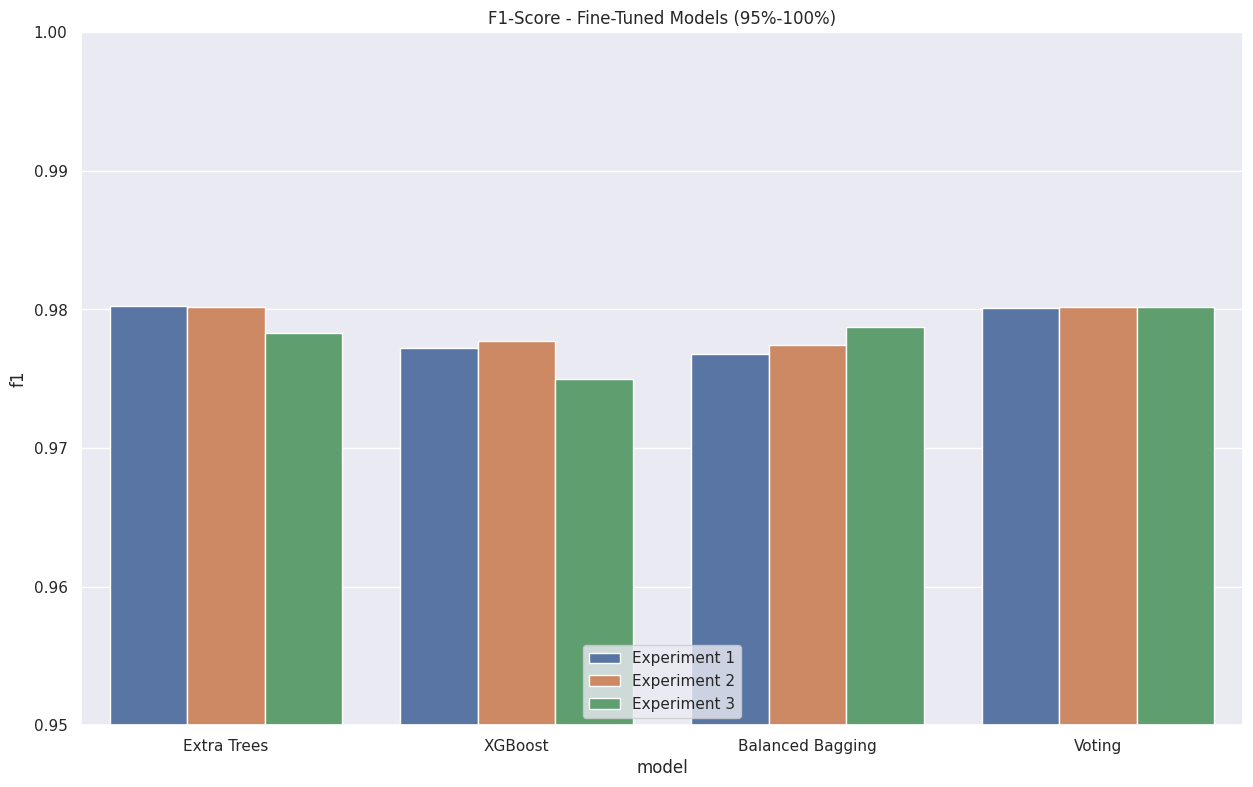

In [ ]:
sns.set(rc={'figure.figsize':(15, 9)})
tuned_summary_barplot = sns.barplot(data=tuned_summary_df, x="model", y="f1", hue="experiments")
plt.title('F1-Score - Fine-Tuned Models (95%-100%)')
plt.ylim(0.95, 1)
plt.legend(loc="lower center")
sns.reset_orig()

### 3.11.2 According to Experiment

In [ ]:
tuned_summary_df = pd.concat([tuned_etc_df, tuned_xgbc_df, tuned_bbc_df, tuned_voting_df], ignore_index=True)

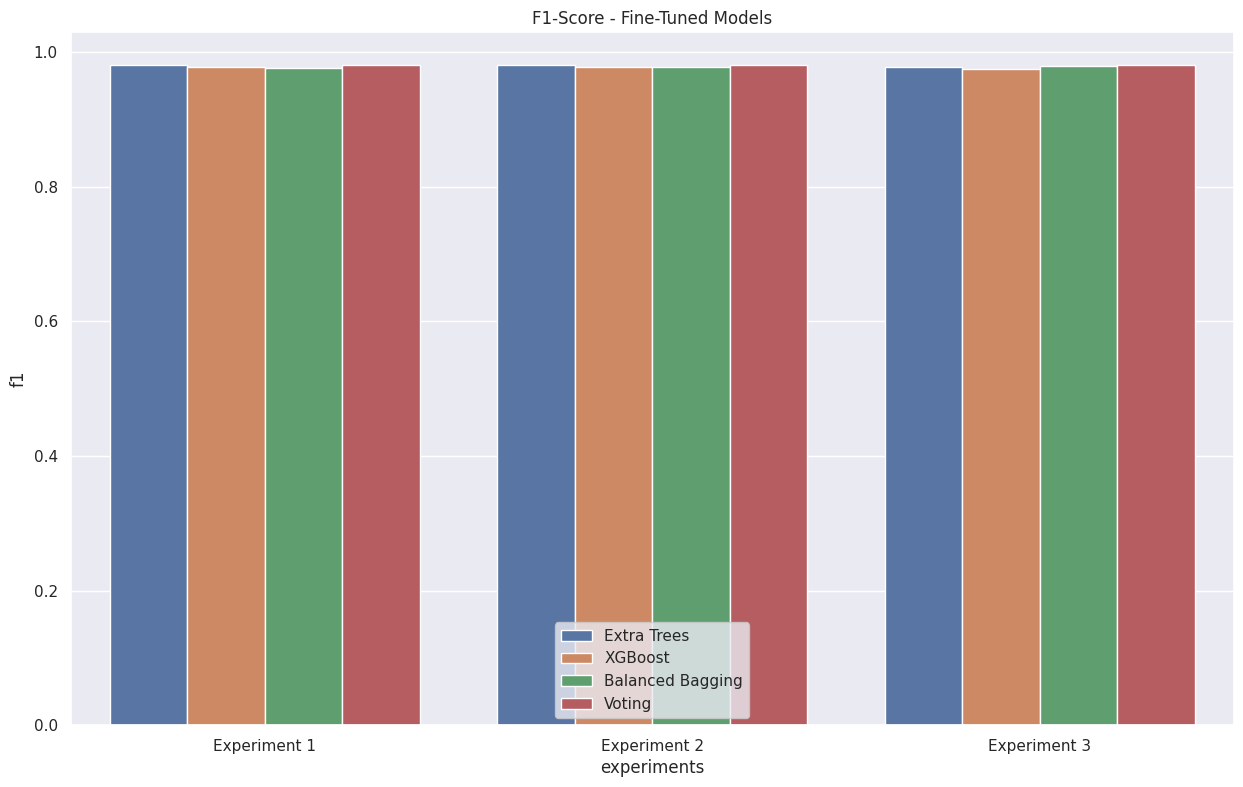

In [ ]:
sns.set(rc={'figure.figsize':(15, 9)})
tuned_summary_barplot = sns.barplot(data=tuned_summary_df, x="experiments", y="f1", hue="model")
plt.title('F1-Score - Fine-Tuned Models')
plt.legend(loc="lower center")
sns.reset_orig()

Let's zoom in!

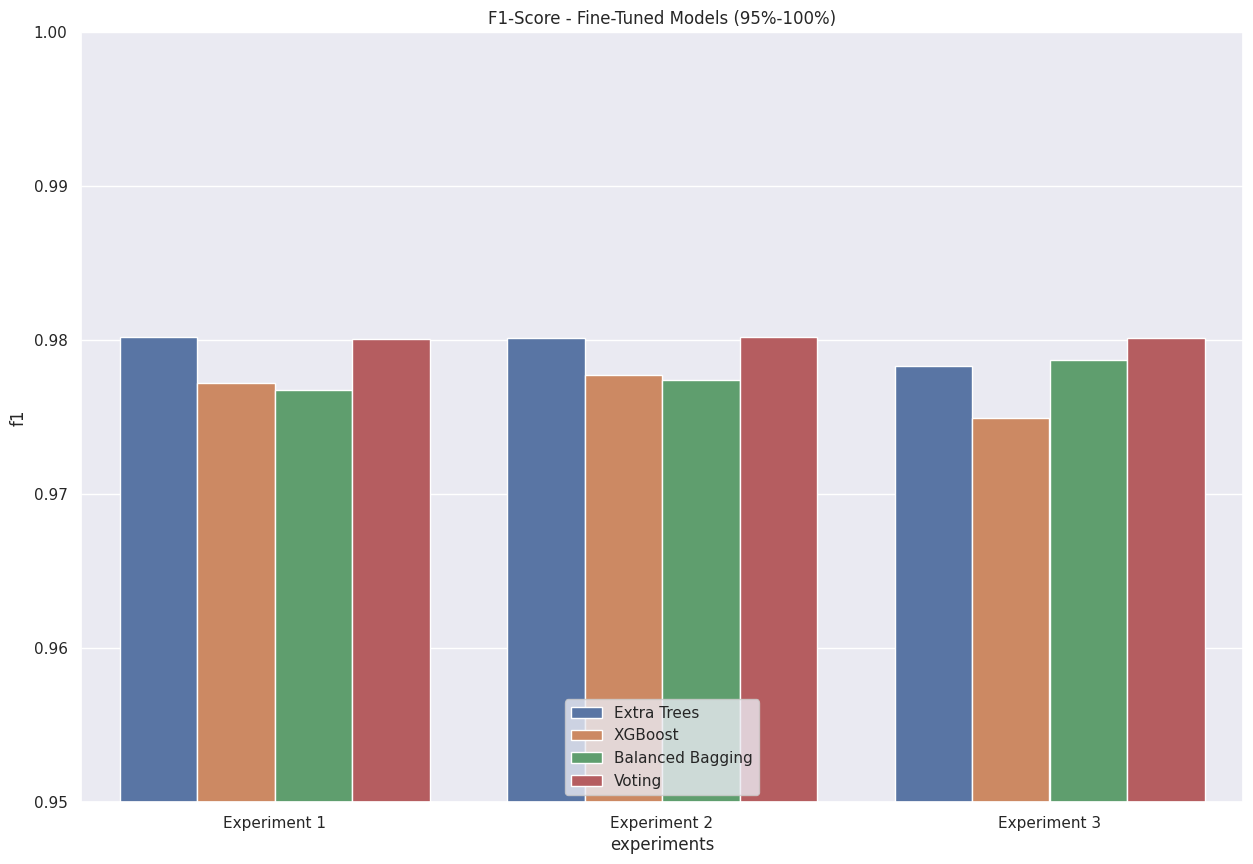

In [ ]:
sns.set(rc={'figure.figsize':(15, 10)})
tuned_summary_barplot = sns.barplot(data=tuned_summary_df, x="experiments", y="f1", hue="model")
plt.title('F1-Score - Fine-Tuned Models (95%-100%)')
plt.ylim(0.95, 1)
plt.legend(loc="lower center")
sns.reset_orig()

### As you can see from the previous plot, the model with highest F1-Score on validation is Soft Voting Classifier (almost in all experiments)

# 4. Evaluation

In [ ]:
y_test_predicted_v1 = exp1_voting_tuned.predict(X_scaled_test_v1)   # Experiment 1

In [ ]:
y_test_predicted_v2 = exp2_voting_tuned.predict(X_scaled_test_v2)   # Experiment 2

In [ ]:
y_test_predicted_v3 = exp3_voting_tuned.predict(X_scaled_test_v3)   # Experiment 3

## 4.1 Classification Report

In [ ]:
target_names = ["class 0 (Don't Accept)", "class 1 (Accept)"]

In [ ]:
print(classification_report(y_test_v1, y_test_predicted_v1, target_names=target_names, digits=4))

                        precision    recall  f1-score   support

class 0 (Don't Accept)     0.9989    0.9878    0.9933       904
      class 1 (Accept)     0.8952    0.9895    0.9400        95

              accuracy                         0.9880       999
             macro avg     0.9471    0.9887    0.9667       999
          weighted avg     0.9890    0.9880    0.9883       999



In [ ]:
print(classification_report(y_test_v2, y_test_predicted_v2, target_names=target_names, digits=4))

                        precision    recall  f1-score   support

class 0 (Don't Accept)     1.0000    0.9878    0.9939       904
      class 1 (Accept)     0.8962    1.0000    0.9453        95

              accuracy                         0.9890       999
             macro avg     0.9481    0.9939    0.9696       999
          weighted avg     0.9901    0.9890    0.9893       999



In [ ]:
print(classification_report(y_test_v3, y_test_predicted_v3, target_names=target_names, digits=4))

                        precision    recall  f1-score   support

class 0 (Don't Accept)     1.0000    0.9856    0.9928       904
      class 1 (Accept)     0.8796    1.0000    0.9360        95

              accuracy                         0.9870       999
             macro avg     0.9398    0.9928    0.9644       999
          weighted avg     0.9886    0.9870    0.9874       999



## 4.2 Precision/Recall Curve

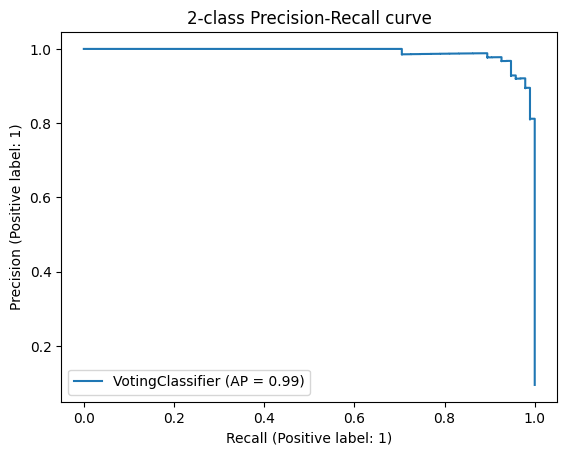

In [ ]:
display = PrecisionRecallDisplay.from_estimator(
    exp1_voting_tuned, X_scaled_test_v1, y_test_v1, name="VotingClassifier"
)
_ = display.ax_.set_title("Precision-Recall Curve (Experiment 1)")

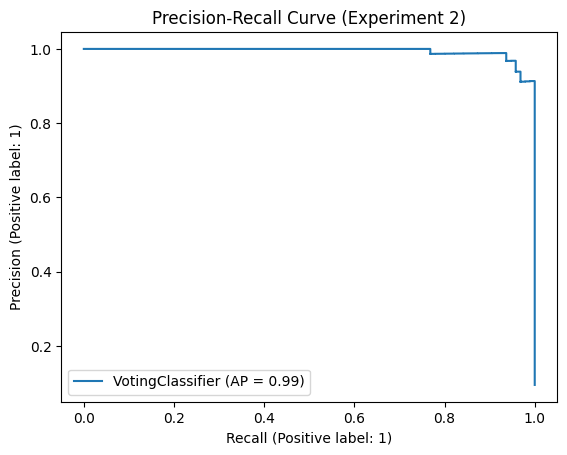

In [ ]:
display = PrecisionRecallDisplay.from_estimator(
    exp2_voting_tuned, X_scaled_test_v2, y_test_v2, name="VotingClassifier"
)
_ = display.ax_.set_title("Precision-Recall Curve (Experiment 2)")

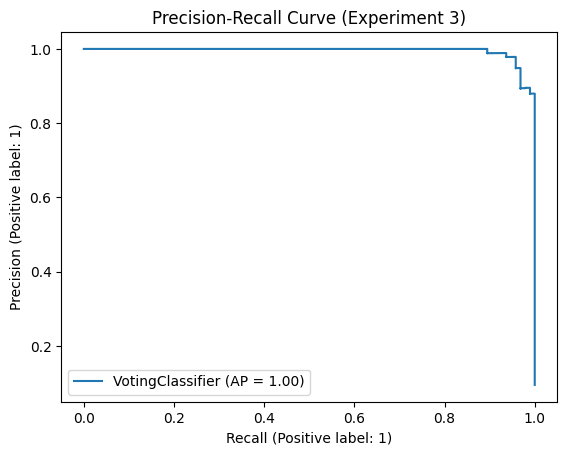

In [ ]:
display = PrecisionRecallDisplay.from_estimator(
    exp3_voting_tuned, X_scaled_test_v3, y_test_v3, name="VotingClassifier"
)
_ = display.ax_.set_title("Precision-Recall Curve (Experiment 3)")

## 4.3 Confusion Matrix

Text(0.5, 47.7222222222222, 'Prediction')

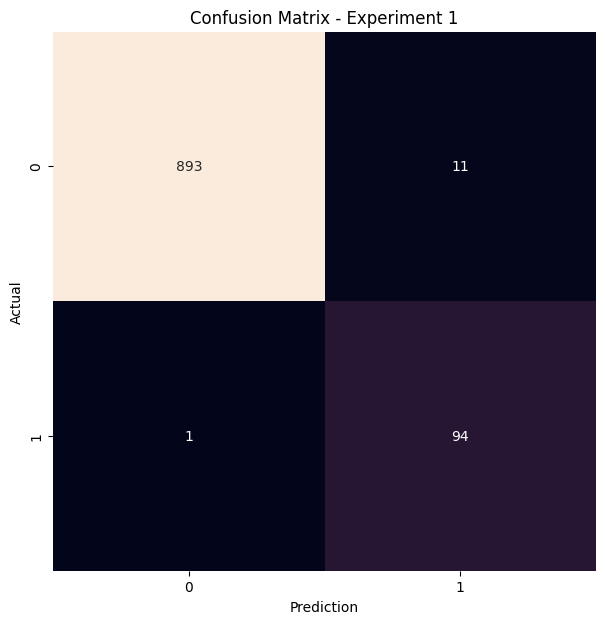

In [ ]:
cm_v1 = confusion_matrix(y_test_v1, y_test_predicted_v1)
plt.figure(figsize=(7,7))
sns.heatmap(cm_v1, annot=True, fmt="d", cbar=False)
plt.title('Confusion Matrix - Experiment 1')
plt.ylabel('Actual')
plt.xlabel('Prediction')

In [ ]:
print('Experiment 1')
print('True Positive  (TP):', cm_v1[1][1])
print('False Positive (FP):', cm_v1[0][1])
print('False Negative (FN):', cm_v1[1][0])
print('True Negative  (TN):', cm_v1[0][0])

Experiment 1
True Positive  (TP): 94
False Positive (FP): 11
False Negative (FN): 1
True Negative  (TN): 893


Text(0.5, 47.7222222222222, 'Prediction')

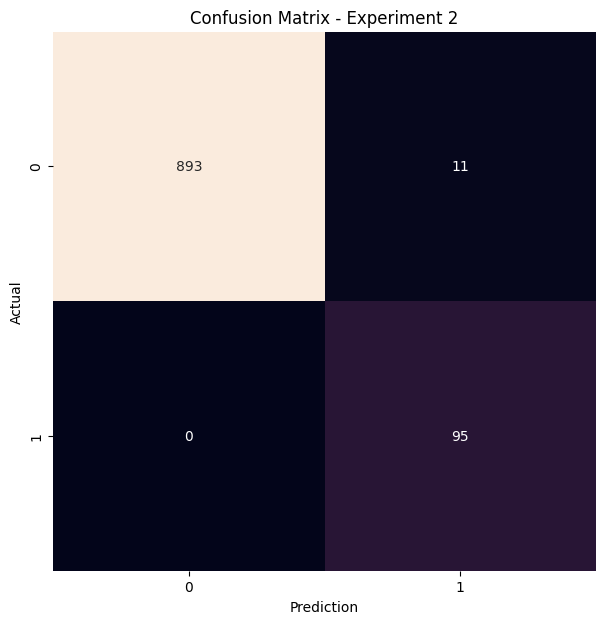

In [ ]:
cm_v2 = confusion_matrix(y_test_v2, y_test_predicted_v2)
plt.figure(figsize=(7,7))
sns.heatmap(cm_v2, annot=True, fmt="d", cbar=False)
plt.title('Confusion Matrix - Experiment 2')
plt.ylabel('Actual')
plt.xlabel('Prediction')

In [ ]:
print('Experiment 2')
print('True Positive  (TP):', cm_v2[1][1])
print('False Positive (FP):', cm_v2[0][1])
print('False Negative (FN):', cm_v2[1][0])
print('True Negative  (TN):', cm_v2[0][0])

Experiment 2
True Positive  (TP): 95
False Positive (FP): 11
False Negative (FN): 0
True Negative  (TN): 893


Text(0.5, 47.7222222222222, 'Prediction')

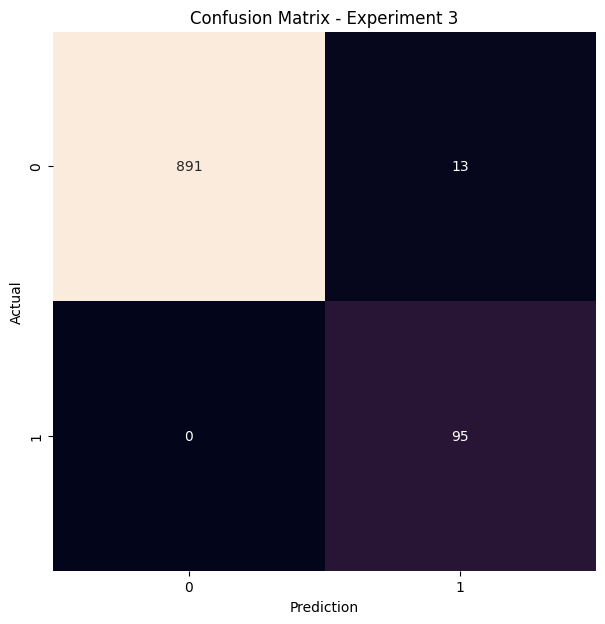

In [ ]:
cm_v3 = confusion_matrix(y_test_v3, y_test_predicted_v3)
plt.figure(figsize=(7,7))
sns.heatmap(cm_v3, annot=True, fmt="d", cbar=False)
plt.title('Confusion Matrix - Experiment 3')
plt.ylabel('Actual')
plt.xlabel('Prediction')

In [ ]:
print('Experiment 3')
print('True Positive  (TP):', cm_v3[1][1])
print('False Positive (FP):', cm_v3[0][1])
print('False Negative (FN):', cm_v3[1][0])
print('True Negative  (TN):', cm_v3[0][0])

Experiment 3
True Positive  (TP): 95
False Positive (FP): 13
False Negative (FN): 0
True Negative  (TN): 891


## 4.4 Feature Importance

Feature: Online               Score: -0.00121
Feature: Securities_Account   Score: -0.00094
Feature: City                 Score: 0.00223
Feature: Mortgage             Score: 0.00307
Feature: Age                  Score: 0.01399
Feature: CreditCard           Score: 0.01660
Feature: Experience           Score: 0.01977
Feature: CD_Account           Score: 0.02458
Feature: CCAvg                Score: 0.09130
Feature: Family               Score: 0.25917
Feature: Education            Score: 0.32984
Feature: Income               Score: 0.67872


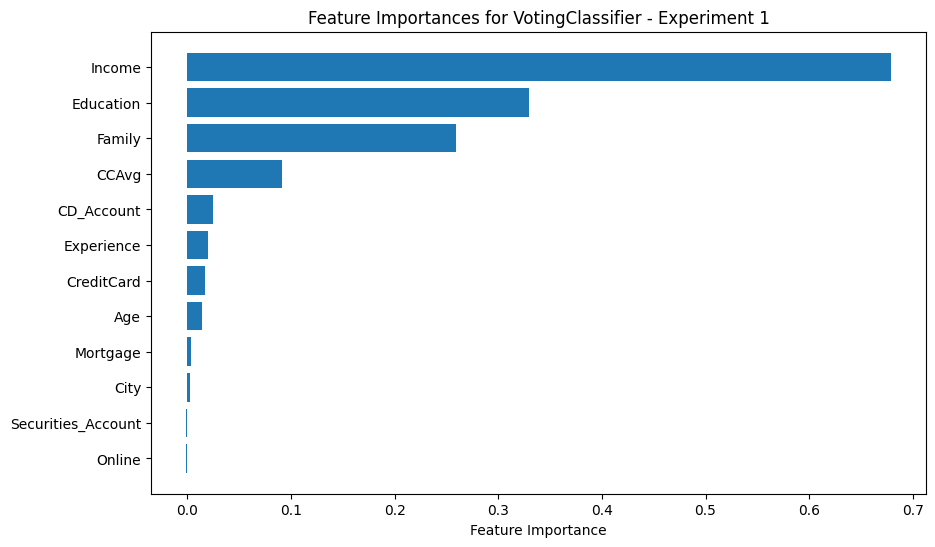

In [ ]:
results = permutation_importance(exp1_voting_tuned, X_scaled_test_v1, y_test_v1, scoring='f1')
importance_v1 = results.importances_mean

importance_v1_sorted, final_feature_names_v1_sorted = (list(t) for t in zip(*sorted(zip(importance_v1, final_feature_names_v1))))

# summarize feature importance
for i,v in enumerate(importance_v1_sorted):
  print('Feature: %-20s Score: %.5f' % (final_feature_names_v1_sorted[i],v))

# plot feature importance
plt.figure(figsize=[10,6])
plt.xlabel('Feature Importance')
plt.title('Feature Importances for VotingClassifier - Experiment 1')
plt.barh(final_feature_names_v1_sorted, importance_v1_sorted)
plt.show()

Feature: City                 Score: 0.00148
Feature: Online               Score: 0.00479
Feature: Securities_Account   Score: 0.00573
Feature: CD_Account           Score: 0.01363
Feature: Mortgage             Score: 0.01523
Feature: Age                  Score: 0.01658
Feature: CreditCard           Score: 0.01891
Feature: Experience           Score: 0.02395
Feature: CCAvg                Score: 0.07239
Feature: Family               Score: 0.27056
Feature: Education            Score: 0.34734
Feature: Income               Score: 0.69896


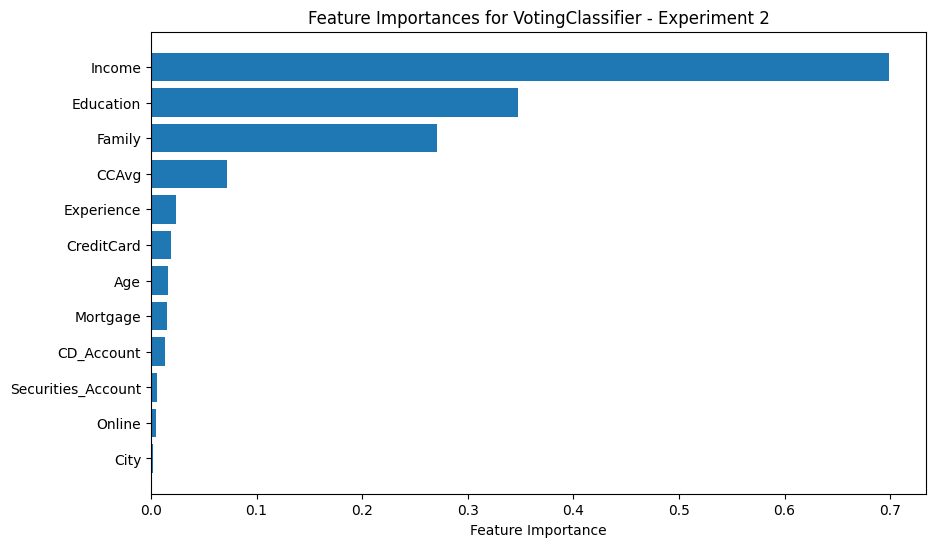

In [ ]:
results = permutation_importance(exp2_voting_tuned, X_scaled_test_v2, y_test_v2, scoring='f1')
importance_v2 = results.importances_mean

importance_v2_sorted, final_feature_names_v2_sorted = (list(t) for t in zip(*sorted(zip(importance_v2, final_feature_names_v1))))

# summarize feature importance
for i,v in enumerate(importance_v2_sorted):
  print('Feature: %-20s Score: %.5f' % (final_feature_names_v2_sorted[i],v))

# plot feature importance
plt.figure(figsize=[10,6])
plt.xlabel('Feature Importance')
plt.title('Feature Importances for VotingClassifier - Experiment 2')
plt.barh(final_feature_names_v2_sorted, importance_v2_sorted)
plt.show()

Feature: Online               Score: 0.00104
Feature: Securities_Account   Score: 0.00118
Feature: County               Score: 0.00336
Feature: Age                  Score: 0.00667
Feature: CreditCard           Score: 0.00724
Feature: Mortgage             Score: 0.00835
Feature: CD_Account           Score: 0.01076
Feature: Experience           Score: 0.01287
Feature: CCAvg                Score: 0.10767
Feature: Family               Score: 0.25742
Feature: Education            Score: 0.34218
Feature: Income               Score: 0.65851


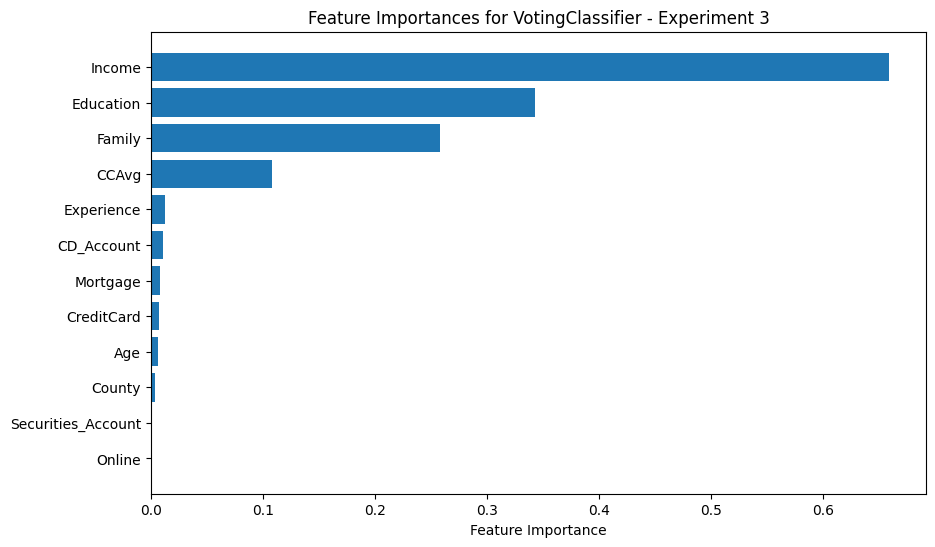

In [ ]:
results = permutation_importance(exp3_voting_tuned, X_scaled_test_v3, y_test_v3, scoring='f1')
importance_v3 = results.importances_mean

importance_v3_sorted, final_feature_names_v3_sorted = (list(t) for t in zip(*sorted(zip(importance_v3, final_feature_names_v3))))

# summarize feature importance
for i,v in enumerate(importance_v3_sorted):
  print('Feature: %-20s Score: %.5f' % (final_feature_names_v3_sorted[i],v))

# plot feature importance
plt.figure(figsize=[10,6])
plt.xlabel('Feature Importance')
plt.title('Feature Importances for VotingClassifier - Experiment 3')
plt.barh(final_feature_names_v3_sorted, importance_v3_sorted)
plt.show()